Aim 1: Load the dataframe and perform preprocessing

In [1]:
import pandas as pd
import numpy as np

DATASET_FILE = "dataset.csv"
dataframe = pd.read_csv(DATASET_FILE)
# print(dataframe)

# define random seed
random_seed = 23907251

# allows hospitals to customize recall bias
# this will be used later to bias the weighted f1 scoring,
# which is on the same scale as f1 but biases recall / precision
# a recall_factor of 0.5 means regular f1 scoring is used
# NOTE: THIS ONLY AFFECTS FINAL TESTING PERFORMANCE
# it does not affect training at all!!
recall_factor = 0.5

In [2]:
# Aim 1.1: convert lethal outcome to binary dead / alive
target = 'LET_IS'
dataframe[target] = dataframe[target].apply(lambda x: 1 if x >= 1 else 0)
# print(dataframe)

I will have the following datasets:

train: this is used as training data, as well as for evaluating missingness / correlation with target 'LET_IS', and thus dropping features

validation: this is used as validation data, specifically for testing all of the models built and choosing the best one for each category to test on test data

test: this is used as test data, and is only used ONCE to report the performance of the models that had been chosen based on performance on validation data

tune: this is used to perform feature selection for the target variable and for complication variables

threshold: this is used as test data specifically for the task of picking optimal thresholds for converting regressor output to classification

In [3]:
# Aim 1.2: Perform stratified split
from sklearn.model_selection import train_test_split

# split should be: 10%/10%/50%/15%/15% for feature selection/threshold/training/validation/test
train_validation_tune_threshold, test = train_test_split(dataframe, test_size = 0.15, random_state = random_seed, stratify = dataframe[target])
train_validation_threshold, tune = train_test_split(train_validation_tune_threshold, test_size = 0.1/0.85, random_state = random_seed, stratify = train_validation_tune_threshold[target])
train_validation, threshold = train_test_split(train_validation_threshold, test_size = 0.1/0.75, random_state = random_seed, stratify = train_validation_threshold[target])
train, validation = train_test_split(train_validation, test_size = 0.2/.65, random_state = random_seed, stratify = train_validation[target])

# print(train)
# print(validation)
# print(test)
# print(tune)
# print(threshold)

In [4]:
# Aim 1.3.1: drop features with overwhelming % missing values + not enough correlation with target, 
# only use training for analysis to avoid biasing tune/validation/test

correlation_matrix = train.corr()

# generate list of columns to drop
drop_col_list = []

# generate list of all other columns, including features, complications, ID, and target
all_columns = []

for col in train.columns:
        
    # check the percentage of nan values in the column
    nan_percentage = train[col].isnull().mean()

    # check the correlation with the target variable among rows that are not NaN (pandas excludes those rows from correlation matrix)
    target_correlation = correlation_matrix[col][target]

    # policy: drop features with >20% NaN and less than 0.1 correlation with the target variable, in addition to features with >60% NaN
    if nan_percentage > 0.2 and abs(target_correlation) < 0.1 or nan_percentage > 0.6:
        print(f"DROPPING {col} missing values %: {nan_percentage}, correlation with target: {target_correlation}")
        drop_col_list.append(col)
    else:
        all_columns.append(col)

# define datasets for convenience
datasets = {
    'train' : train,
    'validation': validation,
    'test': test,
    'tune': tune,
    'train_validation': train_validation,
    'train_validation_threshold': train_validation_threshold,
    'train_validation_tune_threshold': train_validation_tune_threshold,
    'threshold':threshold
}

# print(datasets['train'])

# update the datasets
for dataset_string, ds in datasets.items():
    datasets[dataset_string] = ds.drop(columns=drop_col_list)

# print(datasets['train'])

DROPPING IBS_NASL missing values %: 0.9528795811518325, correlation with target: -0.10482848367219183
DROPPING S_AD_KBRIG missing values %: 0.662303664921466, correlation with target: -0.14084229323245342
DROPPING D_AD_KBRIG missing values %: 0.662303664921466, correlation with target: -0.18319298803311937
DROPPING GIPO_K missing values %: 0.22774869109947643, correlation with target: 0.0098561108751491
DROPPING K_BLOOD missing values %: 0.22774869109947643, correlation with target: 0.009330030570684404
DROPPING GIPER_NA missing values %: 0.23036649214659685, correlation with target: -0.02593319267241716
DROPPING NA_BLOOD missing values %: 0.23036649214659685, correlation with target: -0.028147848233800205
DROPPING KFK_BLOOD missing values %: 0.9986910994764397, correlation with target: nan
DROPPING NA_KB missing values %: 0.40445026178010474, correlation with target: 0.008120351148947156
DROPPING LID_KB missing values %: 0.4162303664921466, correlation with target: -0.0747684900966449

In [5]:
# define complications
complications = ['FIBR_PREDS', 'PREDS_TAH', 'JELUD_TAH', 'FIBR_JELUD', 'A_V_BLOK', 'OTEK_LANC', 'RAZRIV', 'DRESSLER', 'ZSN', 'REC_IM', 'P_IM_STEN']

# define predictors based on (post dropped columns) minus (complications, target, ID)
predictors = [x for x in all_columns if x not in complications and x != target and x != 'ID']

In [6]:
# Aim 1.3.2: Utilize forward-filling for missing time-series data

# define time series lists based on desctription of statistics document that accompanied the dataset
op_time_series_list = ['NA_R_1_n', 'NA_R_2_n', 'NA_R_3_n']
nsaid_time_series_list = ['NOT_NA_1_n', 'NOT_NA_2_n', 'NOT_NA_3_n']
pain_time_series_list = ['R_AB_1_n', 'R_AB_2_n', 'R_AB_3_n']
time_series_list = [op_time_series_list, nsaid_time_series_list, pain_time_series_list]

def forward_fill(slice_of_dataframe):
    slice_filled = slice_of_dataframe.ffill(axis=1)
    return slice_filled

for dataset_string, ds in datasets.items():
    for time_series_cols in time_series_list:
        # forward fill just that slice of the dataframe
        ds[time_series_cols] = forward_fill(ds[time_series_cols])
    datasets[dataset_string] = ds

# print(datasets['train'][op_time_series_list])
# print(train[op_time_series_list])

In [7]:
# Aim 1.3.3: Imputation using single-imputation and KNNImputer. Fit on train, transform on test for all cases of training and testing. 
from sklearn.impute import SimpleImputer, KNNImputer

def impute(fit, transform, type, predictors):

    fit_imputed = fit.copy()
    transform_imputed = transform.copy()
    
    if type == 'single':
        imputer = SimpleImputer(strategy='median')
        # transform columns one by one
        for col in predictors:
            fit_imputed[col] = imputer.fit_transform(fit[col].values.reshape(-1, 1))
            transform_imputed[col] = imputer.transform(transform[col].values.reshape(-1, 1))
    
    elif type == 'knn':  
        knn_imputer = KNNImputer(n_neighbors=10)
        
        fit_knn_imputed = knn_imputer.fit_transform(fit[predictors])
        transform_knn_imputed = knn_imputer.transform(transform[predictors])
        
        # convert to dataframe, crucially ensure that index matches fit index
        fit_knn_imputed_df = pd.DataFrame(fit_knn_imputed, columns=predictors, index = fit.index)
        transform_knn_imputed_df = pd.DataFrame(transform_knn_imputed, columns=predictors, index = transform.index)
        
        # since index matches, this works
        fit_imputed[predictors] = fit_knn_imputed_df
        transform_imputed[predictors] = transform_knn_imputed_df
    else:
        return
    return fit_imputed, transform_imputed

single_impute_datasets = {}
knn_impute_datasets = {}

# Avoid data leakage!
# fit on train, transform on validation
single_impute_datasets['train'], single_impute_datasets['validation'] = impute(datasets['train'], datasets['validation'], 'single', predictors)
knn_impute_datasets['train'], knn_impute_datasets['validation'] = impute(datasets['train'], datasets['validation'], 'knn', predictors)

# fit on train, transform on threshold
single_impute_datasets['train'], single_impute_datasets['threshold'] = impute(datasets['train'], datasets['threshold'], 'single', predictors)
knn_impute_datasets['train'], knn_impute_datasets['threshold'] = impute(datasets['train'], datasets['threshold'], 'knn', predictors)

# fit on train_validation_tune, transform on test
single_impute_datasets['train_validation_tune_threshold'], single_impute_datasets['test'] = impute(datasets['train_validation_tune_threshold'], datasets['test'], 'single', predictors)
knn_impute_datasets['train_validation_tune_threshold'], knn_impute_datasets['test'] = impute(datasets['train_validation_tune_threshold'], datasets['test'], 'knn', predictors)

# fit and transform on tune
single_impute_datasets['tune'], _ = impute(datasets['tune'], datasets['tune'], 'single', predictors)
knn_impute_datasets['tune'], _ = impute(datasets['tune'], datasets['tune'], 'knn', predictors)

# fit and transform on train_validation
single_impute_datasets['train_validation'], _ = impute(datasets['train_validation'], datasets['train_validation'], 'single', predictors)
knn_impute_datasets['train_validation'], _ = impute(datasets['train_validation'], datasets['train_validation'], 'knn', predictors)

In [8]:
# Aim 1.4: standardize continuous numerical features using SKLearn robust scaler
# I found the continuous numerical features by searching for 'numeric' on descriptive statistics pdf
from sklearn.preprocessing import RobustScaler

# note: some of the features may have been dropped, code must handle this fact gracefully
numeric_cols = ['AGE', 'S_AD_KBRIG', 'D_AD_KBRIG', 'S_AD_ORIT', 'D_AD_ORIT', 'K_BLOOD', 'NA_BLOOD', 'ALT_BLOOD', 'AST_BLOOD', 'KFK_BLOOD', 'L_BLOOD', 'ROE']

def fit_trans_scale(fit, transform, cols):
    # gracefully handle if the col was dropped
    nondropped_cols = [col for col in cols if col not in drop_col_list]
    
    fit_copy = fit.copy()
    transform_copy = transform.copy()
    scaler = RobustScaler()

    # fit on the fit dataframe
    scaler.fit(fit_copy[nondropped_cols])

    # transform on fit and trans
    fit_copy[nondropped_cols] = scaler.transform(fit_copy[nondropped_cols])
    transform_copy[nondropped_cols] = scaler.transform(transform_copy[nondropped_cols])
    return fit_copy, transform_copy

# separete into the two imputation strategies
scaled_single_datasets = {}
scaled_knn_datasets = {}

# Avoid data leakage!
# fit on train, transform on validation
scaled_single_datasets['train'], scaled_single_datasets['validation'] = fit_trans_scale(single_impute_datasets['train'], single_impute_datasets['validation'], numeric_cols)
scaled_knn_datasets['train'], scaled_knn_datasets['validation'] = fit_trans_scale(knn_impute_datasets['train'], knn_impute_datasets['validation'], numeric_cols)

# fit on train, transform on threshold
scaled_single_datasets['train'], scaled_single_datasets['threshold'] = fit_trans_scale(single_impute_datasets['train'], single_impute_datasets['threshold'], numeric_cols)
scaled_knn_datasets['train'], scaled_knn_datasets['threshold'] = fit_trans_scale(knn_impute_datasets['train'], knn_impute_datasets['threshold'], numeric_cols)

# fit on train_validation_tune, transform on test
scaled_single_datasets['train_validation_tune_threshold'], scaled_single_datasets['test'] = fit_trans_scale(single_impute_datasets['train_validation_tune_threshold'], single_impute_datasets['test'], numeric_cols)
scaled_knn_datasets['train_validation_tune_threshold'], scaled_knn_datasets['test'] = fit_trans_scale(knn_impute_datasets['train_validation_tune_threshold'], knn_impute_datasets['test'], numeric_cols)

# fit and transform on tune
scaled_single_datasets['tune'], _ = fit_trans_scale(single_impute_datasets['tune'], single_impute_datasets['tune'], numeric_cols)
scaled_knn_datasets['tune'], _ = fit_trans_scale(knn_impute_datasets['tune'], knn_impute_datasets['tune'], numeric_cols)

# fit and transform on train_validation
scaled_single_datasets['train_validation'], _ = fit_trans_scale(single_impute_datasets['train_validation'], single_impute_datasets['train_validation'], numeric_cols)
scaled_knn_datasets['train_validation'], _ = fit_trans_scale(knn_impute_datasets['train_validation'], knn_impute_datasets['train_validation'], numeric_cols)

In [9]:
# Aim 2.0: Perform feature selection - define functions
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

def graph_features(reg, columns, target_variable):
    feature_importances = reg.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': columns, 'Importance': feature_importances})
    
    # sort
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    # cutoff bottom values to make graph presentable
    feature_importance_df = feature_importance_df[:60]
    
    plt.figure(figsize=(20, 12))
    bar_width = 0.5
    bar_spacing = 0.2
    
    bar_positions = range(len(feature_importance_df['Feature']))
    bar_positions = [pos + i * (bar_width + bar_spacing) for i, pos in enumerate(bar_positions)]
    plt.bar(bar_positions, feature_importance_df['Importance'], width=bar_width, edgecolor='black')
    
    plt.xticks(bar_positions, feature_importance_df['Feature'], rotation='vertical', fontsize=10)
    plt.ylabel('Importance')
    plt.xlabel('Feature')
    plt.title(f'Random Forest Regression Feature Importance for {target_variable}')
    
    plt.show()

    return feature_importance_df

def feature_selection_graph(tune, target_variable):

    tune_features = tune[predictors]
    tune_target = tune[target_variable]
    
    # use random forest regressor for feature selection
    reg = RandomForestRegressor(random_state=random_seed)
    reg.fit(tune_features, tune_target)
    return graph_features(reg, tune_features.columns, target_variable)


def select_up_to_stop_feature(feature_importance, stop_feature):
    # stop_feature is the lowest valued feature to be kept, this function selects all features up to the stop feature and returns them
    stop_index = feature_importance[feature_importance['Feature'] == stop_feature].index[0]
    filtered_feature_importance = feature_importance.loc[:stop_index].reset_index(drop=True)
    features_selected = list(filtered_feature_importance['Feature'])
    return features_selected

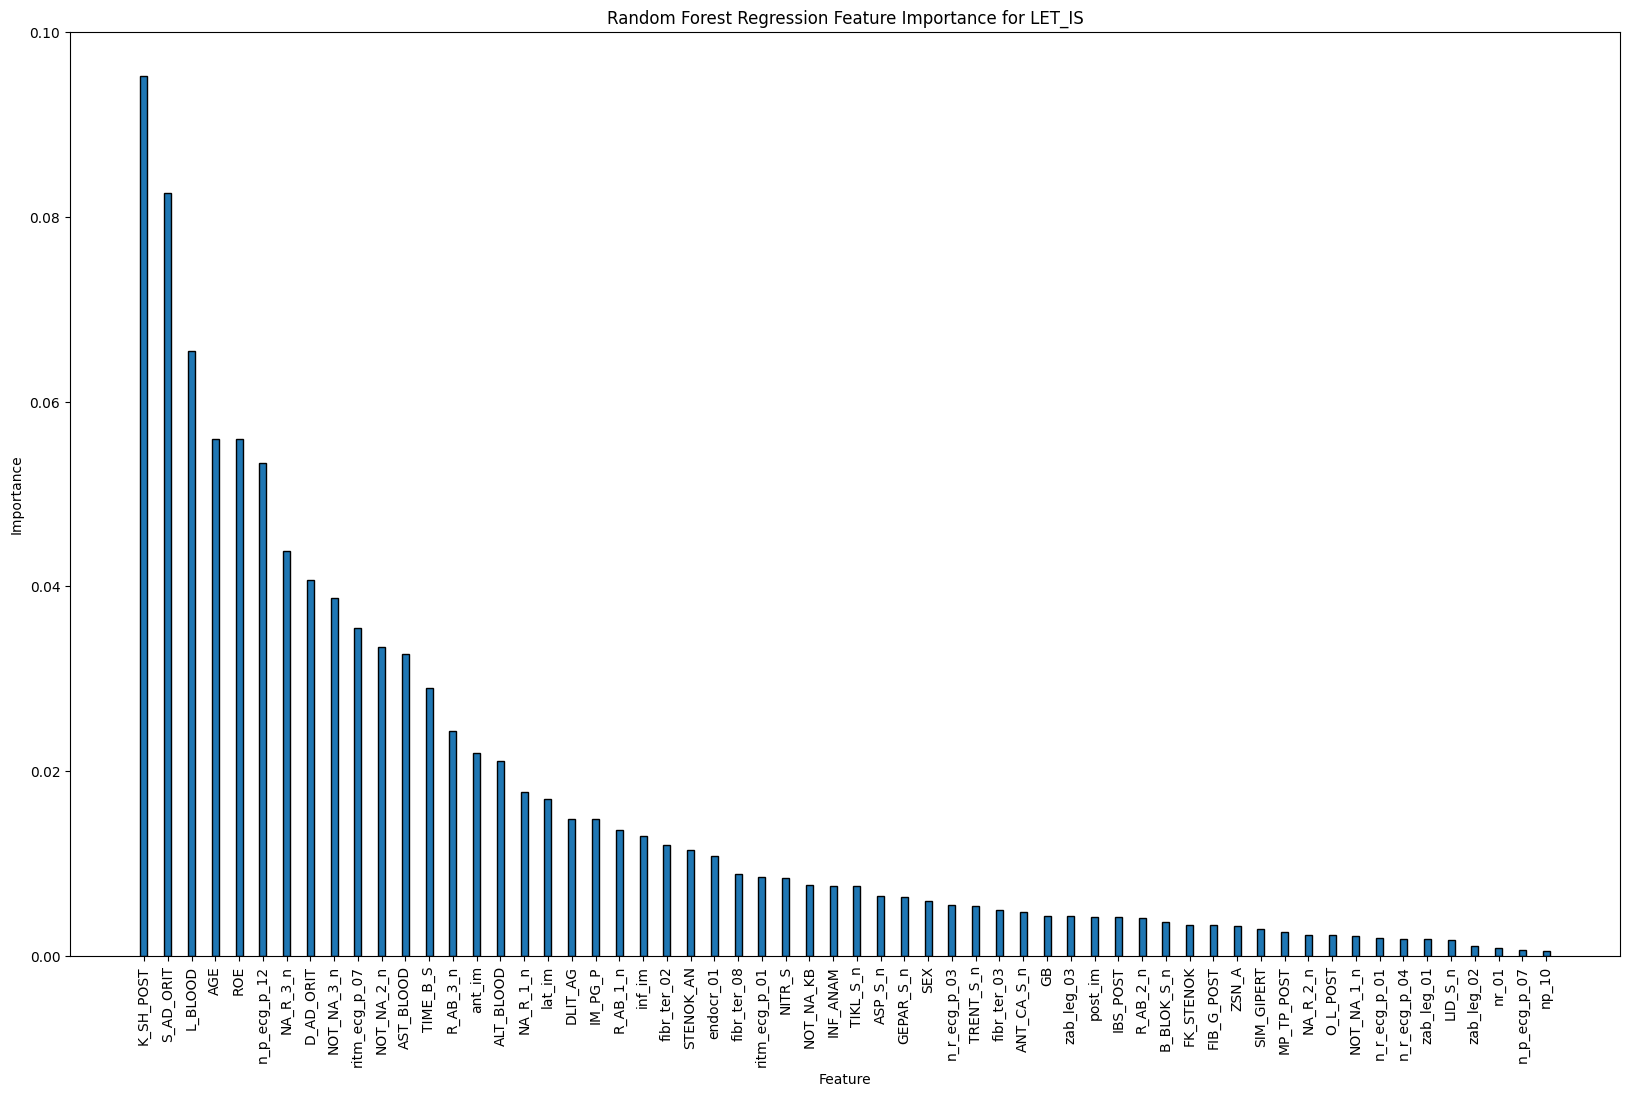

['K_SH_POST', 'S_AD_ORIT', 'L_BLOOD', 'AGE', 'ROE', 'n_p_ecg_p_12', 'NA_R_3_n', 'D_AD_ORIT', 'NOT_NA_3_n', 'ritm_ecg_p_07', 'NOT_NA_2_n', 'AST_BLOOD', 'TIME_B_S', 'R_AB_3_n', 'ant_im', 'ALT_BLOOD', 'NA_R_1_n', 'lat_im', 'DLIT_AG', 'IM_PG_P', 'R_AB_1_n', 'inf_im']


In [10]:
# Aim 2.1: Perform feature selection - apply functions for single imputation
# single tune
single_tune = scaled_single_datasets['tune']
single_feature_importance = feature_selection_graph(single_tune, target)
# 'inf_im' was manually selected based on elbow method
single_features_selected_target = select_up_to_stop_feature(single_feature_importance, 'inf_im')
print(single_features_selected_target)

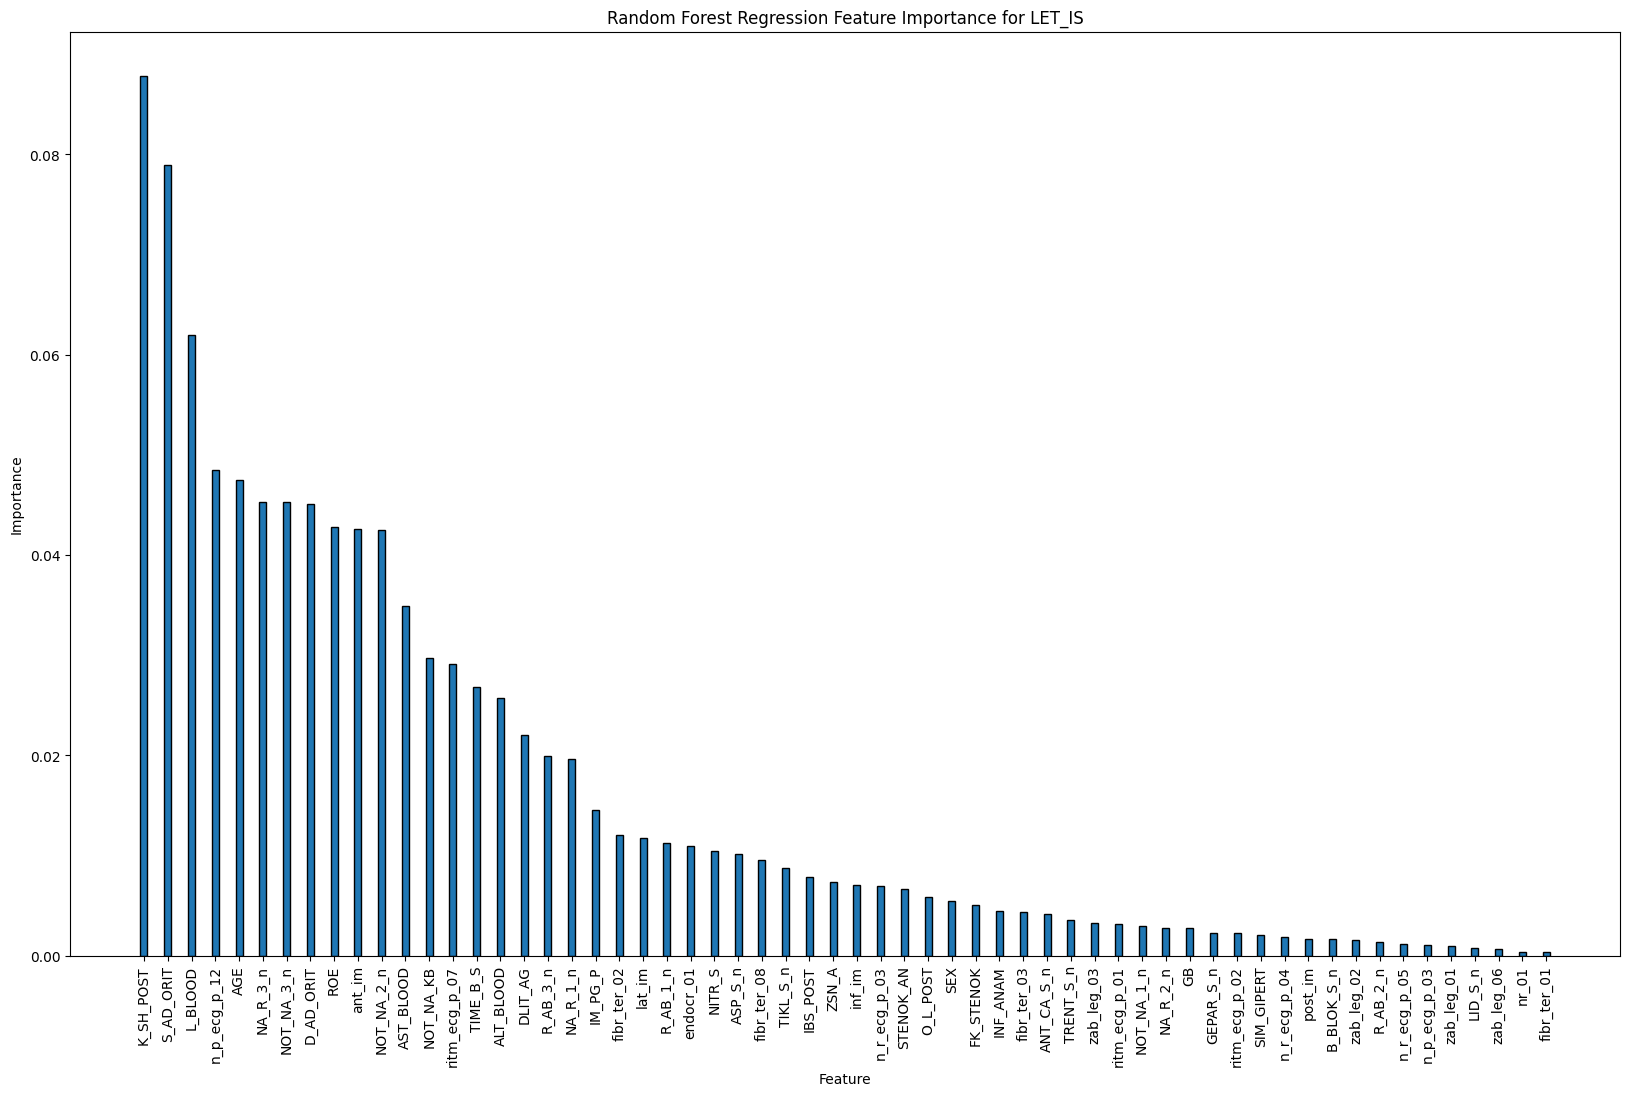

['K_SH_POST', 'S_AD_ORIT', 'L_BLOOD', 'n_p_ecg_p_12', 'AGE', 'NA_R_3_n', 'NOT_NA_3_n', 'D_AD_ORIT', 'ROE', 'ant_im', 'NOT_NA_2_n', 'AST_BLOOD', 'NOT_NA_KB', 'ritm_ecg_p_07', 'TIME_B_S', 'ALT_BLOOD', 'DLIT_AG', 'R_AB_3_n', 'NA_R_1_n', 'IM_PG_P', 'fibr_ter_02', 'lat_im', 'R_AB_1_n', 'endocr_01', 'NITR_S', 'ASP_S_n', 'fibr_ter_08', 'TIKL_S_n', 'IBS_POST', 'ZSN_A']


In [11]:
# Aim 2.1: Perform feature selection - apply functions for knn imputation
# knn tune
knn_tune = scaled_knn_datasets['tune']
knn_feature_importance = feature_selection_graph(knn_tune, target)
# 'ZSN_A' was chosen based on elbow method
knn_features_selected_target = select_up_to_stop_feature(knn_feature_importance, 'ZSN_A')
print(knn_features_selected_target)

By the elbow method, for single imputation, only keep the top 21 features with the lowest value feature kept being 'inf_im'
By the elbow method, for knn imputation, only keep the top 26 features with the lowest value feature kept being 'ZSN_A'

Revised Aim 2.2: Perform feature selection for each complication target variable,
with the goal of ultimately building a strong model for predicting each complication variable

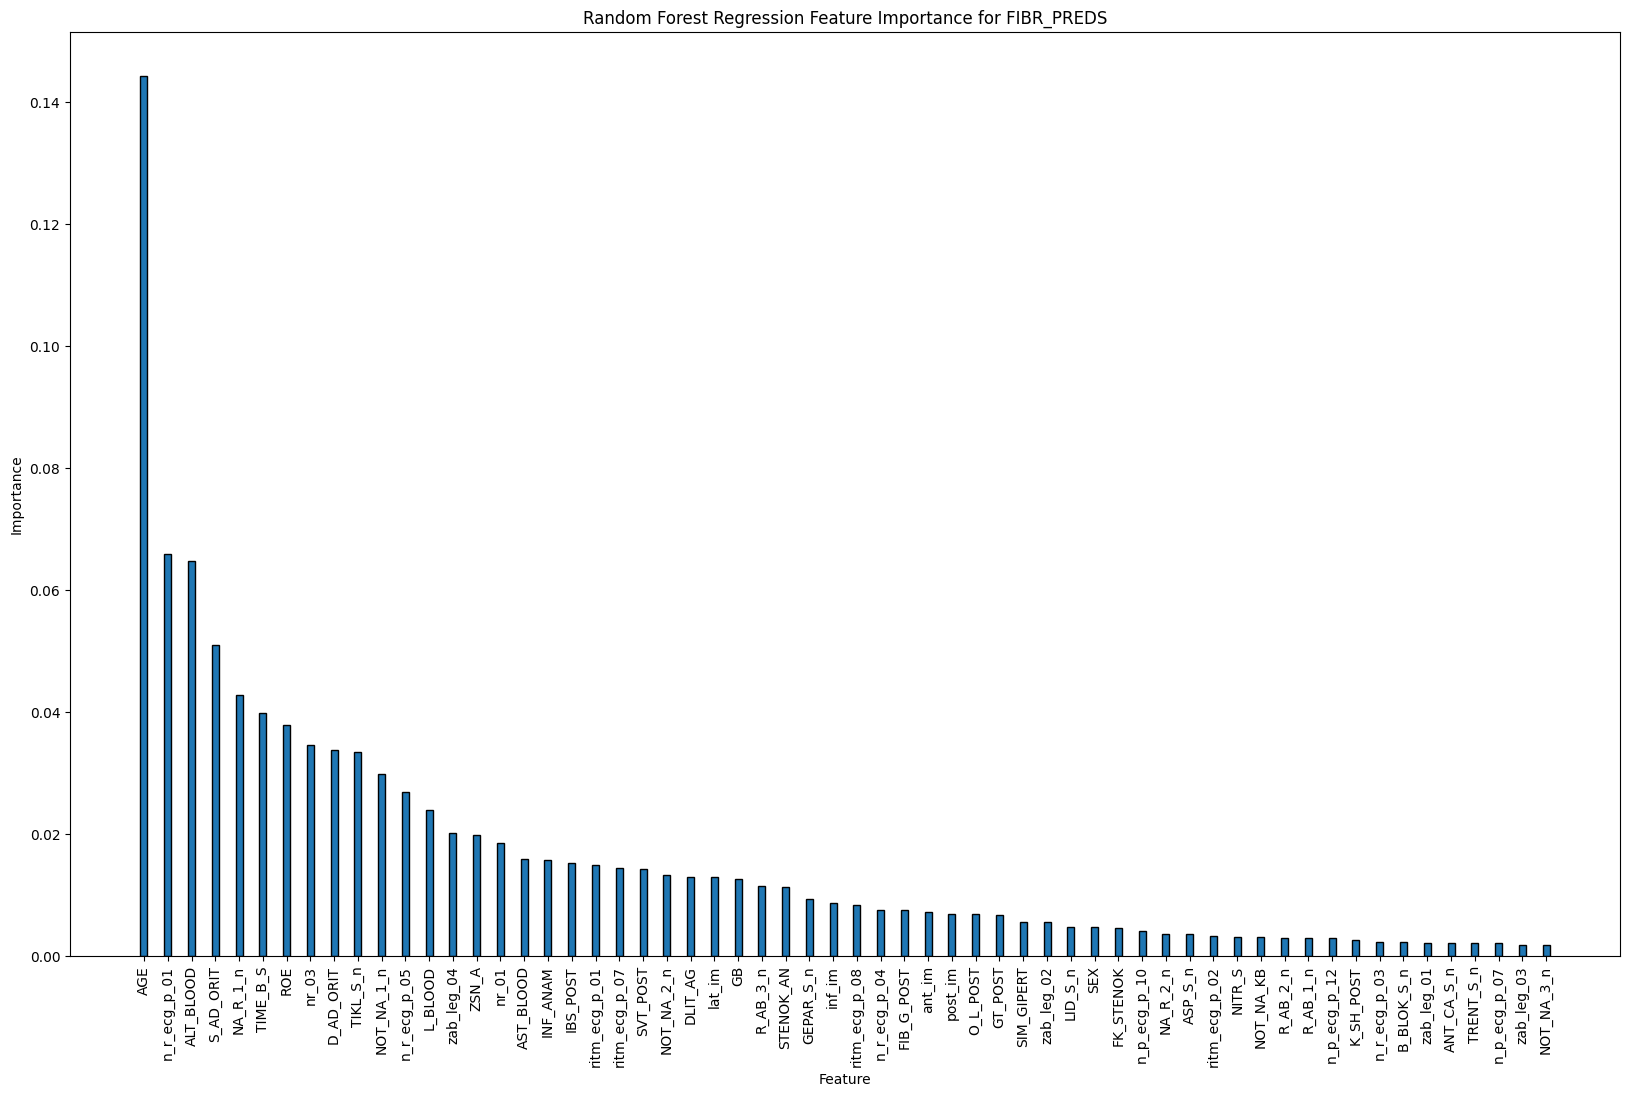

['AGE', 'n_r_ecg_p_01', 'ALT_BLOOD', 'S_AD_ORIT', 'NA_R_1_n', 'TIME_B_S', 'ROE', 'nr_03', 'D_AD_ORIT', 'TIKL_S_n', 'NOT_NA_1_n', 'n_r_ecg_p_05', 'L_BLOOD', 'zab_leg_04', 'ZSN_A', 'nr_01']


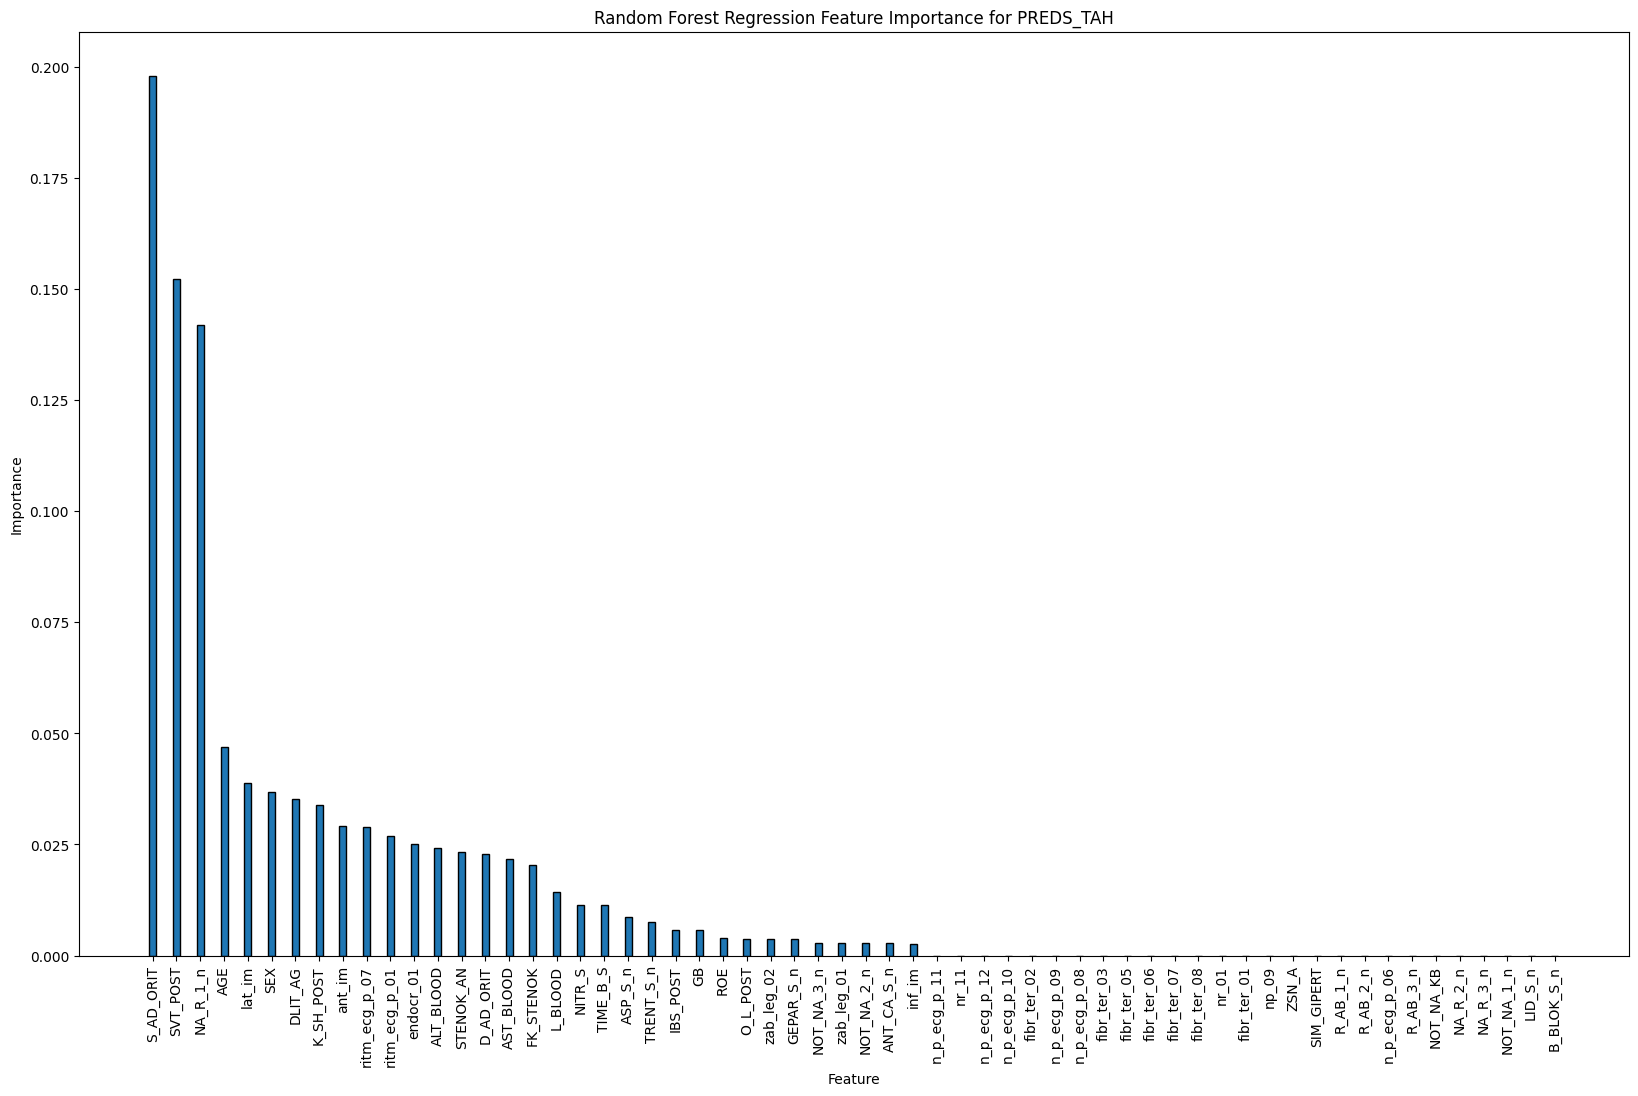

['S_AD_ORIT', 'SVT_POST', 'NA_R_1_n', 'AGE', 'lat_im', 'SEX', 'DLIT_AG', 'K_SH_POST']


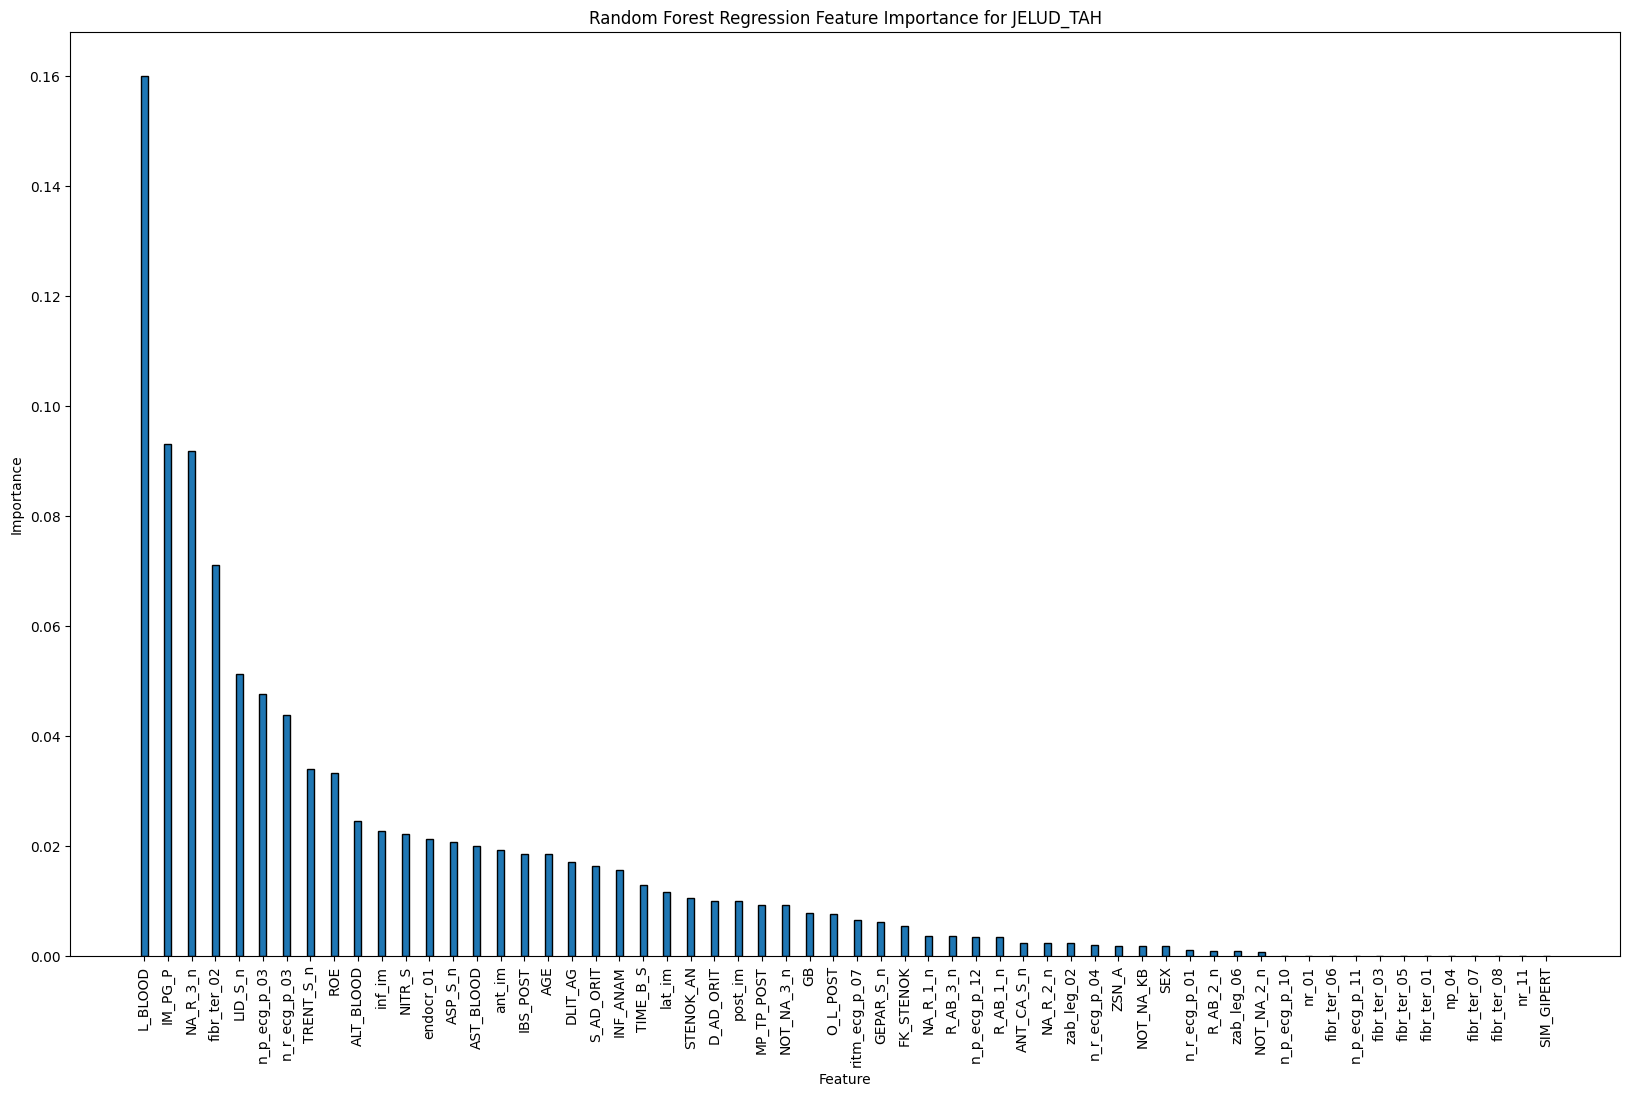

['L_BLOOD', 'IM_PG_P', 'NA_R_3_n', 'fibr_ter_02', 'LID_S_n', 'n_p_ecg_p_03', 'n_r_ecg_p_03', 'TRENT_S_n', 'ROE', 'ALT_BLOOD', 'inf_im', 'NITR_S', 'endocr_01', 'ASP_S_n', 'AST_BLOOD', 'ant_im', 'IBS_POST', 'AGE', 'DLIT_AG', 'S_AD_ORIT', 'INF_ANAM', 'TIME_B_S', 'lat_im', 'STENOK_AN', 'D_AD_ORIT', 'post_im', 'MP_TP_POST', 'NOT_NA_3_n', 'GB', 'O_L_POST']


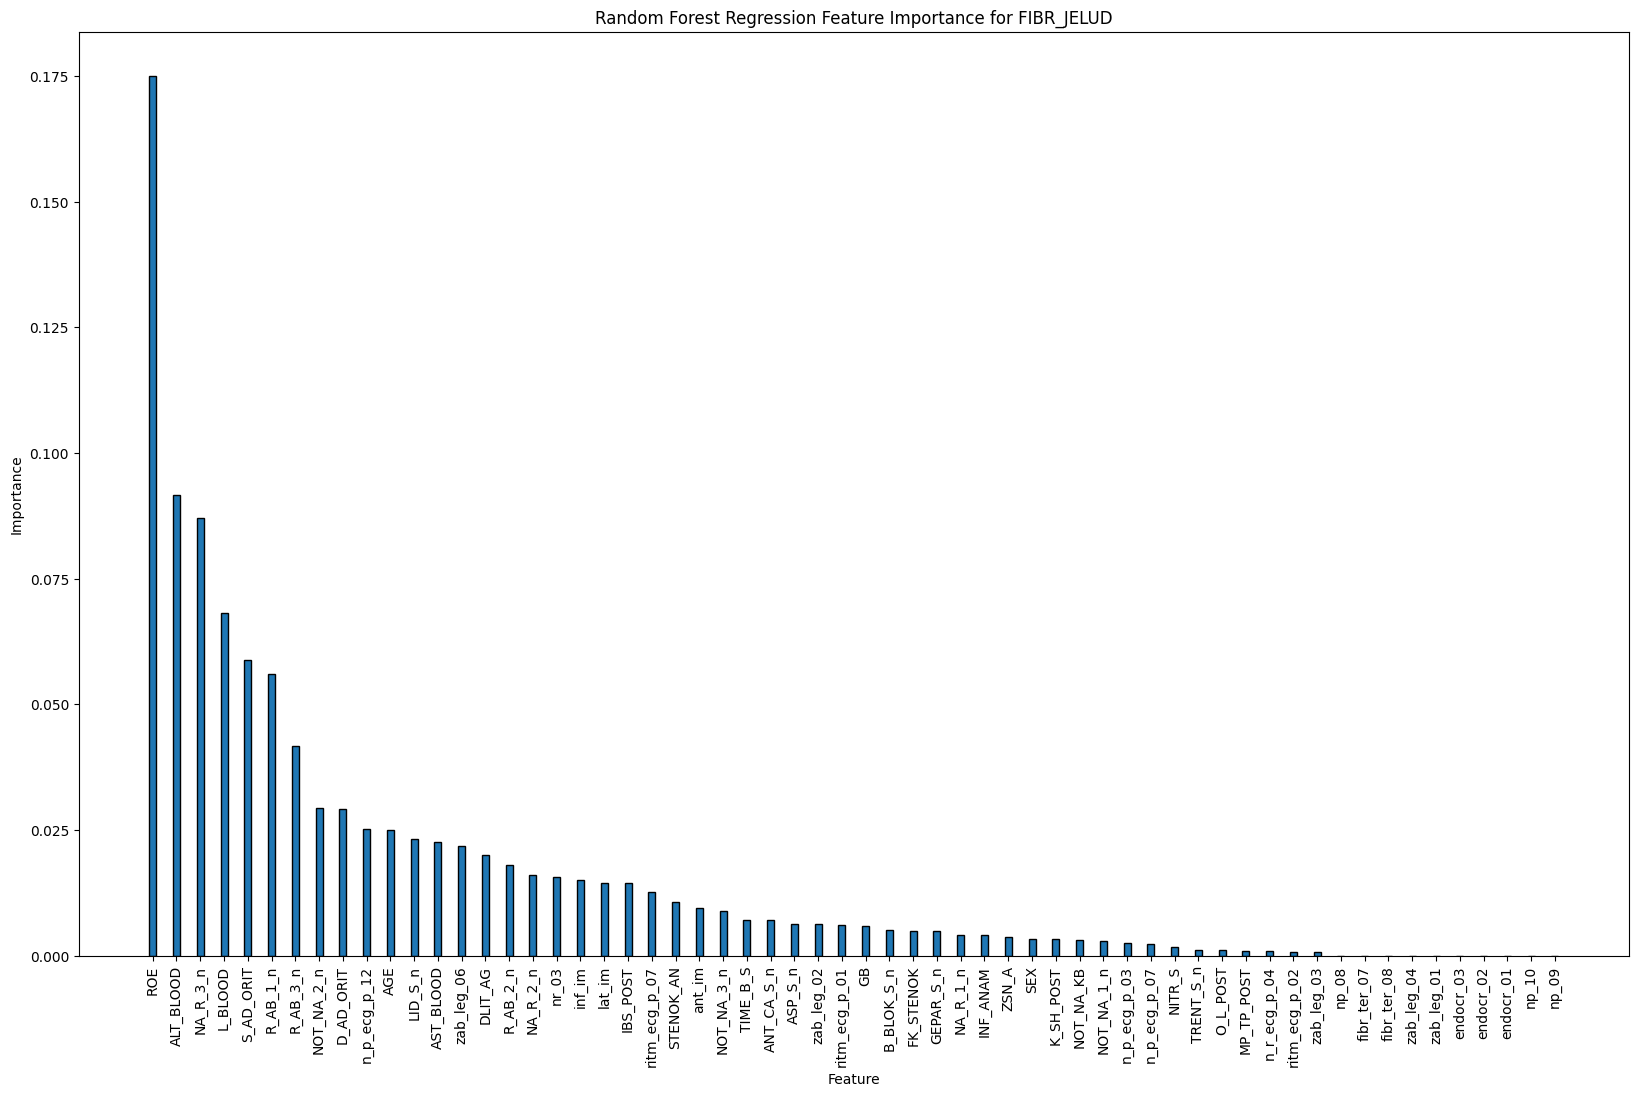

['ROE', 'ALT_BLOOD', 'NA_R_3_n', 'L_BLOOD', 'S_AD_ORIT', 'R_AB_1_n', 'R_AB_3_n', 'NOT_NA_2_n', 'D_AD_ORIT', 'n_p_ecg_p_12', 'AGE', 'LID_S_n', 'AST_BLOOD', 'zab_leg_06', 'DLIT_AG', 'R_AB_2_n', 'NA_R_2_n']


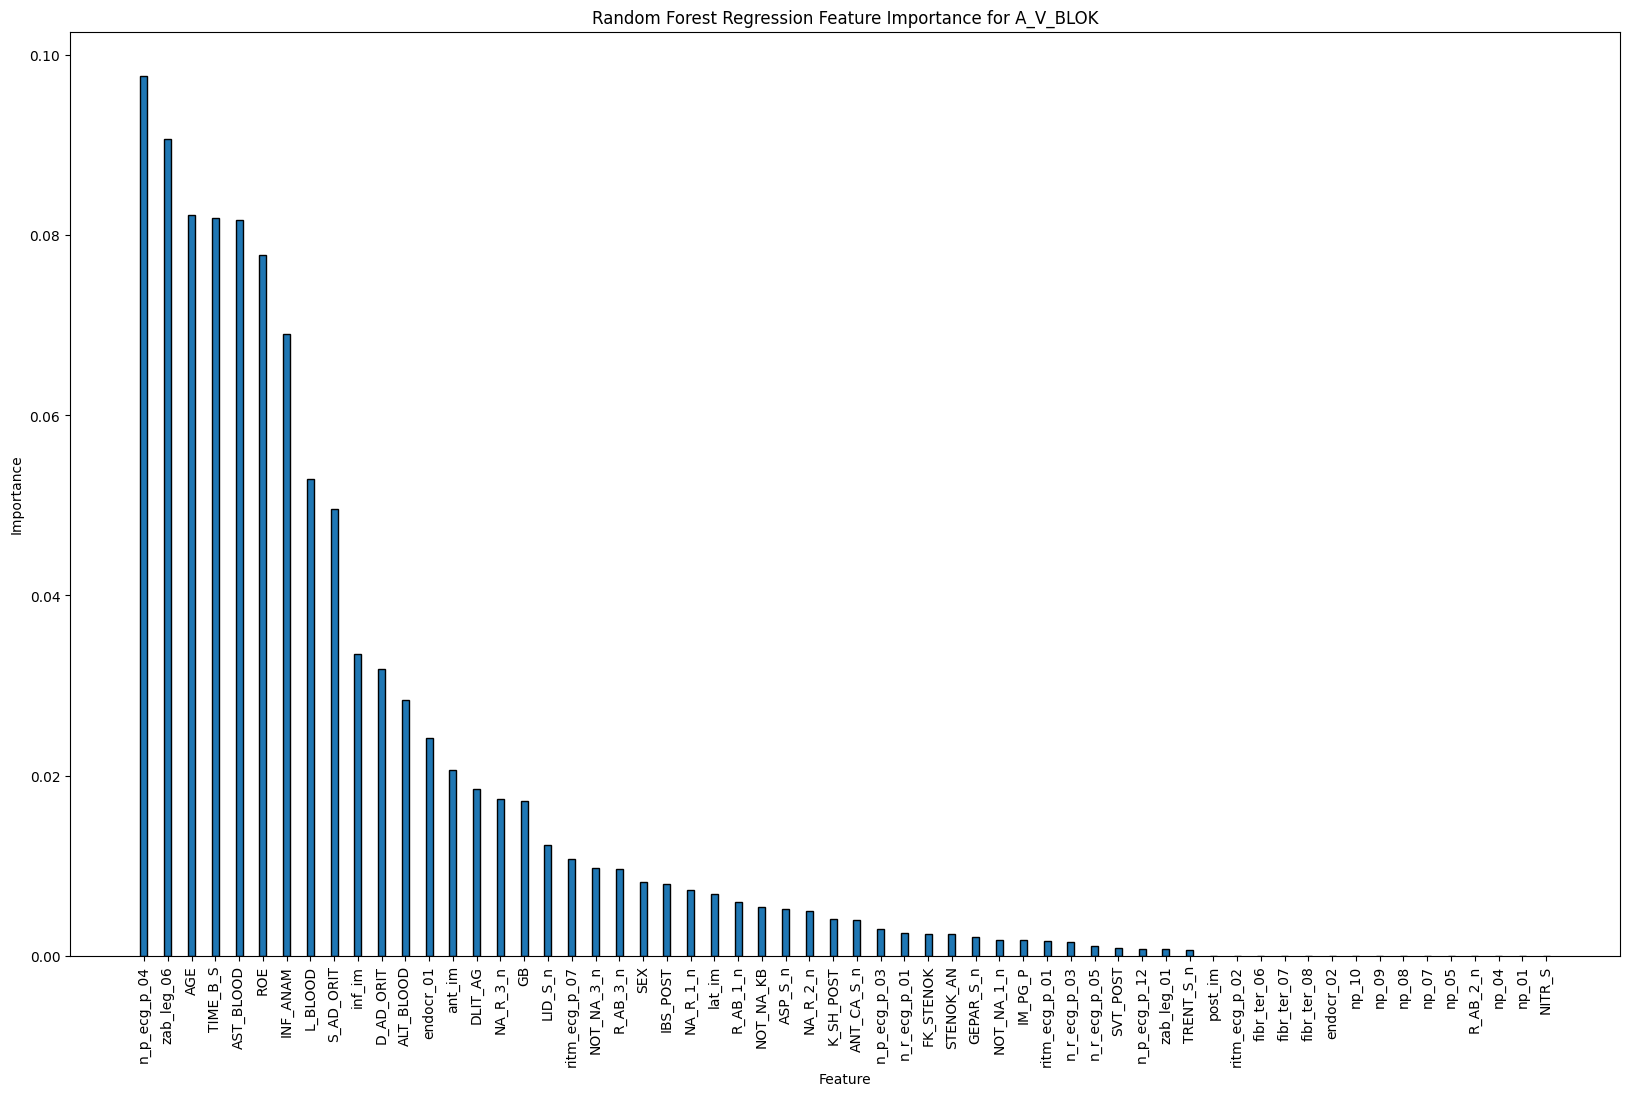

['n_p_ecg_p_04', 'zab_leg_06', 'AGE', 'TIME_B_S', 'AST_BLOOD', 'ROE', 'INF_ANAM', 'L_BLOOD', 'S_AD_ORIT', 'inf_im', 'D_AD_ORIT', 'ALT_BLOOD', 'endocr_01', 'ant_im', 'DLIT_AG', 'NA_R_3_n', 'GB']


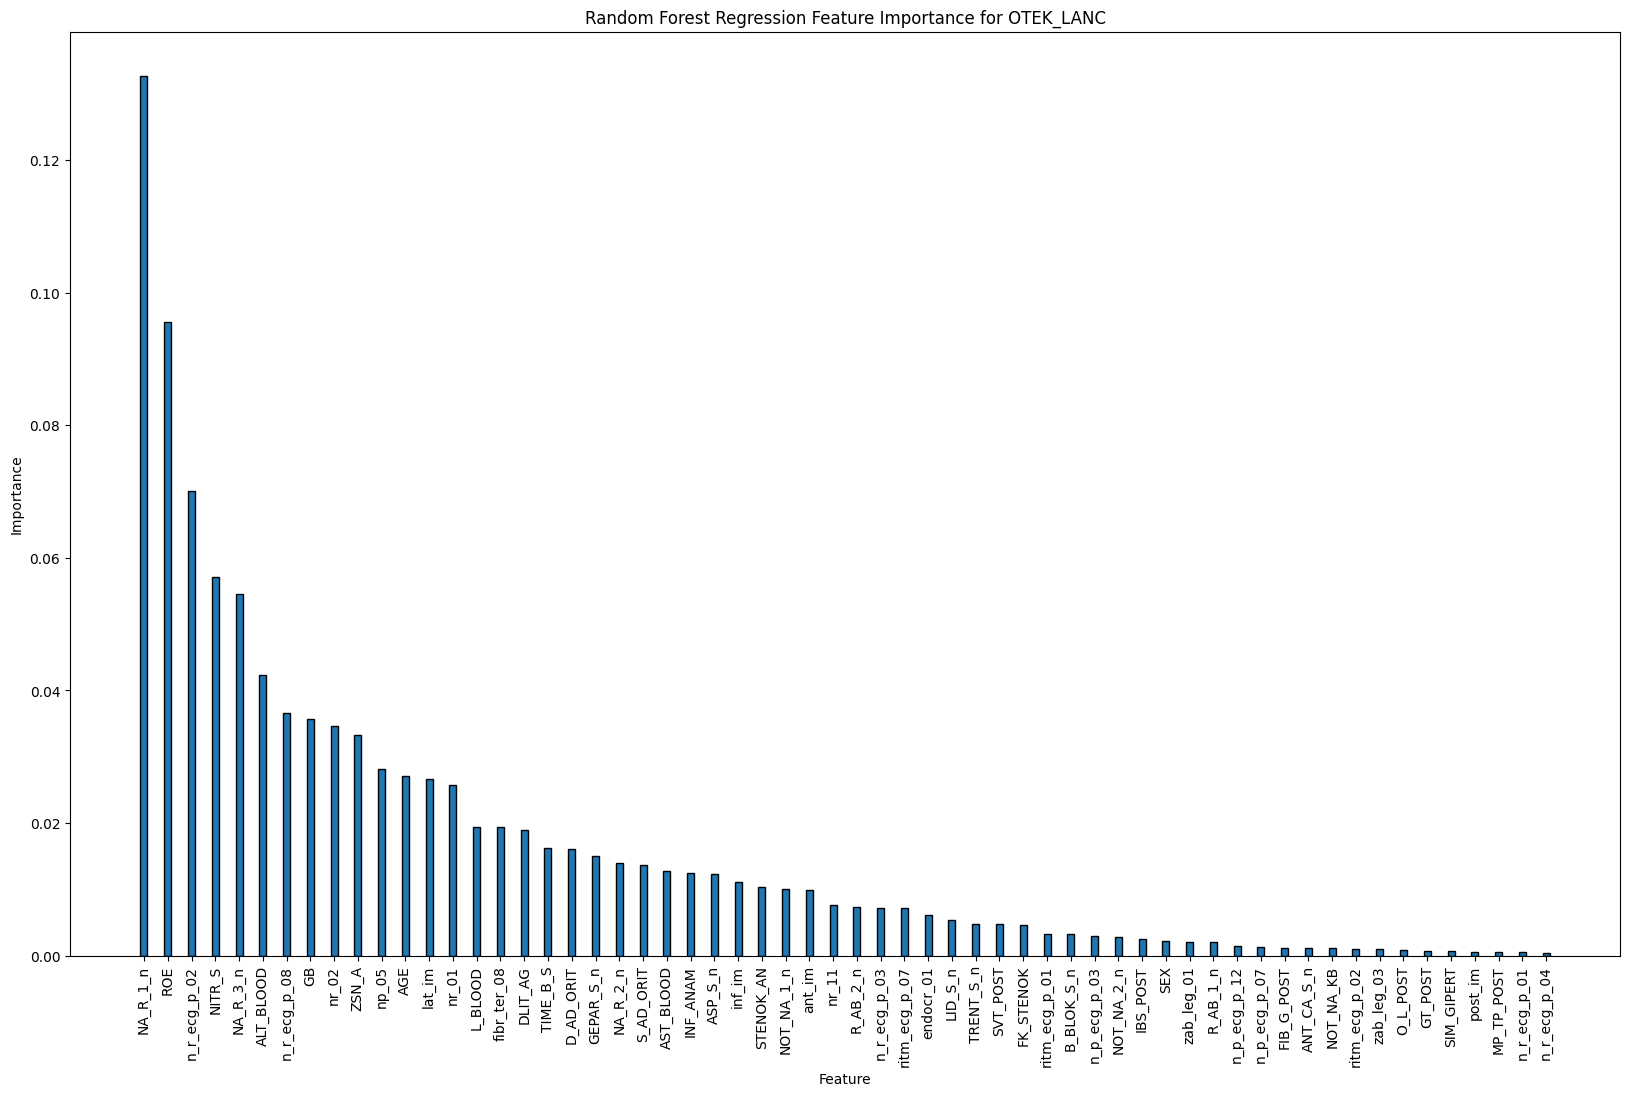

['NA_R_1_n', 'ROE', 'n_r_ecg_p_02', 'NITR_S', 'NA_R_3_n', 'ALT_BLOOD', 'n_r_ecg_p_08', 'GB', 'nr_02', 'ZSN_A', 'np_05', 'AGE', 'lat_im', 'nr_01', 'L_BLOOD', 'fibr_ter_08', 'DLIT_AG']


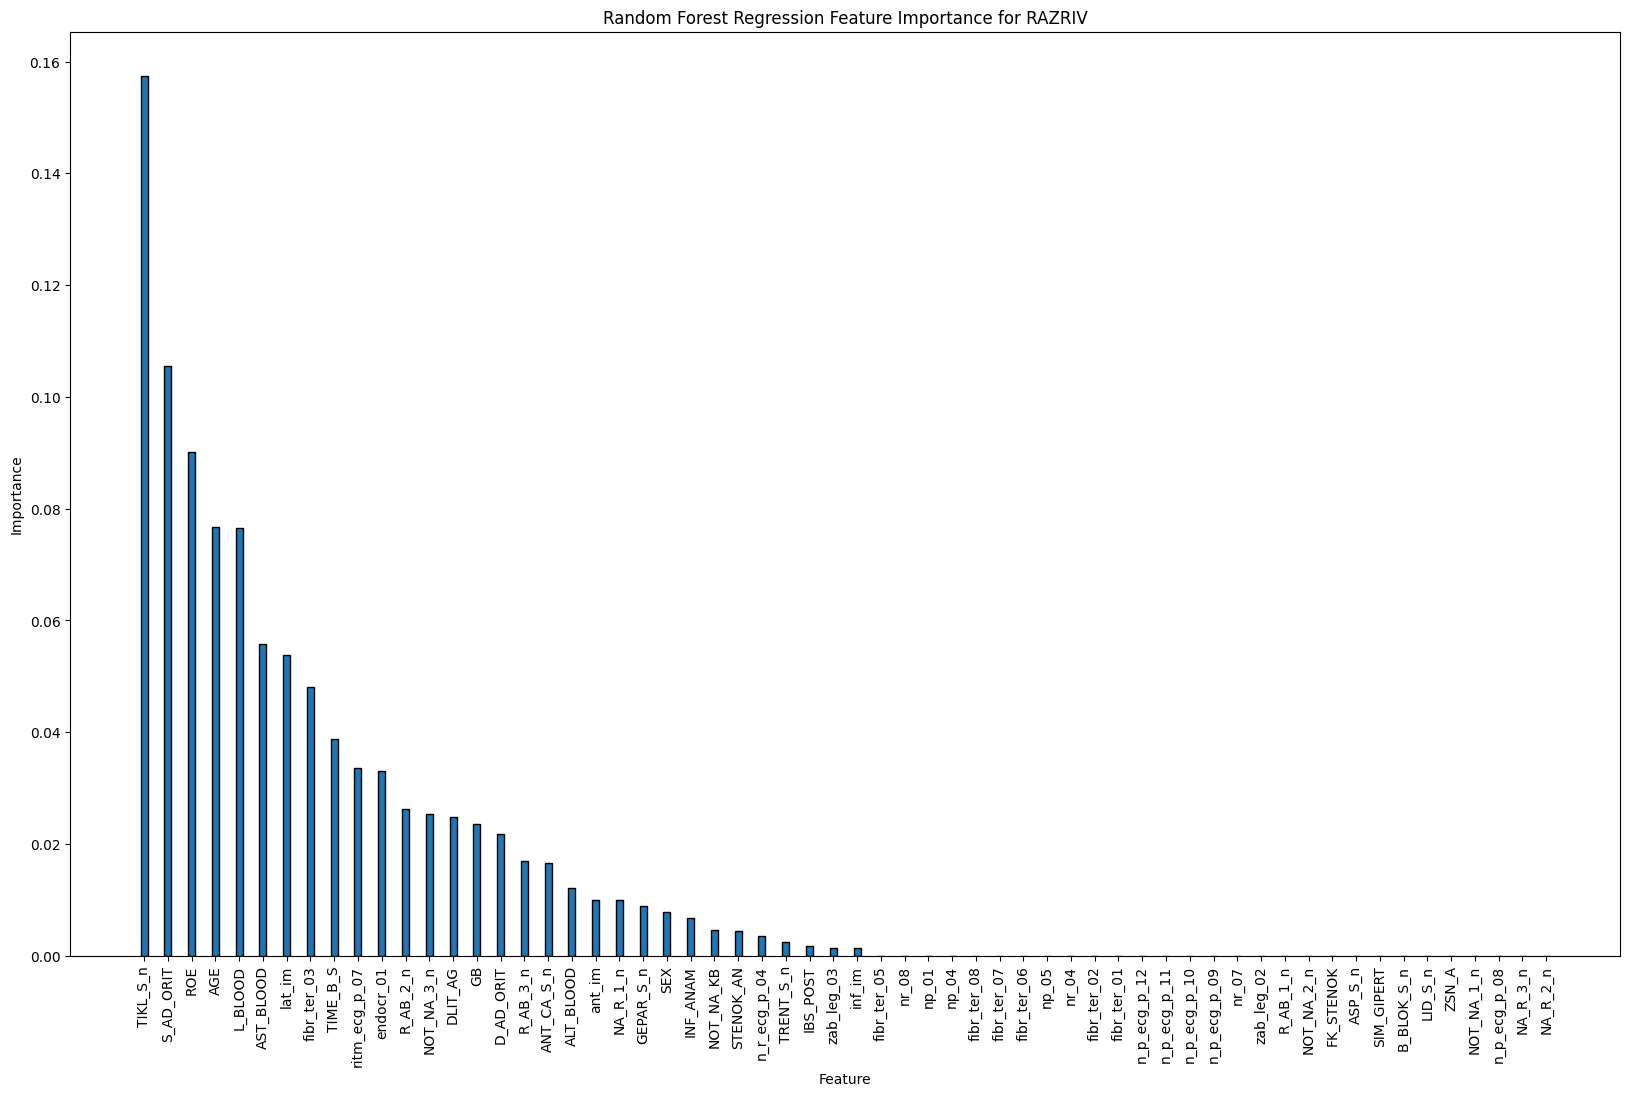

['TIKL_S_n', 'S_AD_ORIT', 'ROE', 'AGE', 'L_BLOOD', 'AST_BLOOD', 'lat_im', 'fibr_ter_03', 'TIME_B_S', 'ritm_ecg_p_07']


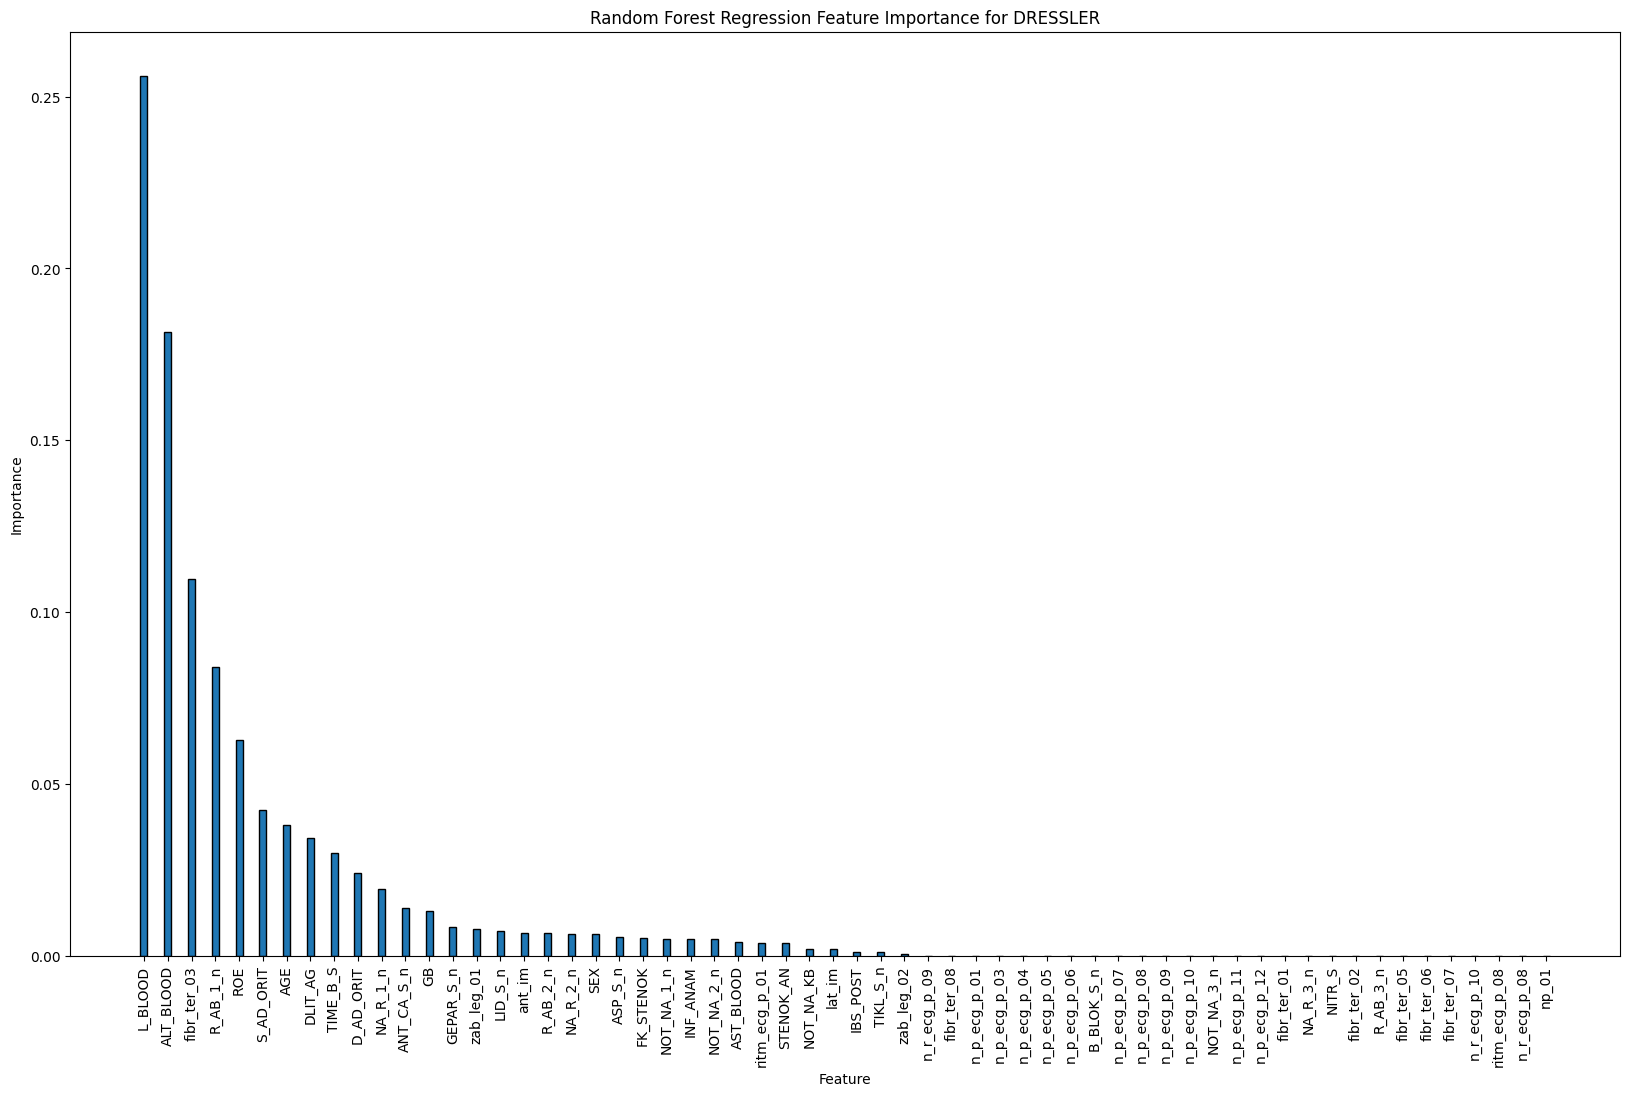

['L_BLOOD', 'ALT_BLOOD', 'fibr_ter_03', 'R_AB_1_n', 'ROE', 'S_AD_ORIT', 'AGE', 'DLIT_AG', 'TIME_B_S', 'D_AD_ORIT', 'NA_R_1_n', 'ANT_CA_S_n', 'GB']


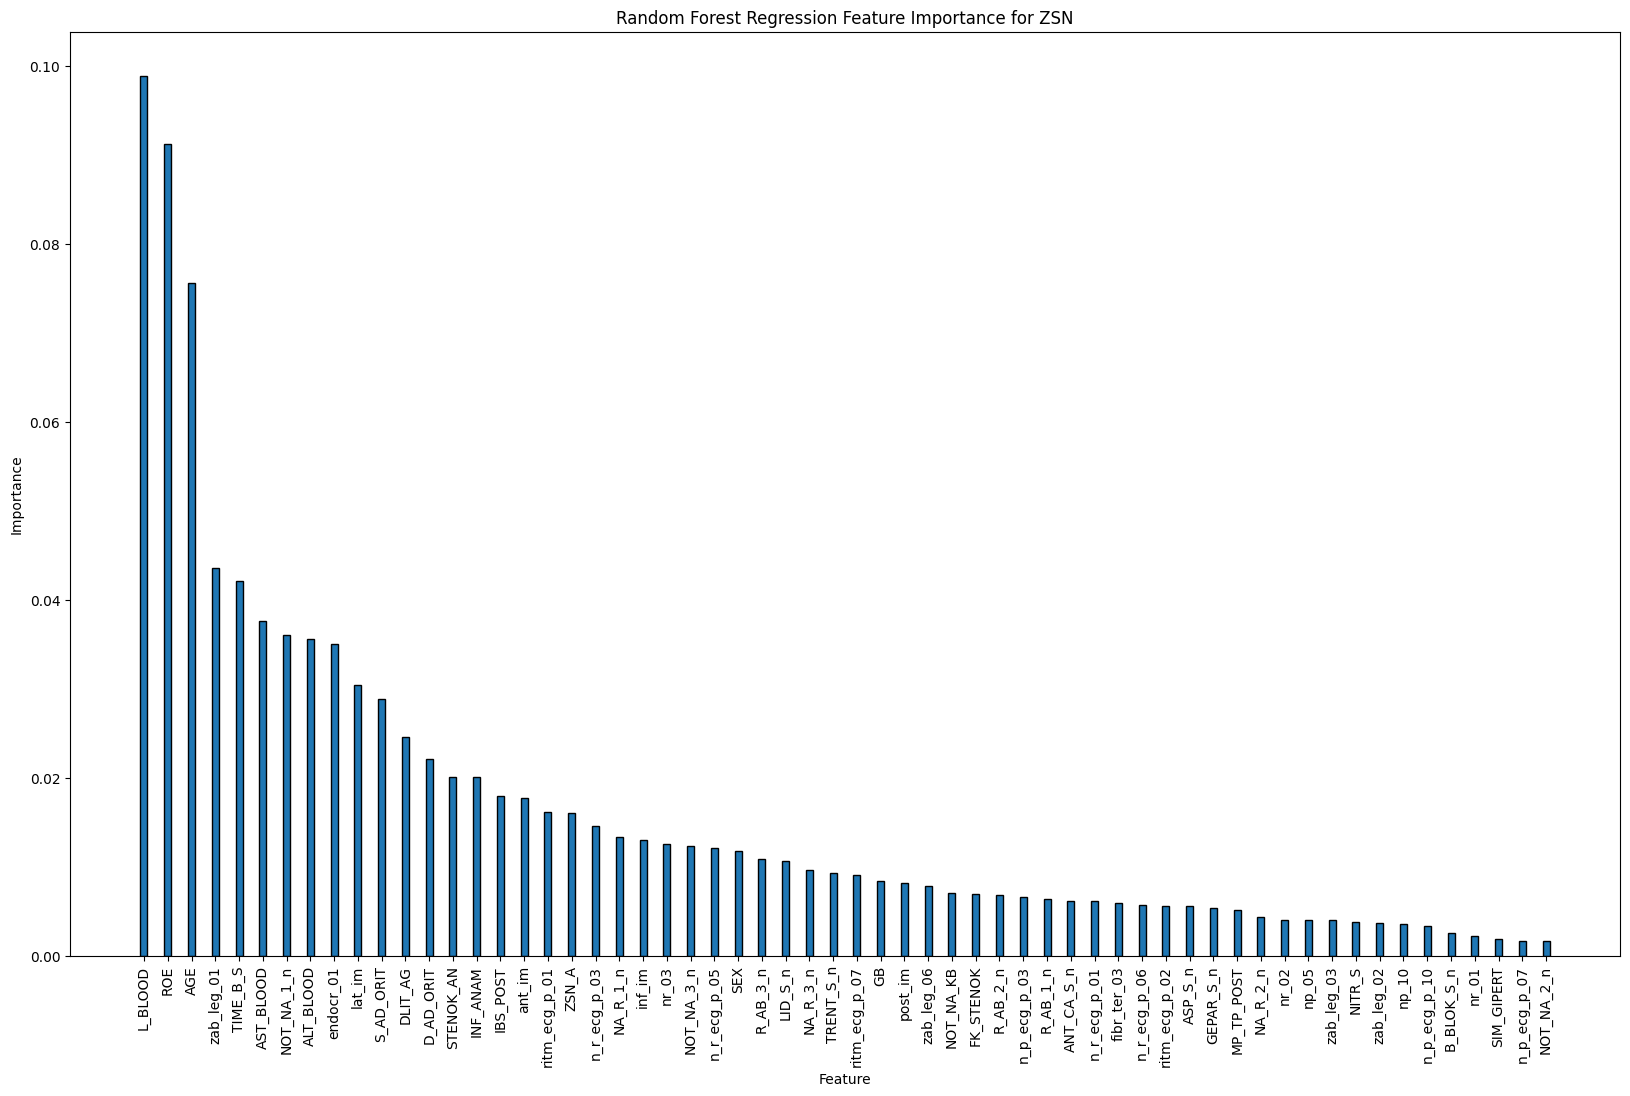

['L_BLOOD', 'ROE', 'AGE', 'zab_leg_01', 'TIME_B_S', 'AST_BLOOD', 'NOT_NA_1_n', 'ALT_BLOOD', 'endocr_01', 'lat_im', 'S_AD_ORIT', 'DLIT_AG', 'D_AD_ORIT', 'STENOK_AN', 'INF_ANAM', 'IBS_POST', 'ant_im', 'ritm_ecg_p_01', 'ZSN_A', 'n_r_ecg_p_03', 'NA_R_1_n', 'inf_im', 'nr_03', 'NOT_NA_3_n', 'n_r_ecg_p_05', 'SEX', 'R_AB_3_n', 'LID_S_n', 'NA_R_3_n', 'TRENT_S_n', 'ritm_ecg_p_07', 'GB', 'post_im', 'zab_leg_06', 'NOT_NA_KB', 'FK_STENOK']


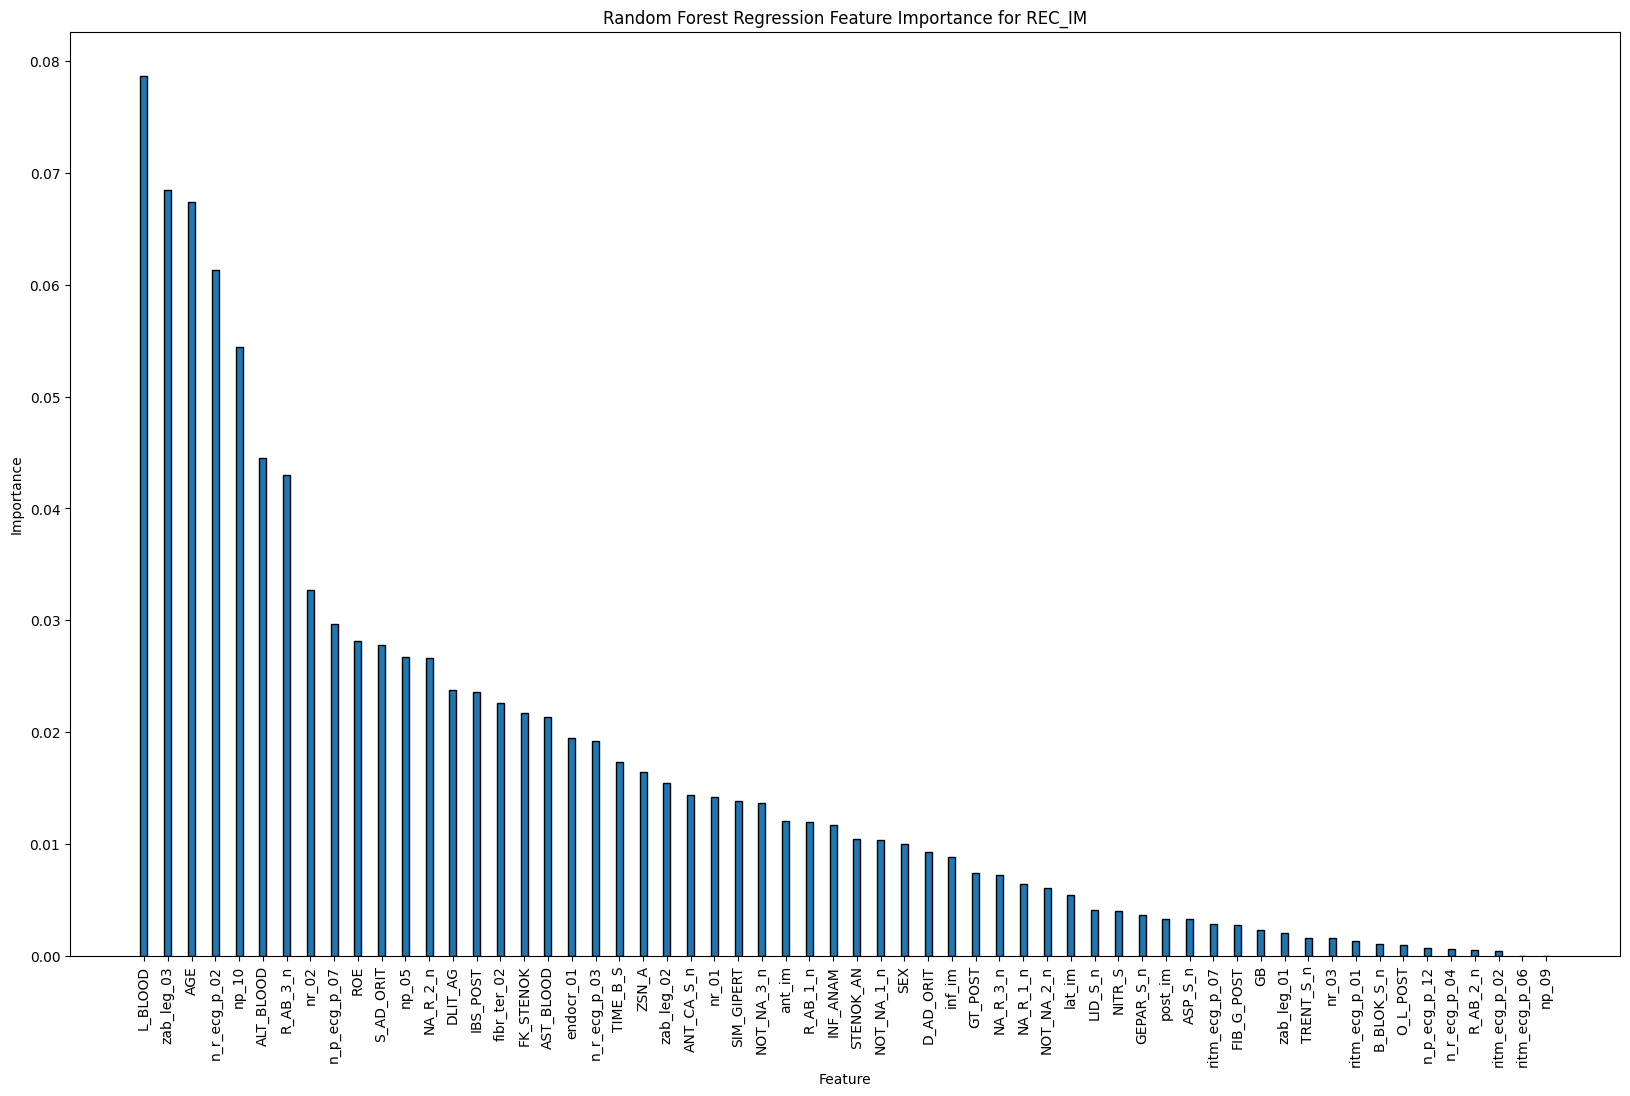

['L_BLOOD', 'zab_leg_03', 'AGE', 'n_r_ecg_p_02', 'np_10', 'ALT_BLOOD', 'R_AB_3_n', 'nr_02', 'n_p_ecg_p_07', 'ROE', 'S_AD_ORIT', 'np_05', 'NA_R_2_n', 'DLIT_AG', 'IBS_POST', 'fibr_ter_02', 'FK_STENOK', 'AST_BLOOD', 'endocr_01', 'n_r_ecg_p_03', 'TIME_B_S', 'ZSN_A', 'zab_leg_02', 'ANT_CA_S_n', 'nr_01', 'SIM_GIPERT', 'NOT_NA_3_n']


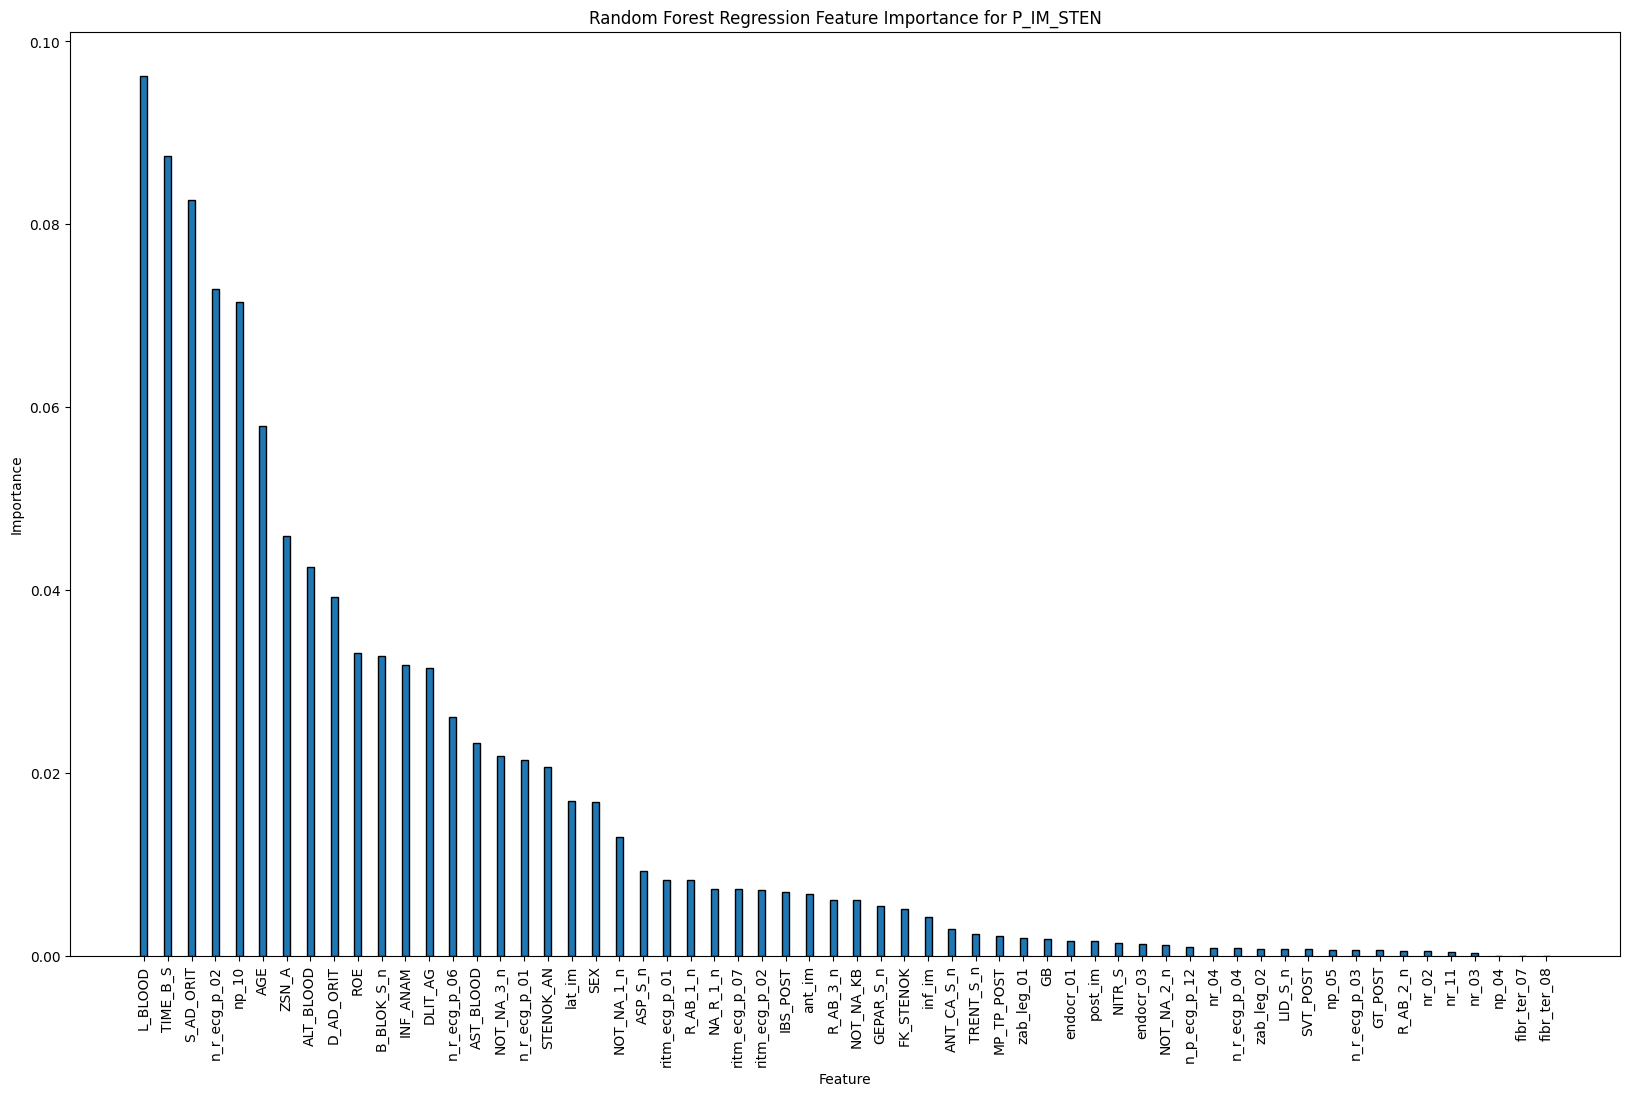

['L_BLOOD', 'TIME_B_S', 'S_AD_ORIT', 'n_r_ecg_p_02', 'np_10', 'AGE', 'ZSN_A', 'ALT_BLOOD', 'D_AD_ORIT', 'ROE', 'B_BLOK_S_n', 'INF_ANAM', 'DLIT_AG', 'n_r_ecg_p_06', 'AST_BLOOD', 'NOT_NA_3_n', 'n_r_ecg_p_01', 'STENOK_AN', 'lat_im', 'SEX']


In [12]:
# single imputation
# this dictionary stores the list of features used for each complication
single_complication_features_dict = {}

# this dictionary was manually put together after seeing each graph and using the elbow method, it lists the lowest feature used
single_stop_features_dict = {
    'FIBR_PREDS':'nr_01',
    'PREDS_TAH':'K_SH_POST',
    'JELUD_TAH':'O_L_POST',
    'FIBR_JELUD':'NA_R_2_n',
    'A_V_BLOK':'GB',
    'OTEK_LANC':'DLIT_AG',
    'RAZRIV':'ritm_ecg_p_07',
    'DRESSLER':'GB',
    'ZSN':'FK_STENOK',
    'REC_IM':'NOT_NA_3_n',
    'P_IM_STEN':'SEX'
}

for complication in complications:
    single_tune = scaled_single_datasets['tune']
    single_feature_importance = feature_selection_graph(single_tune, complication)
    # print(single_feature_importance)
    single_features_selected = select_up_to_stop_feature(single_feature_importance, single_stop_features_dict[complication])
    print(single_features_selected)
    single_complication_features_dict[complication] = single_features_selected

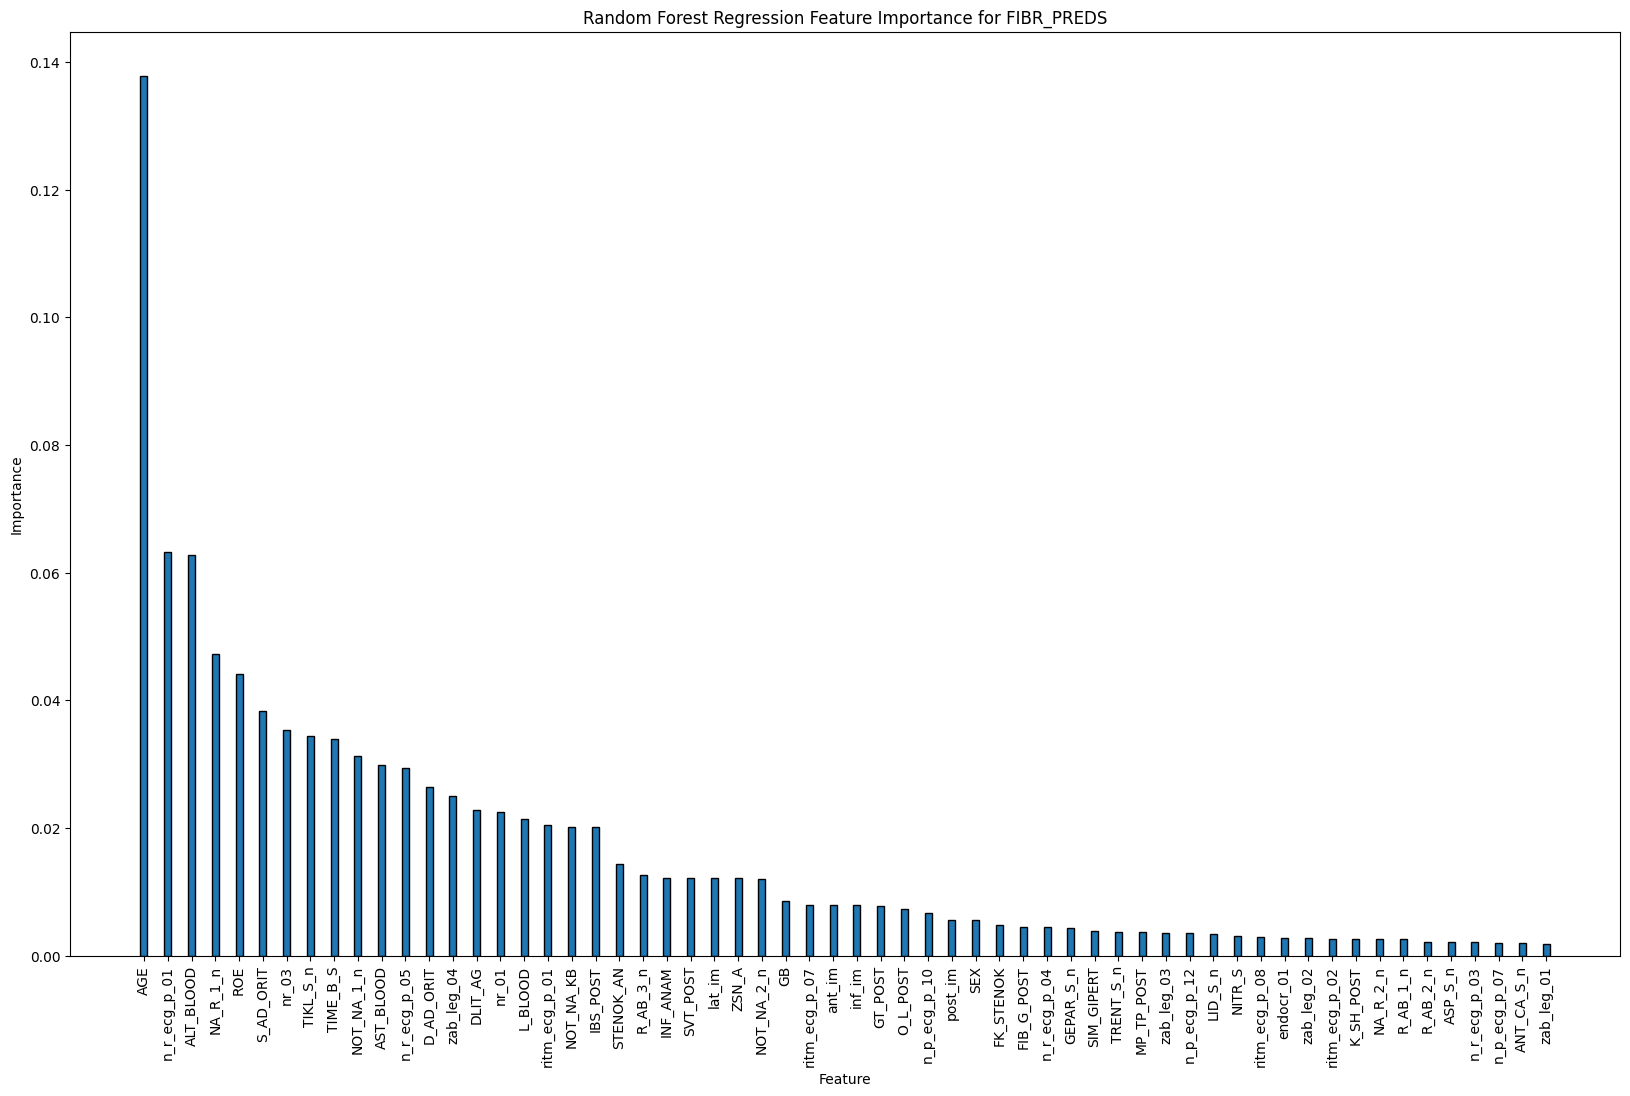

['AGE', 'n_r_ecg_p_01', 'ALT_BLOOD', 'NA_R_1_n', 'ROE', 'S_AD_ORIT', 'nr_03', 'TIKL_S_n', 'TIME_B_S', 'NOT_NA_1_n', 'AST_BLOOD', 'n_r_ecg_p_05', 'D_AD_ORIT', 'zab_leg_04', 'DLIT_AG', 'nr_01', 'L_BLOOD', 'ritm_ecg_p_01', 'NOT_NA_KB', 'IBS_POST']


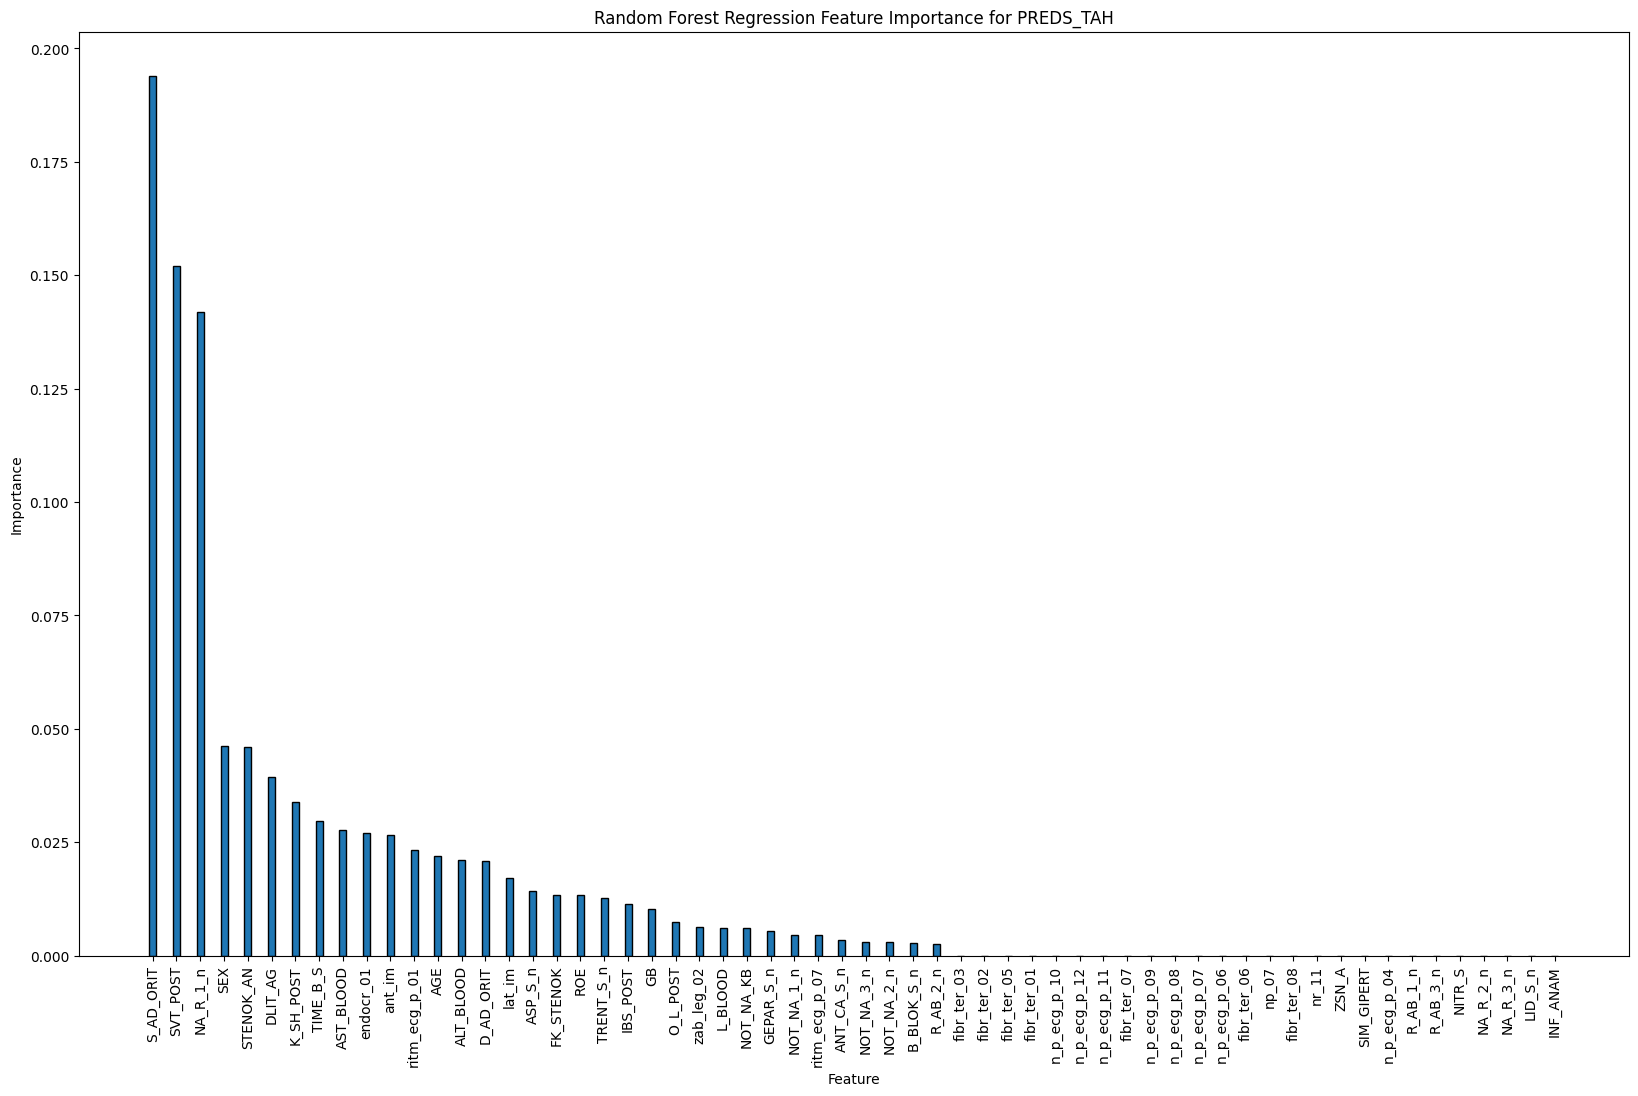

['S_AD_ORIT', 'SVT_POST', 'NA_R_1_n', 'SEX', 'STENOK_AN', 'DLIT_AG', 'K_SH_POST', 'TIME_B_S', 'AST_BLOOD', 'endocr_01', 'ant_im', 'ritm_ecg_p_01', 'AGE', 'ALT_BLOOD', 'D_AD_ORIT', 'lat_im', 'ASP_S_n', 'FK_STENOK', 'ROE', 'TRENT_S_n', 'IBS_POST', 'GB']


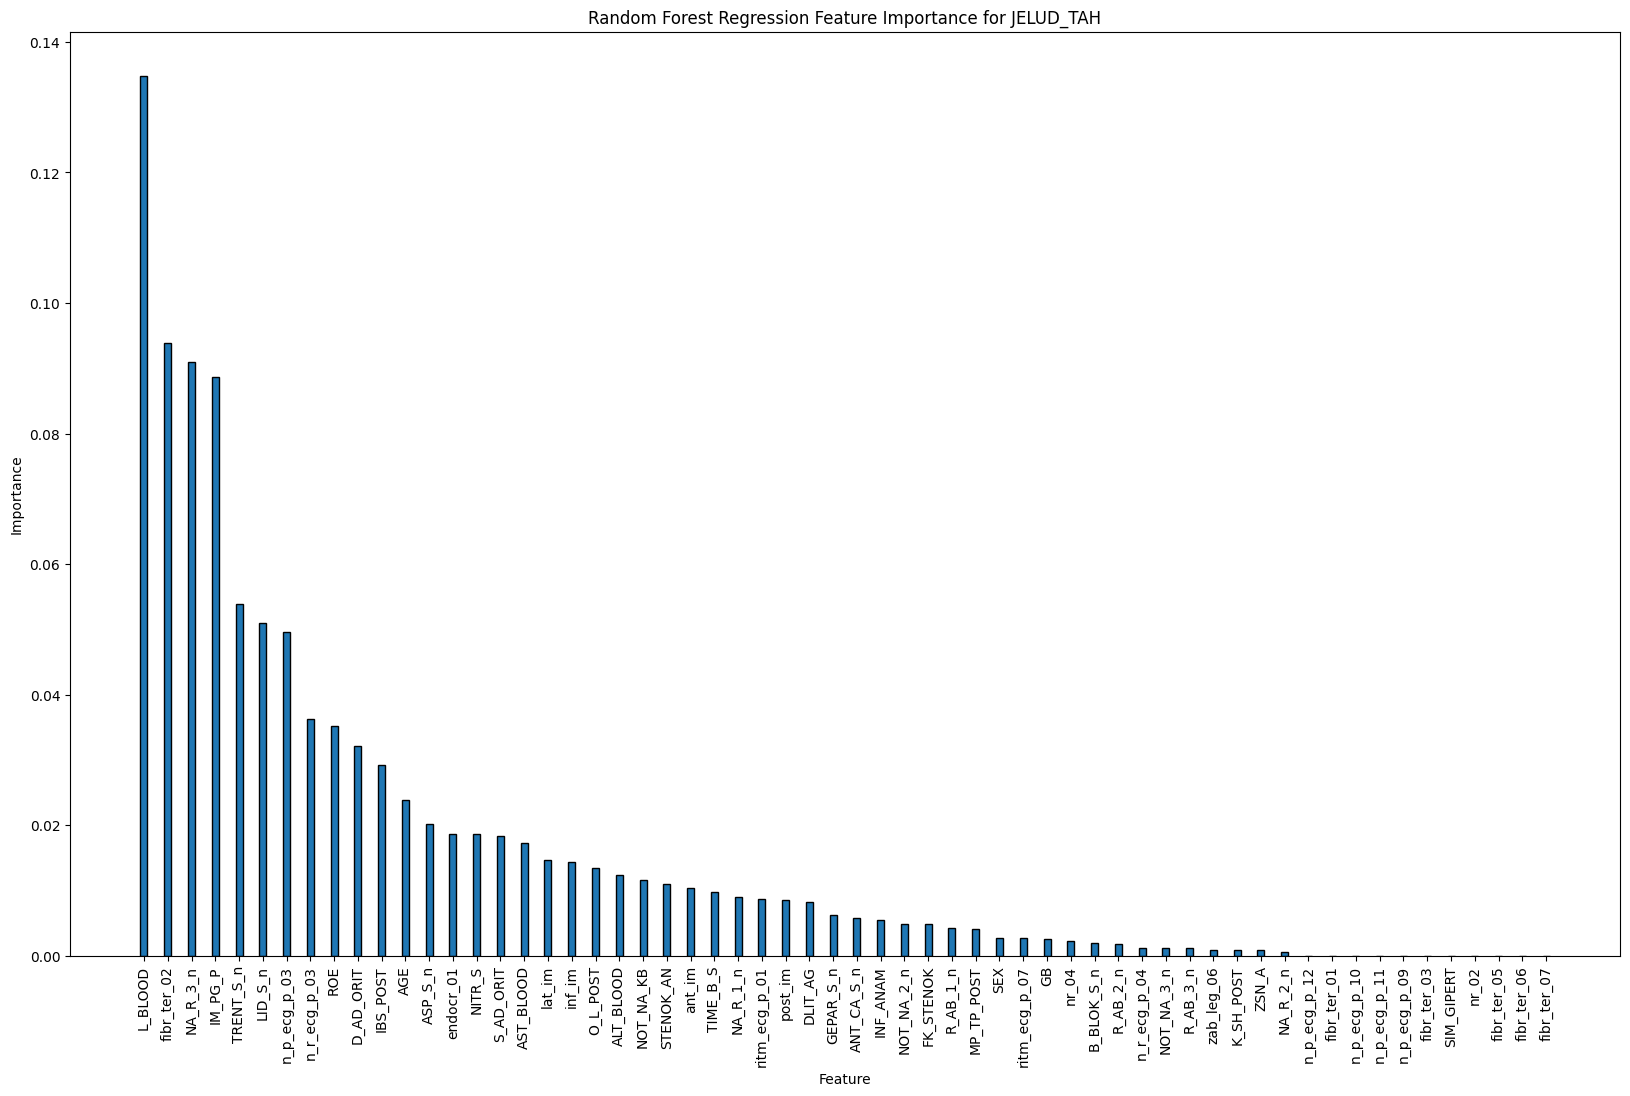

['L_BLOOD', 'fibr_ter_02', 'NA_R_3_n', 'IM_PG_P', 'TRENT_S_n', 'LID_S_n', 'n_p_ecg_p_03', 'n_r_ecg_p_03', 'ROE', 'D_AD_ORIT', 'IBS_POST', 'AGE', 'ASP_S_n', 'endocr_01', 'NITR_S', 'S_AD_ORIT', 'AST_BLOOD']


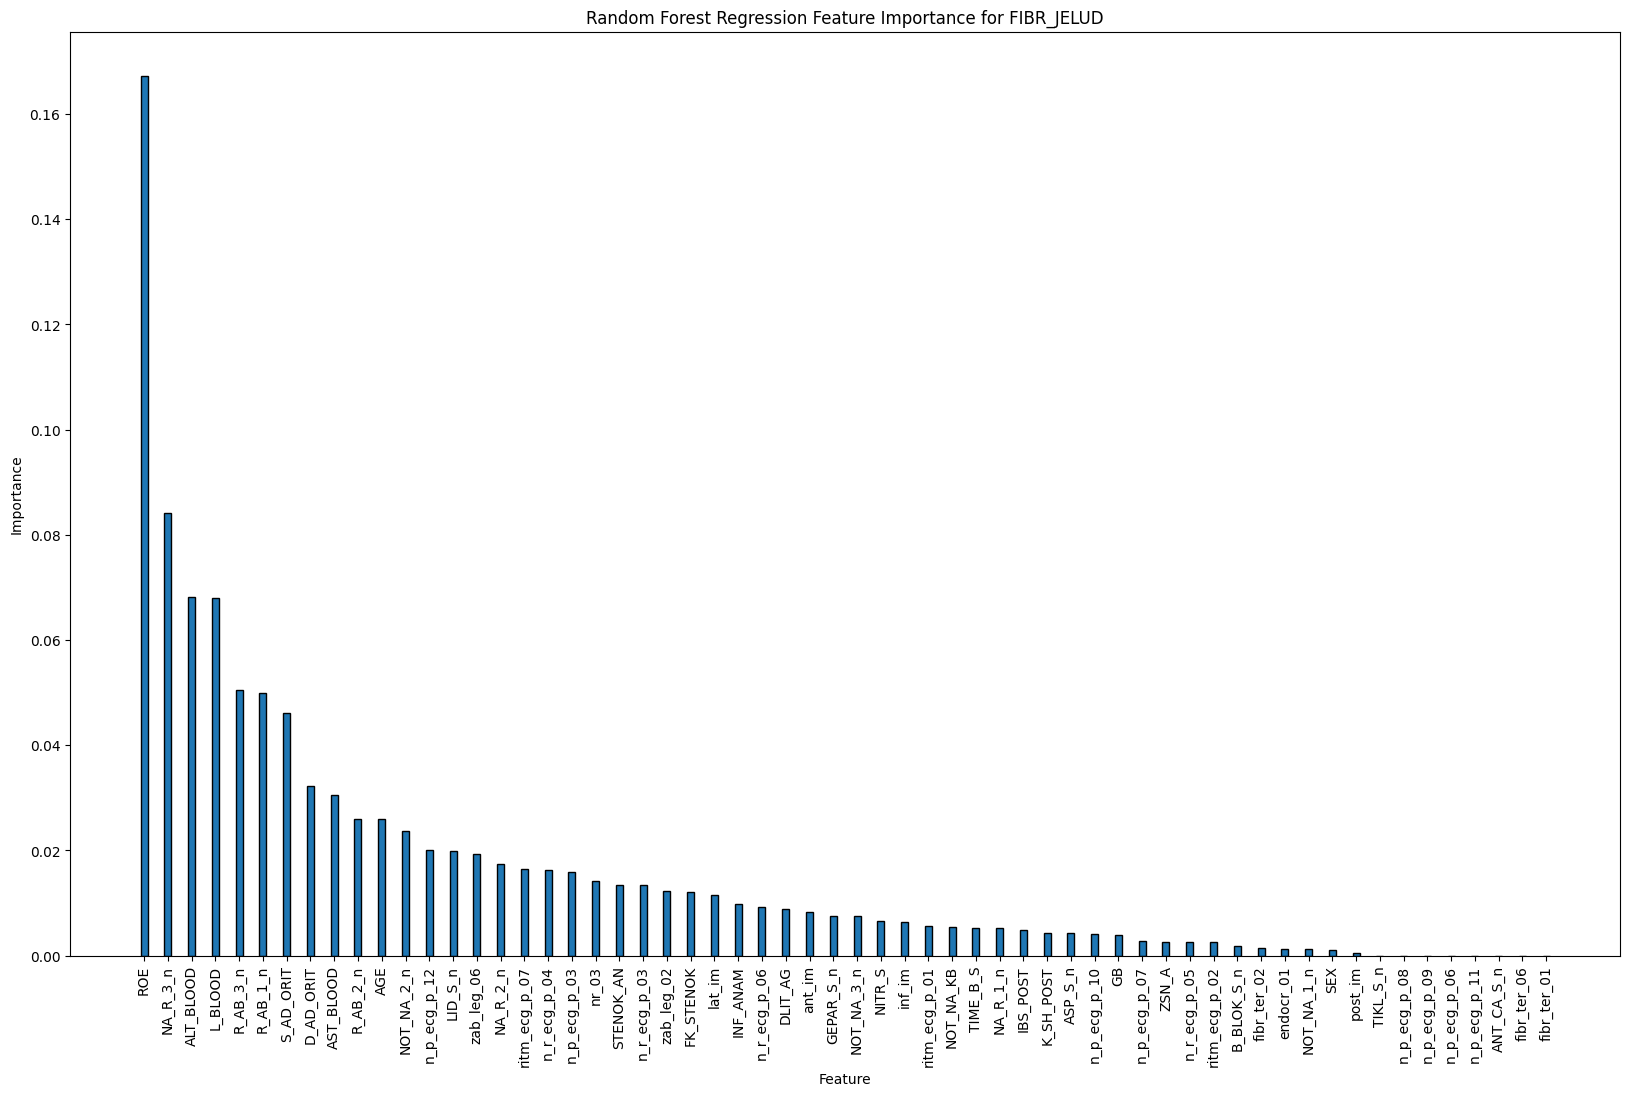

['ROE', 'NA_R_3_n', 'ALT_BLOOD', 'L_BLOOD', 'R_AB_3_n', 'R_AB_1_n', 'S_AD_ORIT', 'D_AD_ORIT', 'AST_BLOOD', 'R_AB_2_n', 'AGE', 'NOT_NA_2_n', 'n_p_ecg_p_12', 'LID_S_n', 'zab_leg_06', 'NA_R_2_n', 'ritm_ecg_p_07', 'n_r_ecg_p_04']


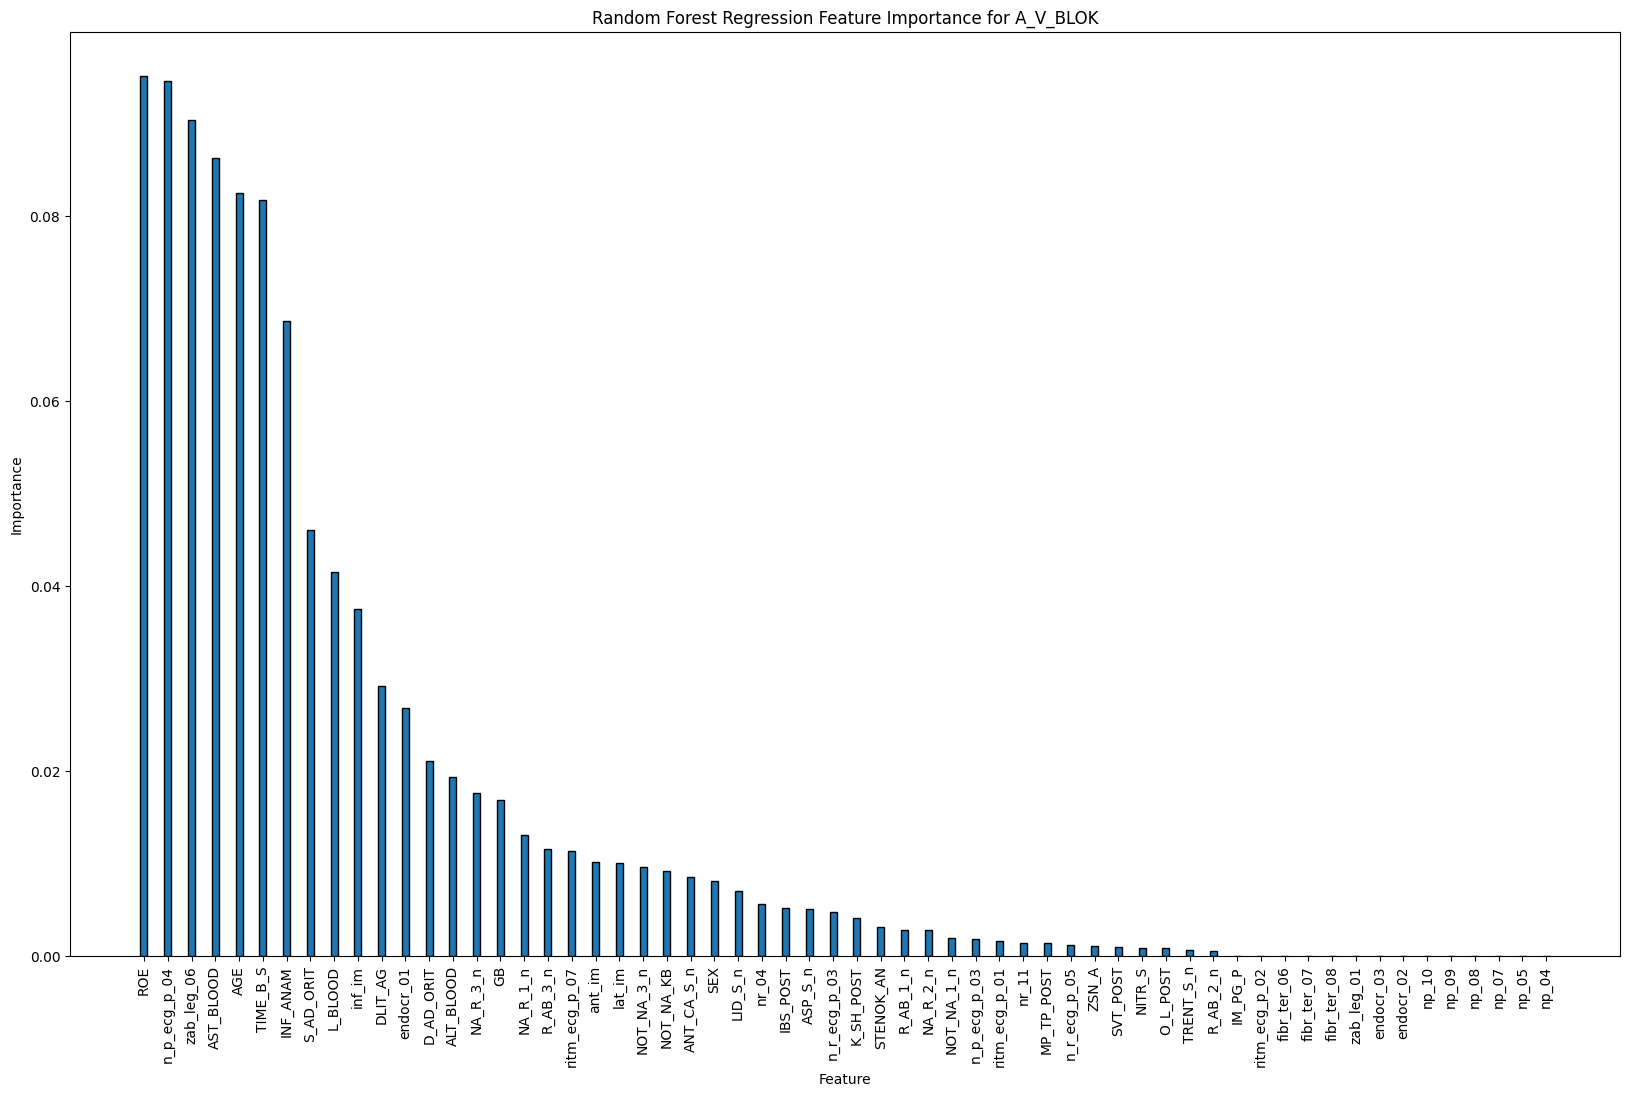

['ROE', 'n_p_ecg_p_04', 'zab_leg_06', 'AST_BLOOD', 'AGE', 'TIME_B_S', 'INF_ANAM', 'S_AD_ORIT', 'L_BLOOD', 'inf_im', 'DLIT_AG', 'endocr_01', 'D_AD_ORIT', 'ALT_BLOOD', 'NA_R_3_n', 'GB', 'NA_R_1_n', 'R_AB_3_n', 'ritm_ecg_p_07', 'ant_im', 'lat_im', 'NOT_NA_3_n', 'NOT_NA_KB', 'ANT_CA_S_n', 'SEX', 'LID_S_n']


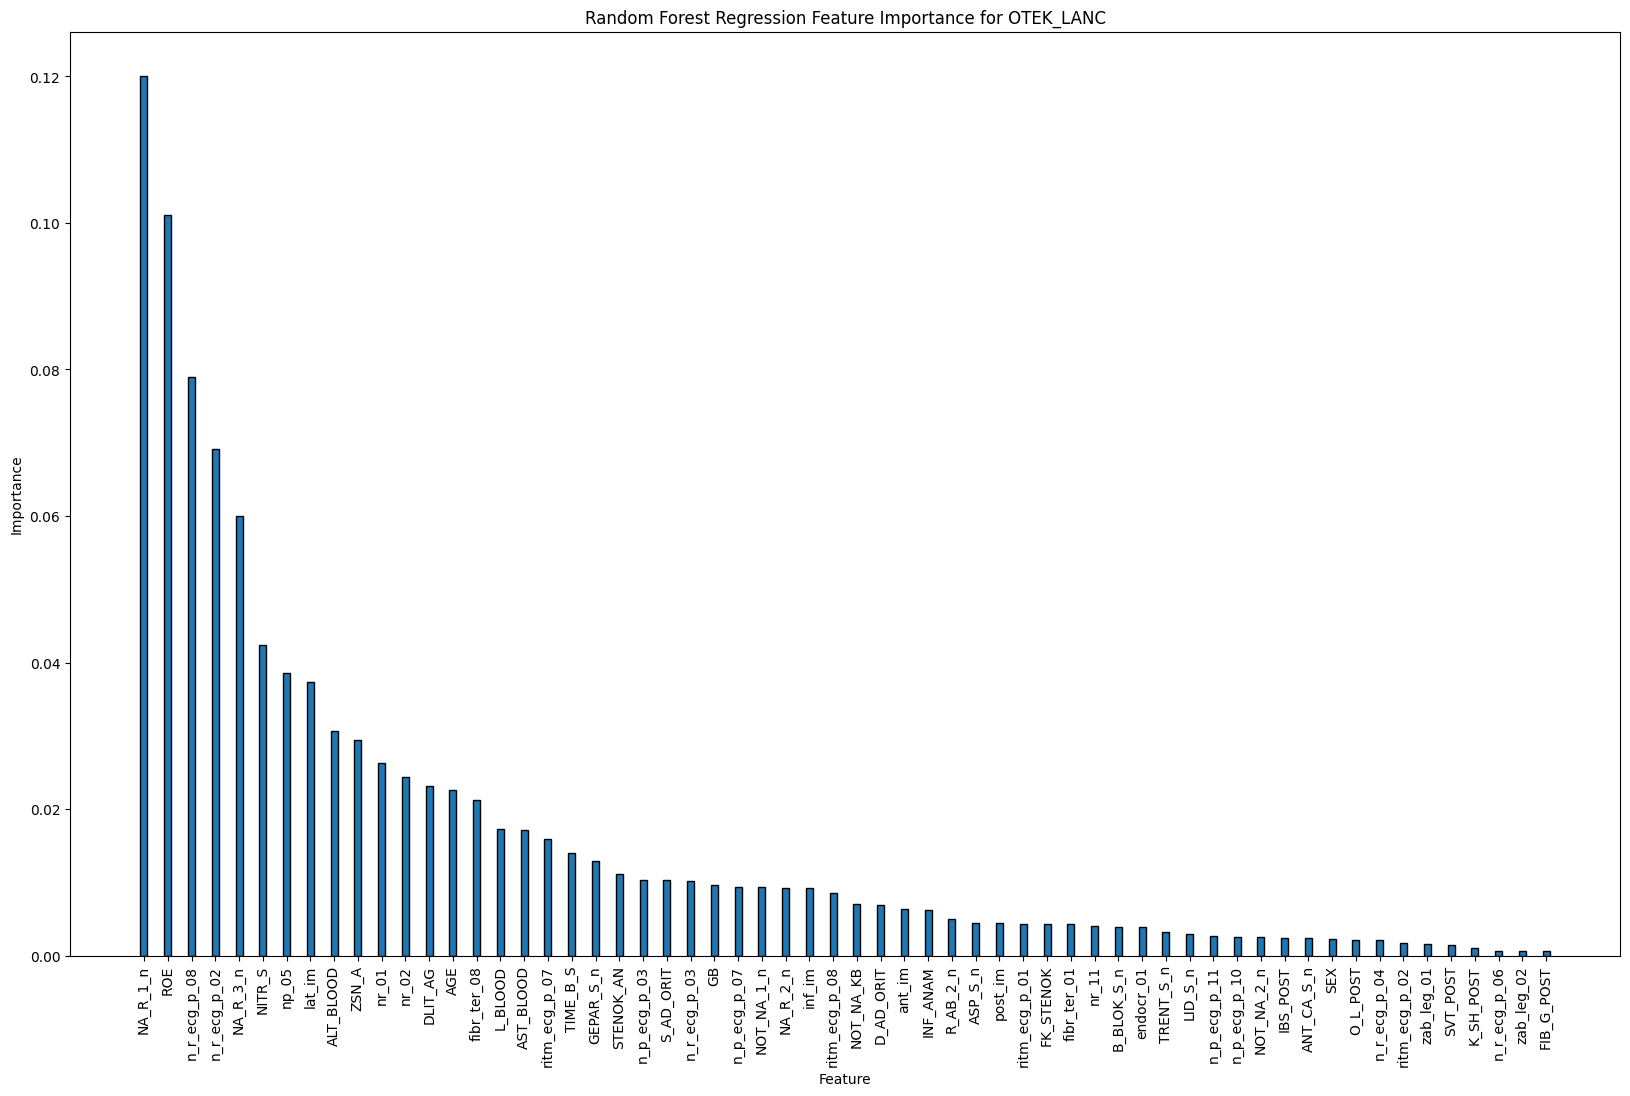

['NA_R_1_n', 'ROE', 'n_r_ecg_p_08', 'n_r_ecg_p_02', 'NA_R_3_n', 'NITR_S', 'np_05', 'lat_im', 'ALT_BLOOD', 'ZSN_A', 'nr_01', 'nr_02', 'DLIT_AG', 'AGE', 'fibr_ter_08', 'L_BLOOD', 'AST_BLOOD', 'ritm_ecg_p_07', 'TIME_B_S', 'GEPAR_S_n', 'STENOK_AN', 'n_p_ecg_p_03', 'S_AD_ORIT', 'n_r_ecg_p_03', 'GB', 'n_p_ecg_p_07', 'NOT_NA_1_n', 'NA_R_2_n', 'inf_im', 'ritm_ecg_p_08']


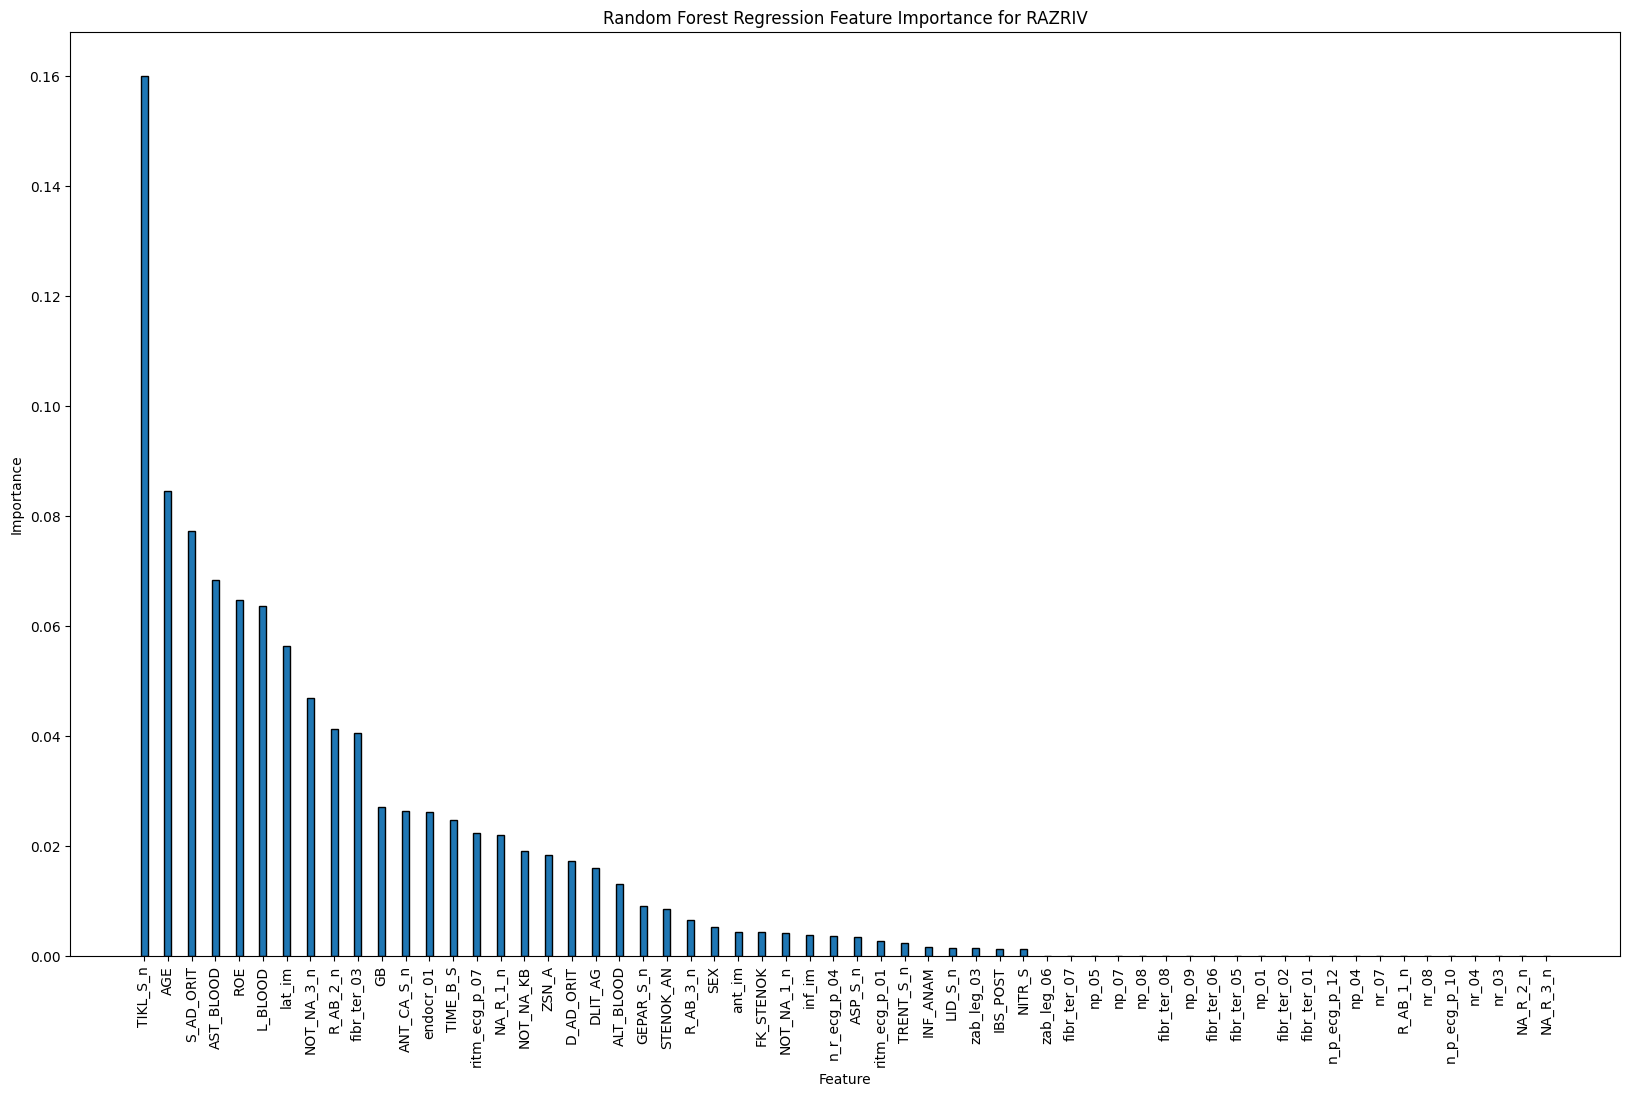

['TIKL_S_n', 'AGE', 'S_AD_ORIT', 'AST_BLOOD', 'ROE', 'L_BLOOD', 'lat_im', 'NOT_NA_3_n', 'R_AB_2_n', 'fibr_ter_03', 'GB', 'ANT_CA_S_n', 'endocr_01', 'TIME_B_S', 'ritm_ecg_p_07', 'NA_R_1_n', 'NOT_NA_KB', 'ZSN_A', 'D_AD_ORIT', 'DLIT_AG', 'ALT_BLOOD']


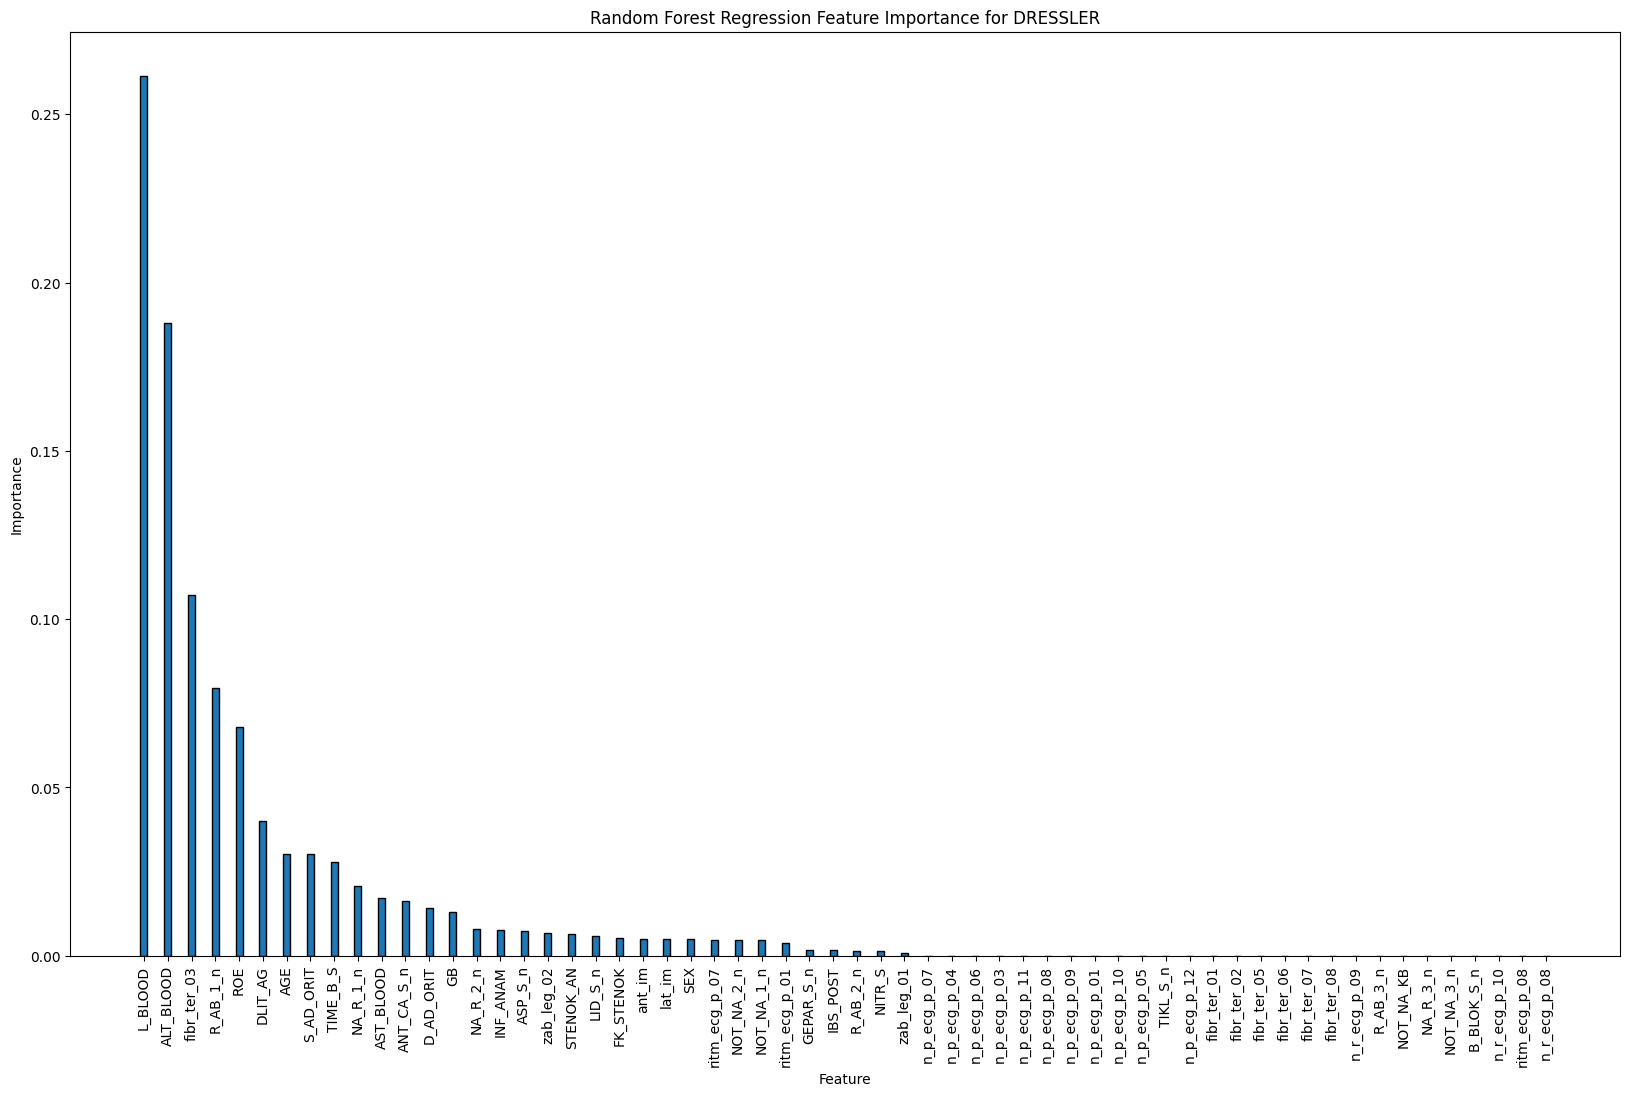

['L_BLOOD', 'ALT_BLOOD', 'fibr_ter_03', 'R_AB_1_n', 'ROE', 'DLIT_AG', 'AGE', 'S_AD_ORIT', 'TIME_B_S', 'NA_R_1_n', 'AST_BLOOD', 'ANT_CA_S_n', 'D_AD_ORIT', 'GB']


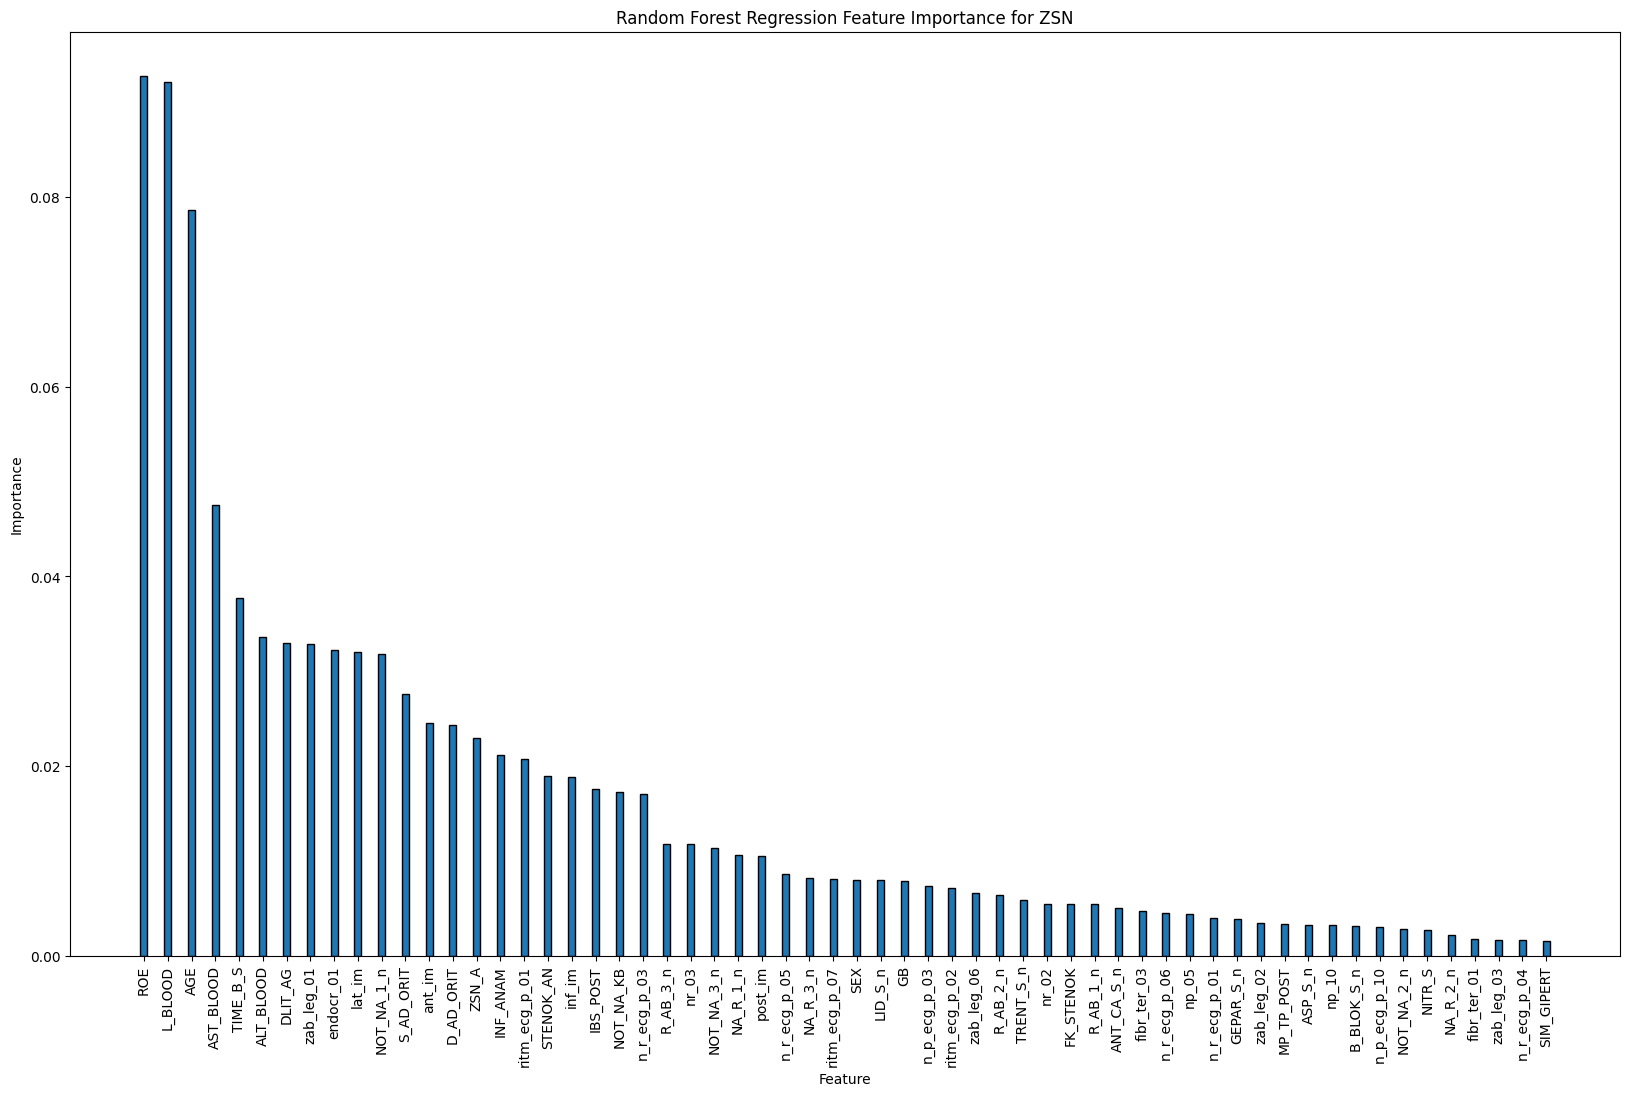

['ROE', 'L_BLOOD', 'AGE', 'AST_BLOOD', 'TIME_B_S', 'ALT_BLOOD', 'DLIT_AG', 'zab_leg_01', 'endocr_01', 'lat_im', 'NOT_NA_1_n', 'S_AD_ORIT', 'ant_im', 'D_AD_ORIT', 'ZSN_A', 'INF_ANAM', 'ritm_ecg_p_01', 'STENOK_AN', 'inf_im', 'IBS_POST', 'NOT_NA_KB', 'n_r_ecg_p_03']


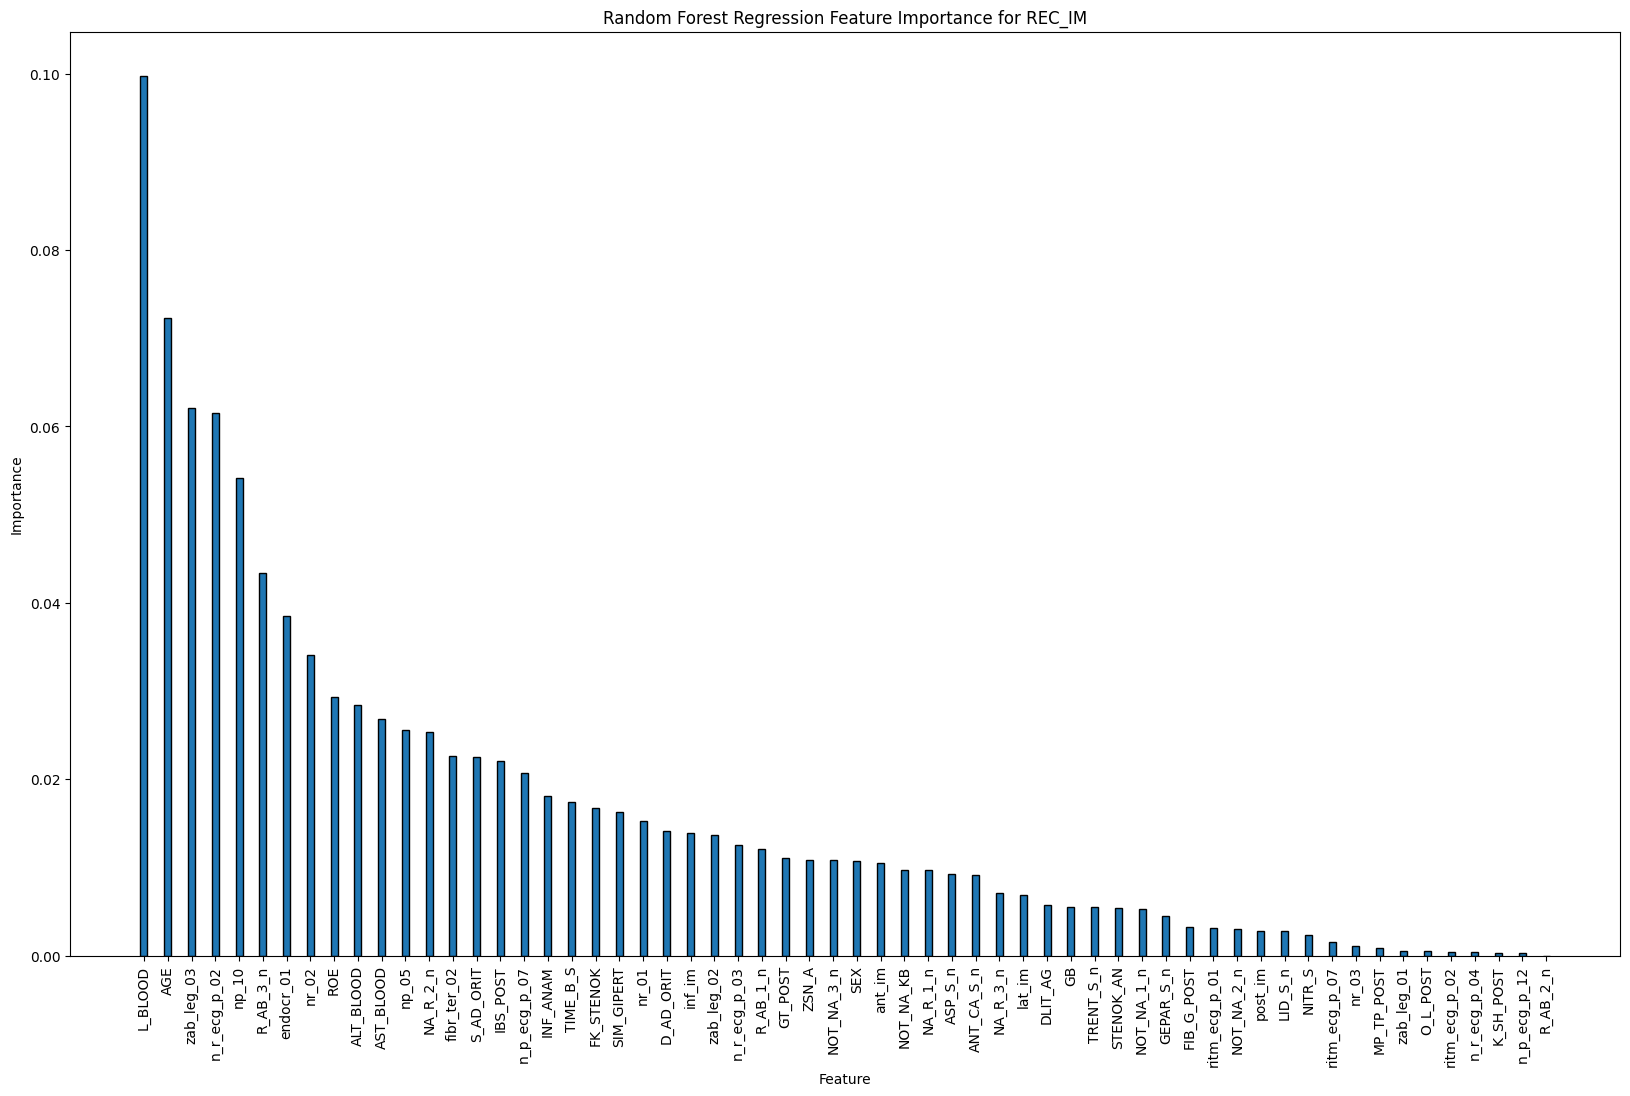

['L_BLOOD', 'AGE', 'zab_leg_03', 'n_r_ecg_p_02', 'np_10', 'R_AB_3_n', 'endocr_01', 'nr_02', 'ROE', 'ALT_BLOOD', 'AST_BLOOD', 'np_05', 'NA_R_2_n', 'fibr_ter_02', 'S_AD_ORIT', 'IBS_POST', 'n_p_ecg_p_07', 'INF_ANAM', 'TIME_B_S', 'FK_STENOK', 'SIM_GIPERT', 'nr_01', 'D_AD_ORIT', 'inf_im', 'zab_leg_02', 'n_r_ecg_p_03', 'R_AB_1_n', 'GT_POST', 'ZSN_A', 'NOT_NA_3_n', 'SEX', 'ant_im', 'NOT_NA_KB', 'NA_R_1_n', 'ASP_S_n', 'ANT_CA_S_n']


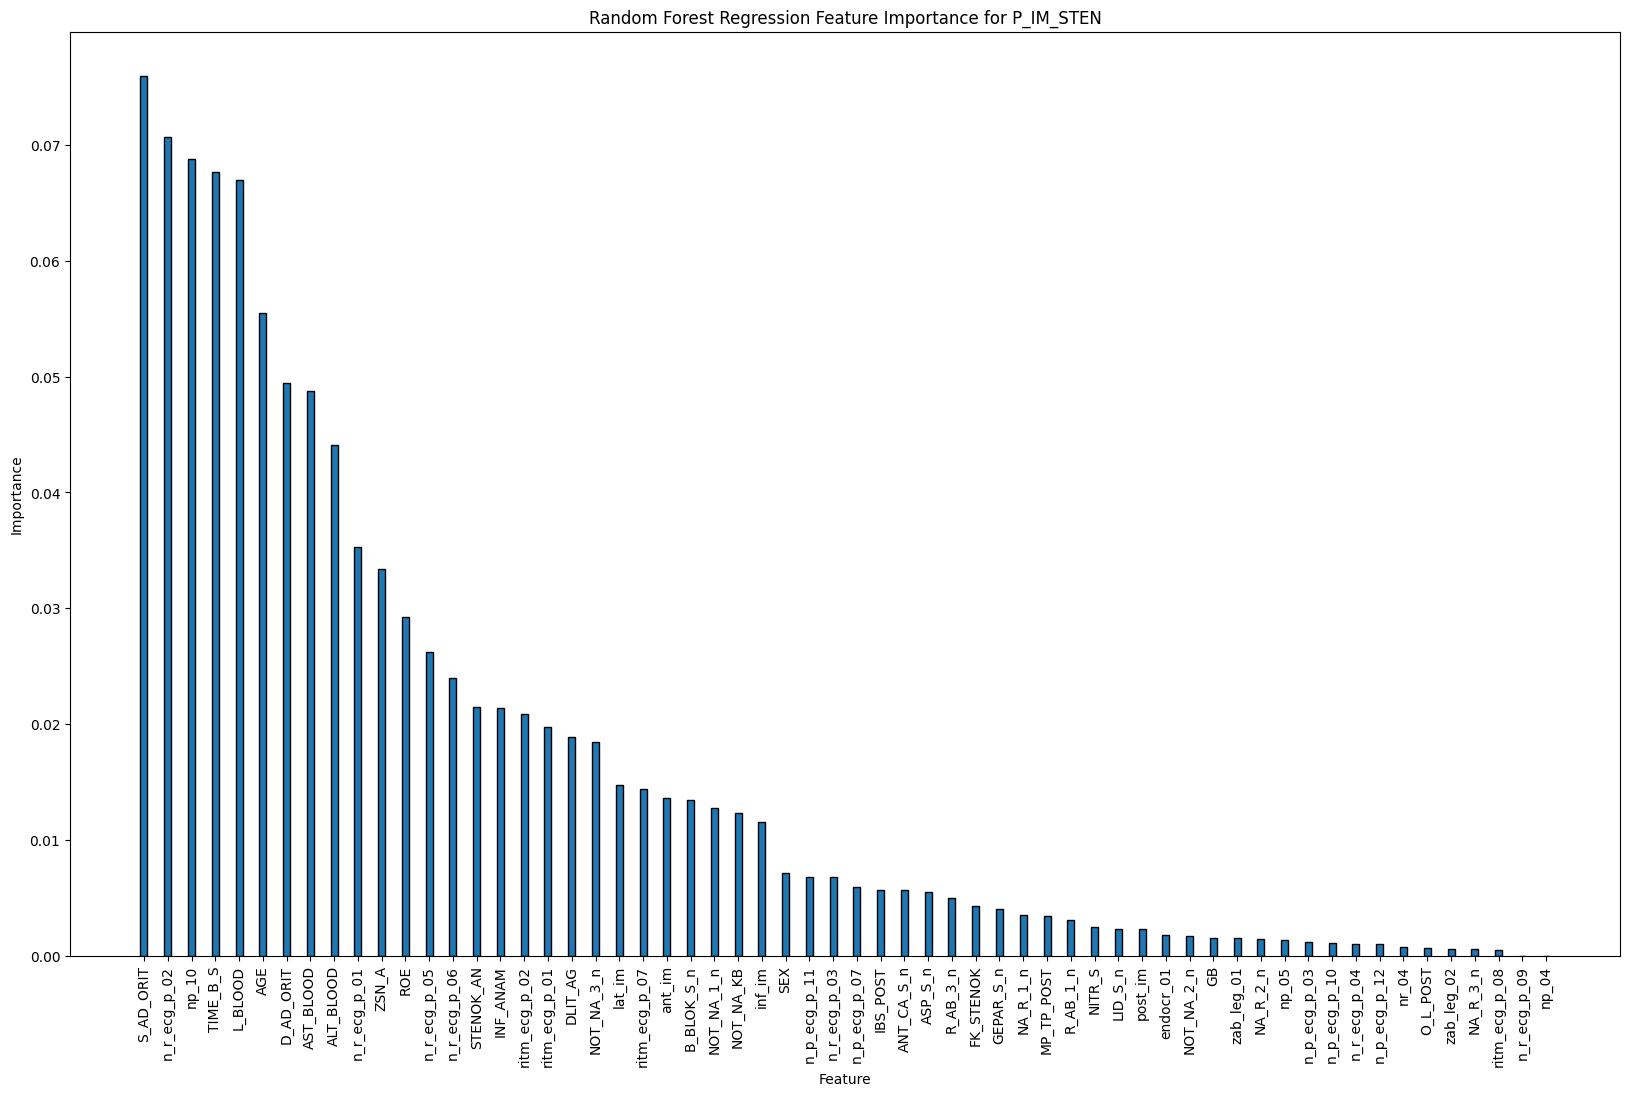

['S_AD_ORIT', 'n_r_ecg_p_02', 'np_10', 'TIME_B_S', 'L_BLOOD', 'AGE', 'D_AD_ORIT', 'AST_BLOOD', 'ALT_BLOOD', 'n_r_ecg_p_01', 'ZSN_A', 'ROE', 'n_r_ecg_p_05', 'n_r_ecg_p_06', 'STENOK_AN', 'INF_ANAM', 'ritm_ecg_p_02', 'ritm_ecg_p_01', 'DLIT_AG', 'NOT_NA_3_n', 'lat_im', 'ritm_ecg_p_07', 'ant_im', 'B_BLOK_S_n', 'NOT_NA_1_n', 'NOT_NA_KB', 'inf_im']


In [13]:
# knn imputation
knn_complication_features_dict = {}
knn_stop_features_dict = {
    'FIBR_PREDS':'IBS_POST',
    'PREDS_TAH':'GB',
    'JELUD_TAH':'AST_BLOOD',
    'FIBR_JELUD':'n_r_ecg_p_04',
    'A_V_BLOK':'LID_S_n',
    'OTEK_LANC':'ritm_ecg_p_08',
    'RAZRIV':'ALT_BLOOD',
    'DRESSLER':'GB',
    'ZSN':'n_r_ecg_p_03',
    'REC_IM':'ANT_CA_S_n',
    'P_IM_STEN':'inf_im'
}
for complication in complications:
    knn_tune = scaled_knn_datasets['tune']
    knn_feature_importance = feature_selection_graph(knn_tune, complication)
    # print(single_feature_importance)
    knn_features_selected = select_up_to_stop_feature(knn_feature_importance, knn_stop_features_dict[complication])
    print(knn_features_selected)
    knn_complication_features_dict[complication] = knn_features_selected

Revised Aim 3.1.0: define generic functions

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score
def calc_custom_score(y_val, y_pred):
    """
    calculate user's weighted F1 score based on recall and precision weight
    the result is an F1 that is biased towards either recall or precision, but 
    crucially, is on the same scale as F1
    """
    precision_factor = 1 - recall_factor
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    score = (recall * precision) / (precision_factor * recall + recall_factor * precision)
    return score 

def final_predictor(model, train, val, predictors, target_variable, threshold, scoring='f1'):
    """
    model: the sklearn initialized model
    train: the full dataframe to be used for training
    val: the full dataframe to be used for testing
    predictors: the features to be used post feature selection
    target_variable: the variable to be predicted
    threshold: the threshold for the regressor to classify positive cases
    """
    x_train = train[predictors]
    y_train = train[target_variable]
    model.fit(x_train, y_train)
    x_val = val[predictors]
    y_val = val[target_variable]
    y_pred = model.predict(x_val)

    # convert to indexed dataframe
    y_pred_df = pd.DataFrame(y_pred, index=y_val.index)
    
    # convert regression output to classification
    y_pred_df = y_pred_df[0].apply(lambda x: 1 if x >= threshold else 0)

    if scoring == 'f1':
        return f1_score(y_val, y_pred_df)
    elif scoring == 'precision':
        return precision_score(y_val, y_pred_df)
    elif scoring == 'recall':
        return recall_score(y_val, y_pred_df)
    elif scoring == 'final':
        return calc_custom_score(y_val, y_pred_df)

Revised Aim 3.1.1: Calculate optimal threshold values for each complication variable (in addition to specific types of target models) using a threshold dataset.

In [15]:
def find_optimal_threshold(threshold_list):
    """
    find the optimal threshold value for each complication using knn and single imputation,
    plus for predicting target variable using (repeat for both knn and single imputation): 
        all features, feature select features, all features + complications, feature select features + complications
    choose best performance among threshold values in threshold_list
    """
    # values are in the format (threshold, F1)
    single_optimal_dict = {
        'all':(0,0),
        'select':(0,0),
        'all_complications':(0,0),
        'select_complications':(0,0)    
    }
    knn_optimal_dict = {
        'all':(0,0),
        'select':(0,0),
        'all_complications':(0,0),
        'select_complications':(0,0)
    }
    for complication in complications:
        single_optimal_dict[complication] = (0,0)
        knn_optimal_dict[complication] = (0,0)
    
    for threshold in threshold_list:
        rf = RandomForestRegressor(random_state=random_seed)
        
        all_features_single = final_predictor(rf, scaled_single_datasets['train'], scaled_single_datasets['threshold'], predictors, target, threshold)
        if single_optimal_dict['all'][1] < all_features_single:
            single_optimal_dict['all'] = (threshold, all_features_single)
        print(f"All Features Single Imputation: {all_features_single}")
        
        feature_selection_single = final_predictor(rf, scaled_single_datasets['train'], scaled_single_datasets['threshold'], single_features_selected_target, target, threshold)
        if single_optimal_dict['select'][1] < feature_selection_single:
            single_optimal_dict['select'] = (threshold, feature_selection_single)
        print(f"Feature Selection Single Imputation: {feature_selection_single}")
        
        all_features_knn = final_predictor(rf, scaled_knn_datasets['train'], scaled_knn_datasets['threshold'], predictors, target, threshold)
        if knn_optimal_dict['all'][1] < all_features_knn:
            knn_optimal_dict['all'] = (threshold, all_features_knn)
        print(f"All Features KNN Imputation: {all_features_knn}")
        
        feature_selection_knn = final_predictor(rf, scaled_knn_datasets['train'], scaled_knn_datasets['threshold'], knn_features_selected_target, target, threshold)
        if knn_optimal_dict['select'][1] < feature_selection_knn:
            knn_optimal_dict['select'] = (threshold, feature_selection_knn)
        print(f"Feature Selection KNN Imputation: {feature_selection_knn}")
        
        # with complications
        all_features_single = final_predictor(rf, scaled_single_datasets['train'], scaled_single_datasets['threshold'], predictors+complications, target, threshold)
        if single_optimal_dict['all_complications'][1] < all_features_single:
            single_optimal_dict['all_complications'] = (threshold, all_features_single)
        print(f"All Features + Complications Single Imputation: {all_features_single}")
        
        feature_selection_single = final_predictor(rf, scaled_single_datasets['train'], scaled_single_datasets['threshold'], single_features_selected_target + complications, target, threshold)
        if single_optimal_dict['select_complications'][1] < feature_selection_single:
            single_optimal_dict['select_complications'] = (threshold, feature_selection_single)
        print(f"Feature Selection + Complications Single Imputation: {feature_selection_single}")
       
        all_features_knn = final_predictor(rf, scaled_knn_datasets['train'], scaled_knn_datasets['threshold'], predictors + complications, target, threshold)
        if knn_optimal_dict['all_complications'][1] < all_features_knn:
            knn_optimal_dict['all_complications'] = (threshold, all_features_knn)
        print(f"All Features + Complications KNN Imputation: {all_features_knn}")
        
        feature_selection_knn = final_predictor(rf, scaled_knn_datasets['train'], scaled_knn_datasets['threshold'], knn_features_selected_target + complications, target, threshold)
        if knn_optimal_dict['select_complications'][1] < feature_selection_knn:
            knn_optimal_dict['select_complications'] = (threshold, feature_selection_knn)
        print(f"Feature Selection + Coimplications KNN Imputation: {feature_selection_knn}")

        # complications
        for complication in complications:
            complication_single = final_predictor(rf, scaled_single_datasets['train'], scaled_single_datasets['threshold'], single_complication_features_dict[complication], complication, threshold)
            if single_optimal_dict[complication][1] < complication_single:
                single_optimal_dict[complication] = (threshold, complication_single)
            
            complication_knn = final_predictor(rf, scaled_knn_datasets['train'], scaled_knn_datasets['threshold'], knn_complication_features_dict[complication], complication, threshold)
            if knn_optimal_dict[complication][1] < complication_knn:
                knn_optimal_dict[complication] = (threshold, complication_knn)

            print(f"{complication} single: {complication_single} for threshold: {threshold}")
            print(f"{complication} knn: {complication_knn} for threshold: {threshold}")

    return single_optimal_dict, knn_optimal_dict

single_optimal_dict, knn_optimal_dict = find_optimal_threshold([0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5])

All Features Single Imputation: 0.27411167512690354
Feature Selection Single Imputation: 0.27411167512690354
All Features KNN Imputation: 0.27411167512690354
Feature Selection KNN Imputation: 0.27411167512690354
All Features + Complications Single Imputation: 0.27411167512690354
Feature Selection + Complications Single Imputation: 0.27411167512690354
All Features + Complications KNN Imputation: 0.27411167512690354
Feature Selection + Coimplications KNN Imputation: 0.27411167512690354
FIBR_PREDS single: 0.2198952879581152 for threshold: 0
FIBR_PREDS knn: 0.2198952879581152 for threshold: 0
PREDS_TAH single: 0.011695906432748537 for threshold: 0
PREDS_TAH knn: 0.011695906432748537 for threshold: 0
JELUD_TAH single: 0.023255813953488372 for threshold: 0
JELUD_TAH knn: 0.023255813953488372 for threshold: 0
FIBR_JELUD single: 0.0898876404494382 for threshold: 0
FIBR_JELUD knn: 0.0898876404494382 for threshold: 0
A_V_BLOK single: 0.06818181818181818 for threshold: 0
A_V_BLOK knn: 0.068181818

In [16]:
# view optimal results
print("format is --- key: (threshold, max f1 score)")
print(single_optimal_dict)
print(knn_optimal_dict)

format is --- key: (threshold, max f1 score)
{'all': (0.3, 0.5925925925925926), 'select': (0.4, 0.5454545454545454), 'all_complications': (0.4, 0.7058823529411765), 'select_complications': (0.4, 0.6666666666666666), 'FIBR_PREDS': (0.35, 0.27586206896551724), 'PREDS_TAH': (0, 0.011695906432748537), 'JELUD_TAH': (0, 0.023255813953488372), 'FIBR_JELUD': (0.1, 0.2790697674418604), 'A_V_BLOK': (0.3, 0.25), 'OTEK_LANC': (0.1, 0.2619047619047619), 'RAZRIV': (0.15, 0.19047619047619047), 'DRESSLER': (0.2, 0.2222222222222222), 'ZSN': (0.4, 0.5194805194805194), 'REC_IM': (0.15, 0.1818181818181818), 'P_IM_STEN': (0.2, 0.27906976744186046)}
{'all': (0.3, 0.6451612903225806), 'select': (0.25, 0.5974025974025975), 'all_complications': (0.5, 0.6956521739130435), 'select_complications': (0.5, 0.6521739130434783), 'FIBR_PREDS': (0.25, 0.35), 'PREDS_TAH': (0, 0.011695906432748537), 'JELUD_TAH': (0, 0.023255813953488372), 'FIBR_JELUD': (0.05, 0.1846153846153846), 'A_V_BLOK': (0.25, 0.3), 'OTEK_LANC': (0.3

Revised Aim 3.1.2: Choose which complication variables will be used in the final model by dropping low F1 scores.

In [17]:
# create new list of complications that will be used to aid prediction of target variable
# only keep useful complications (exceeding 0.25 F1 score)
new_complications_list = []
for complication in complications:
    if single_optimal_dict[complication][1] <= 0.25 and knn_optimal_dict[complication][1] <= 0.25:
        pass
    else:
        new_complications_list.append(complication)

print(new_complications_list)

['FIBR_PREDS', 'FIBR_JELUD', 'A_V_BLOK', 'OTEK_LANC', 'ZSN', 'P_IM_STEN']


{'FIBR_PREDS': 11.11111111111111, 'PREDS_TAH': 1.1695906432748537, 'JELUD_TAH': 2.923976608187134, 'FIBR_JELUD': 4.093567251461988, 'A_V_BLOK': 3.508771929824561, 'OTEK_LANC': 8.771929824561402, 'RAZRIV': 2.3391812865497075, 'DRESSLER': 2.923976608187134, 'ZSN': 28.07017543859649, 'REC_IM': 9.941520467836257, 'P_IM_STEN': 7.017543859649122}
{'FIBR_PREDS': 35.0, 'PREDS_TAH': 1.1695906432748537, 'JELUD_TAH': 2.3255813953488373, 'FIBR_JELUD': 18.46153846153846, 'A_V_BLOK': 30.0, 'OTEK_LANC': 30.76923076923077, 'RAZRIV': 17.647058823529413, 'DRESSLER': 25.0, 'ZSN': 50.70422535211267, 'REC_IM': 20.0, 'P_IM_STEN': 27.027027027027025}


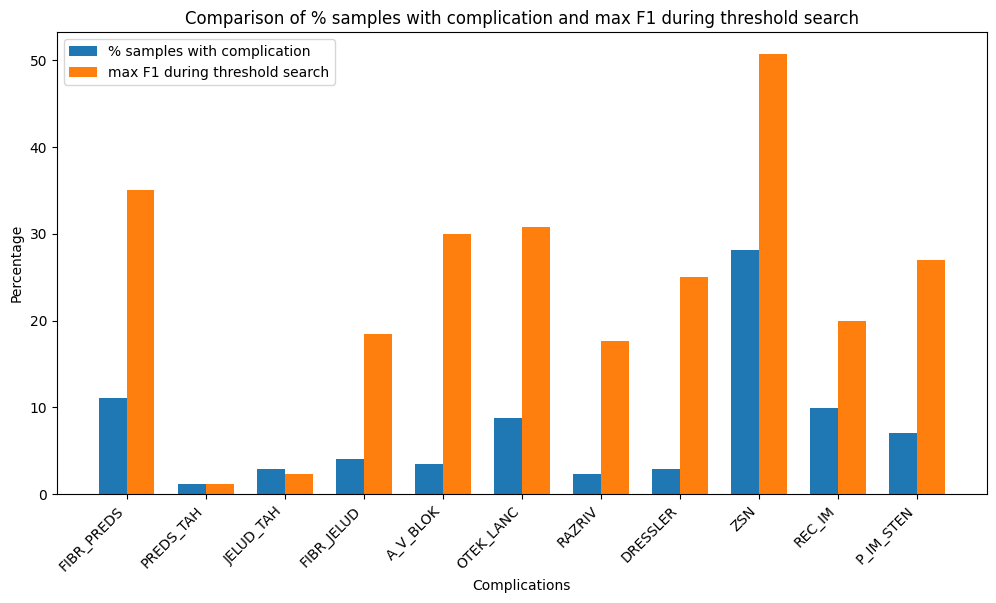

In [18]:
# intuition check: are complications in new complication list mostly the ones with higher % positive cases?
# I expect complications with lower % positive cases to be harder to predict
# I want to evaluate whether or not this hypothesis is true
# use tuning dataset for this task to avoid biasing

def plot_two_dicts_same_keys(dict1, dict2, description1, description2):
    """
    generic function to plot any two dictionaries that share keys
    """
    keys = list(dict1.keys())
    list1 = [dict1[key] for key in keys]
    list2 = [dict2[key] for key in keys]
    bar_width = 0.35
    index = np.arange(len(keys))
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bar1 = ax.bar(index, list1, bar_width, label=description1)
    bar2 = ax.bar(index + bar_width, list2, bar_width, label=description2)
    
    ax.set_xlabel('Complications')
    ax.set_ylabel('Percentage')
    ax.set_title(f"Comparison of {description1} and {description2}")
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(keys, rotation=45, ha='right')
    ax.legend()
    
    plt.show()

percent_positive_label = {}
threshold_max_performance = {}

for complication in complications:
    percentage_value_1 = scaled_single_datasets['tune'][complication].value_counts(normalize=True).get(1, 0) * 100
    percent_positive_label[complication] = percentage_value_1
    threshold_max_performance[complication] = knn_optimal_dict[complication][1] * 100

print(percent_positive_label)
print(threshold_max_performance)

plot_two_dicts_same_keys(percent_positive_label, threshold_max_performance, '% samples with complication', 'max F1 during threshold search')

The result is about as expected, with features that were worth keeping in the previous step based on threshold performance analysis quite correlated with prevalance of positive cases. Of the top 7 by % of positive cases, 6 passed the benchmark for performance on threshold dataset. None outside of the top 7 do so. This indicates that the small number of samples in the dataset is hurting performance, since performance is much worse for those with low % of positive cases. If more positive cases were seen, the performance would likely improve. Alternatively, these complications could be harder to predict - without domain knowledge, I cannot speak to this fact.

Revised Aim 3.2: Build models for predicting complication variables and report scores

{'FIBR_PREDS': 0.2222222222222222, 'FIBR_JELUD': 0.08333333333333334, 'A_V_BLOK': 0.23076923076923078, 'OTEK_LANC': 0.3089430894308943, 'ZSN': 0.3969465648854962, 'P_IM_STEN': 0.15217391304347827}
{'FIBR_PREDS': 0.22950819672131148, 'FIBR_JELUD': 0.128, 'A_V_BLOK': 0.2222222222222222, 'OTEK_LANC': 0.26666666666666666, 'ZSN': 0.45614035087719296, 'P_IM_STEN': 0.18604651162790695}
complication: FIBR_PREDS F1 score on validation: 0.22950819672131148
complication: FIBR_JELUD F1 score on validation: 0.128
complication: A_V_BLOK F1 score on validation: 0.2222222222222222
complication: OTEK_LANC F1 score on validation: 0.26666666666666666
complication: ZSN F1 score on validation: 0.45614035087719296
complication: P_IM_STEN F1 score on validation: 0.18604651162790695


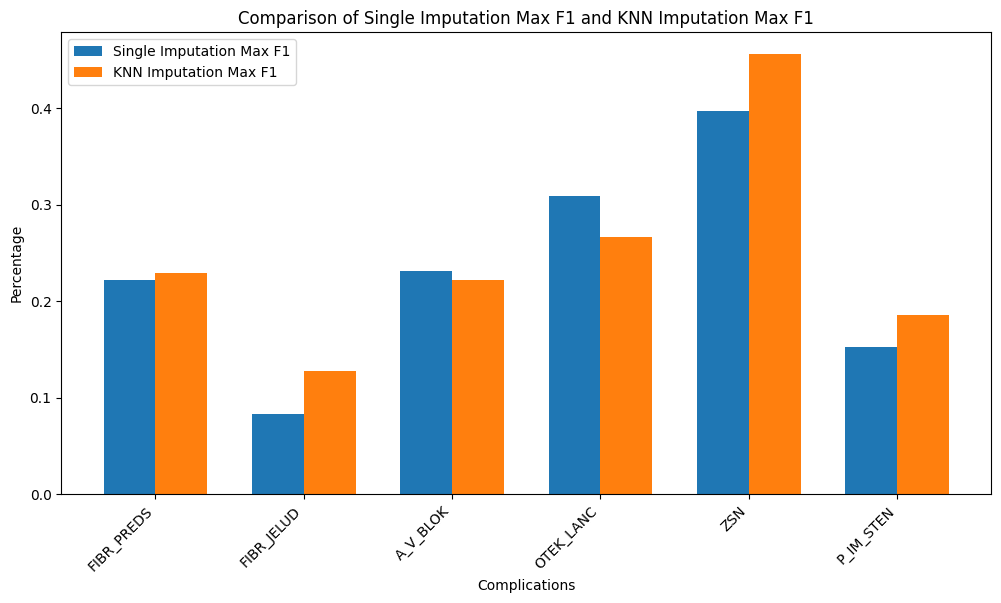

In [19]:
def run_model_on_target_complication(model, train_dataset, val_dataset, features_selected, target_complication, threshold, return_model, scoring):
    """
    model: the sklearn initialized model
    train_dataset: the full dataframe to be used for training
    val_dataset: the full dataframe to be used for testing
    features_selected: the features to be used
    target_complication: the variable to be predicted
    threshold: the threshold for the regressor to classify positive cases
    return_model: if the fit model should be returned as well for further analysis
    scoring: which scoring function should be used
    """
    x_train = train_dataset[features_selected]
    y_train = train_dataset[target_complication]
    model.fit(x_train, y_train)
    
    x_val = val_dataset[features_selected]
    y_val = val_dataset[target_complication]
    y_pred = model.predict(x_val)
    y_pred_df = pd.DataFrame(y_pred, index=y_val.index)
    y_pred_df = y_pred_df[0].apply(lambda x: 1 if x > threshold else 0)

    if return_model:
        return calc_custom_score(y_val, y_pred_df), model
    if scoring == 'f1':
        return f1_score(y_val, y_pred_df)
    if scoring == 'precision':
        return precision_score(y_val, y_pred_df)
    if scoring == 'recall':
        return recall_score(y_val, y_pred_df)

model = RandomForestRegressor(random_state=random_seed)
single_complication_scores = {}
knn_complication_scores = {}

for complication in new_complications_list:
    single_complication_scores[complication] =  run_model_on_target_complication(model, scaled_single_datasets['train'], scaled_single_datasets['validation'], single_complication_features_dict[complication], complication, single_optimal_dict[complication][0], return_model=False, scoring = 'f1')
    knn_complication_scores[complication] = run_model_on_target_complication(model, scaled_knn_datasets['train'], scaled_knn_datasets['validation'], knn_complication_features_dict[complication], complication, knn_optimal_dict[complication][0], return_model=False, scoring = 'f1')
print(single_complication_scores)
print(knn_complication_scores)

for complication,score in knn_complication_scores.items():
    print(f"complication: {complication} F1 score on validation: {score}")

plot_two_dicts_same_keys(single_complication_scores, knn_complication_scores, 'Single Imputation Max F1', 'KNN Imputation Max F1')

KNN is outperforming single imputation, so I will keep KNN as the imputation method for all complication variables

Revised Aim 3.3: Build all variations of models and test on validation data, report results, choose highest performers

In [20]:
target = 'LET_IS'
def make_predictions(model, train_dataset, val_dataset, features_selected, target_complication, threshold):
    """
    function to predict a single complication variable, the result is not adjusted
    """
    x_train = train_dataset[features_selected]
    y_train = train_dataset[target_complication]
    model.fit(x_train, y_train)
    
    x_val = val_dataset[features_selected]
    y_val = val_dataset[target_complication]
    y_pred = model.predict(x_val)
    y_pred_df = pd.DataFrame(y_pred, index=y_val.index)
    # y_pred_df = y_pred_df[0].apply(lambda x: 1 if x > threshold else 0)
    return y_pred_df

def run_final(train, val, features, complication_features_dict, threshold_dict, scoring='f1'):
    model = RandomForestRegressor(random_state=random_seed)

    # build the complications dataframe by predicting one by one
    complications_dataframe = pd.DataFrame(columns=new_complications_list)
    for complication in new_complications_list:
        complications_dataframe[complication] = make_predictions(model, train, val, complication_features_dict[complication], complication, threshold_dict[complication][0])

    # replace complication values with complication predictions from dataframe
    val[new_complications_list] = complications_dataframe
    return final_predictor(model, train, val, features + new_complications_list, target, threshold_dict['select'][0], scoring)

def print_score_precision_recall(score, prec, rec):
    print(f"weighted F1 score: {score}")
    print(f"precision: {prec}")
    print(f"recall: {rec}\n")

# REPORT BASELINE PERFORMANCE - KNN
train = scaled_knn_datasets['train'].copy()
val = scaled_knn_datasets['validation'].copy()
complication_features_dict = knn_complication_features_dict
threshold_dict = knn_optimal_dict

features = knn_features_selected_target
optimal_string = 'select'
score = final_predictor(model, train, val, features, target, threshold_dict[optimal_string][0])
prec = final_predictor(model, train, val, features, target, threshold_dict[optimal_string][0], 'precision')
rec = final_predictor(model, train, val, features, target, threshold_dict[optimal_string][0], 'recall')
print(f"KNN Feature Select:")
print_score_precision_recall(score, prec, rec)

features = predictors
optimal_string = 'all'
score = final_predictor(model, train, val, features, target, threshold_dict[optimal_string][0])
prec = final_predictor(model, train, val, features, target, threshold_dict[optimal_string][0], 'precision')
rec = final_predictor(model, train, val, features, target, threshold_dict[optimal_string][0], 'recall')
print(f"KNN All Features:")
print_score_precision_recall(score, prec, rec)

features = knn_features_selected_target + complications
optimal_string = 'select_complications'
score = final_predictor(model, train, val, features, target, threshold_dict[optimal_string][0])
prec = final_predictor(model, train, val, features, target, threshold_dict[optimal_string][0], 'precision')
rec = final_predictor(model, train, val, features, target, threshold_dict[optimal_string][0], 'recall')
print(f"KNN Feature Select + Complications:")
print_score_precision_recall(score, prec, rec)

features = predictors + complications
optimal_string = 'all_complications'
score = final_predictor(model, train, val, features, target, threshold_dict[optimal_string][0])
prec = final_predictor(model, train, val, features, target, threshold_dict[optimal_string][0], 'precision')
rec = final_predictor(model, train, val, features, target, threshold_dict[optimal_string][0], 'recall')
print(f"KNN All Features + Complications:")
print_score_precision_recall(score, prec, rec)

# REPORT BASELINE PERFORMANCE - Single Imputation
train = scaled_single_datasets['train'].copy()
val = scaled_single_datasets['validation'].copy()
complication_features_dict = single_complication_features_dict
threshold_dict = single_optimal_dict

features = single_features_selected_target
optimal_string = 'select'
score = final_predictor(model, train, val, features, target, threshold_dict[optimal_string][0])
prec = final_predictor(model, train, val, features, target, threshold_dict[optimal_string][0], 'precision')
rec = final_predictor(model, train, val, features, target, threshold_dict[optimal_string][0], 'recall')
print(f"Single Feature Select:")
print_score_precision_recall(score, prec, rec)

features = predictors
optimal_string = 'all'
score = final_predictor(model, train, val, features, target, threshold_dict[optimal_string][0])
prec = final_predictor(model, train, val, features, target, threshold_dict[optimal_string][0], 'precision')
rec = final_predictor(model, train, val, features, target, threshold_dict[optimal_string][0], 'recall')
print(f"Single All Features:")
print_score_precision_recall(score, prec, rec)

features = single_features_selected_target + complications
optimal_string = 'select_complications'
score = final_predictor(model, train, val, features, target, threshold_dict[optimal_string][0])
prec = final_predictor(model, train, val, features, target, threshold_dict[optimal_string][0], 'precision')
rec = final_predictor(model, train, val, features, target, threshold_dict[optimal_string][0], 'recall')
print(f"Single Feature Select + Complications:")
print_score_precision_recall(score, prec, rec)

features = predictors + complications
optimal_string = 'all_complications'
score = final_predictor(model, train, val, features, target, threshold_dict[optimal_string][0])
prec = final_predictor(model, train, val, features, target, threshold_dict[optimal_string][0], 'precision')
rec = final_predictor(model, train, val, features, target, threshold_dict[optimal_string][0], 'recall')
print(f"Single All Features + Complications:")
print_score_precision_recall(score, prec, rec)

KNN Feature Select:
weighted F1 score: 0.432
precision: 0.38028169014084506
recall: 0.5

KNN All Features:
weighted F1 score: 0.5882352941176471
precision: 0.625
recall: 0.5555555555555556

KNN Feature Select + Complications:
weighted F1 score: 0.6593406593406594
precision: 0.8108108108108109
recall: 0.5555555555555556

KNN All Features + Complications:
weighted F1 score: 0.6666666666666667
precision: 0.8787878787878788
recall: 0.5370370370370371

Single Feature Select:
weighted F1 score: 0.48543689320388356
precision: 0.5102040816326531
recall: 0.46296296296296297

Single All Features:
weighted F1 score: 0.576923076923077
precision: 0.6
recall: 0.5555555555555556

Single Feature Select + Complications:
weighted F1 score: 0.6796116504854369
precision: 0.7142857142857143
recall: 0.6481481481481481

Single All Features + Complications:
weighted F1 score: 0.6938775510204083
precision: 0.7727272727272727
recall: 0.6296296296296297



Highest performing baseline model (without complications): KNN all features.
The highest performing baseline model with complications serves as a relative 'ceiling' - even if my complications predictions were perfect, I cannot expect performance higher than perfect labels. 

In [21]:
# REPORT MODEL PERFORMANCE
# knn imputation
train = scaled_knn_datasets['train'].copy()
val = scaled_knn_datasets['validation'].copy()
complication_features_dict = knn_complication_features_dict
threshold_dict = knn_optimal_dict

features = knn_features_selected_target
score = run_final(train, val, features, complication_features_dict, threshold_dict)
prec = run_final(train, val, features, complication_features_dict, threshold_dict, 'precision')
rec = run_final(train, val, features, complication_features_dict, threshold_dict, 'recall')
print(f"KNN imputation feature selection with complication prediction:")
print_score_precision_recall(score, prec, rec)

features = predictors
score = run_final(train, val, features, complication_features_dict, threshold_dict)
prec = run_final(train, val, features, complication_features_dict, threshold_dict, 'precision')
rec = run_final(train, val, features, complication_features_dict, threshold_dict, 'recall')
print(f"KNN imputation all features with complication prediction")
print_score_precision_recall(score, prec, rec)

# single imputation
complication_features_dict = single_complication_features_dict
threshold_dict = single_optimal_dict

features = single_features_selected_target
score = run_final(train, val, features, complication_features_dict, threshold_dict)
prec = run_final(train, val, features, complication_features_dict, threshold_dict, 'precision')
rec = run_final(train, val, features, complication_features_dict, threshold_dict, 'recall')
print(f"Single imputation feature selection with complication prediction:")
print_score_precision_recall(score, prec, rec)

features = predictors
score = run_final(train, val, features, complication_features_dict, threshold_dict)
prec = run_final(train, val, features, complication_features_dict, threshold_dict, 'precision')
rec = run_final(train, val, features, complication_features_dict, threshold_dict, 'recall')
print(f"Single imputation all features with complication prediction:")
print_score_precision_recall(score, prec, rec)

KNN imputation feature selection with complication prediction:
weighted F1 score: 0.467741935483871
precision: 0.4142857142857143
recall: 0.5370370370370371

KNN imputation all features with complication prediction
weighted F1 score: 0.5535714285714285
precision: 0.5344827586206896
recall: 0.5740740740740741

Single imputation feature selection with complication prediction:
weighted F1 score: 0.4897959183673469
precision: 0.5454545454545454
recall: 0.4444444444444444

Single imputation all features with complication prediction:
weighted F1 score: 0.5348837209302325
precision: 0.71875
recall: 0.42592592592592593



Highest performer is KNN Imputation with all features

Revised Aim 3.4: Test final models and report results, as well as reporting feature importance for better interpretability

FIBR_PREDS weighted F1 score on test data: 0.29729729729729726
FIBR_PREDS precision score on test data: 0.25
FIBR_PREDS recall score on test data: 0.36666666666666664


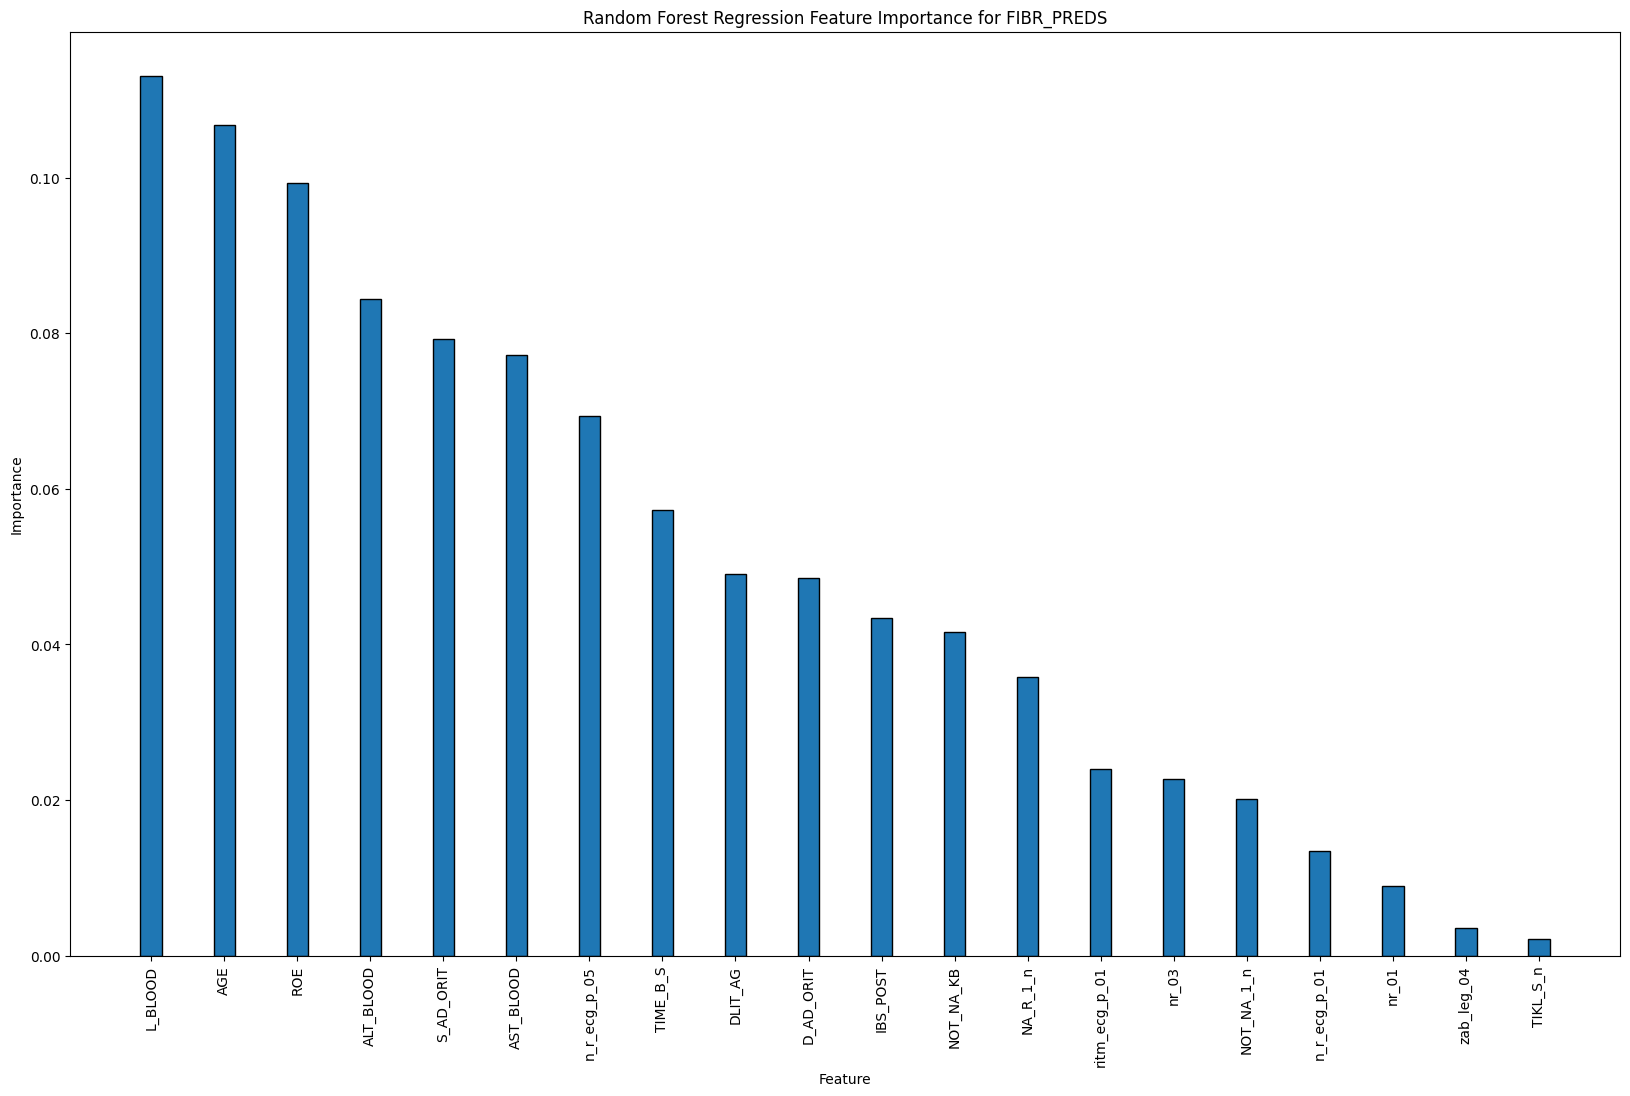

FIBR_JELUD weighted F1 score on test data: 0.07894736842105263
FIBR_JELUD precision score on test data: 0.04411764705882353
FIBR_JELUD recall score on test data: 0.375


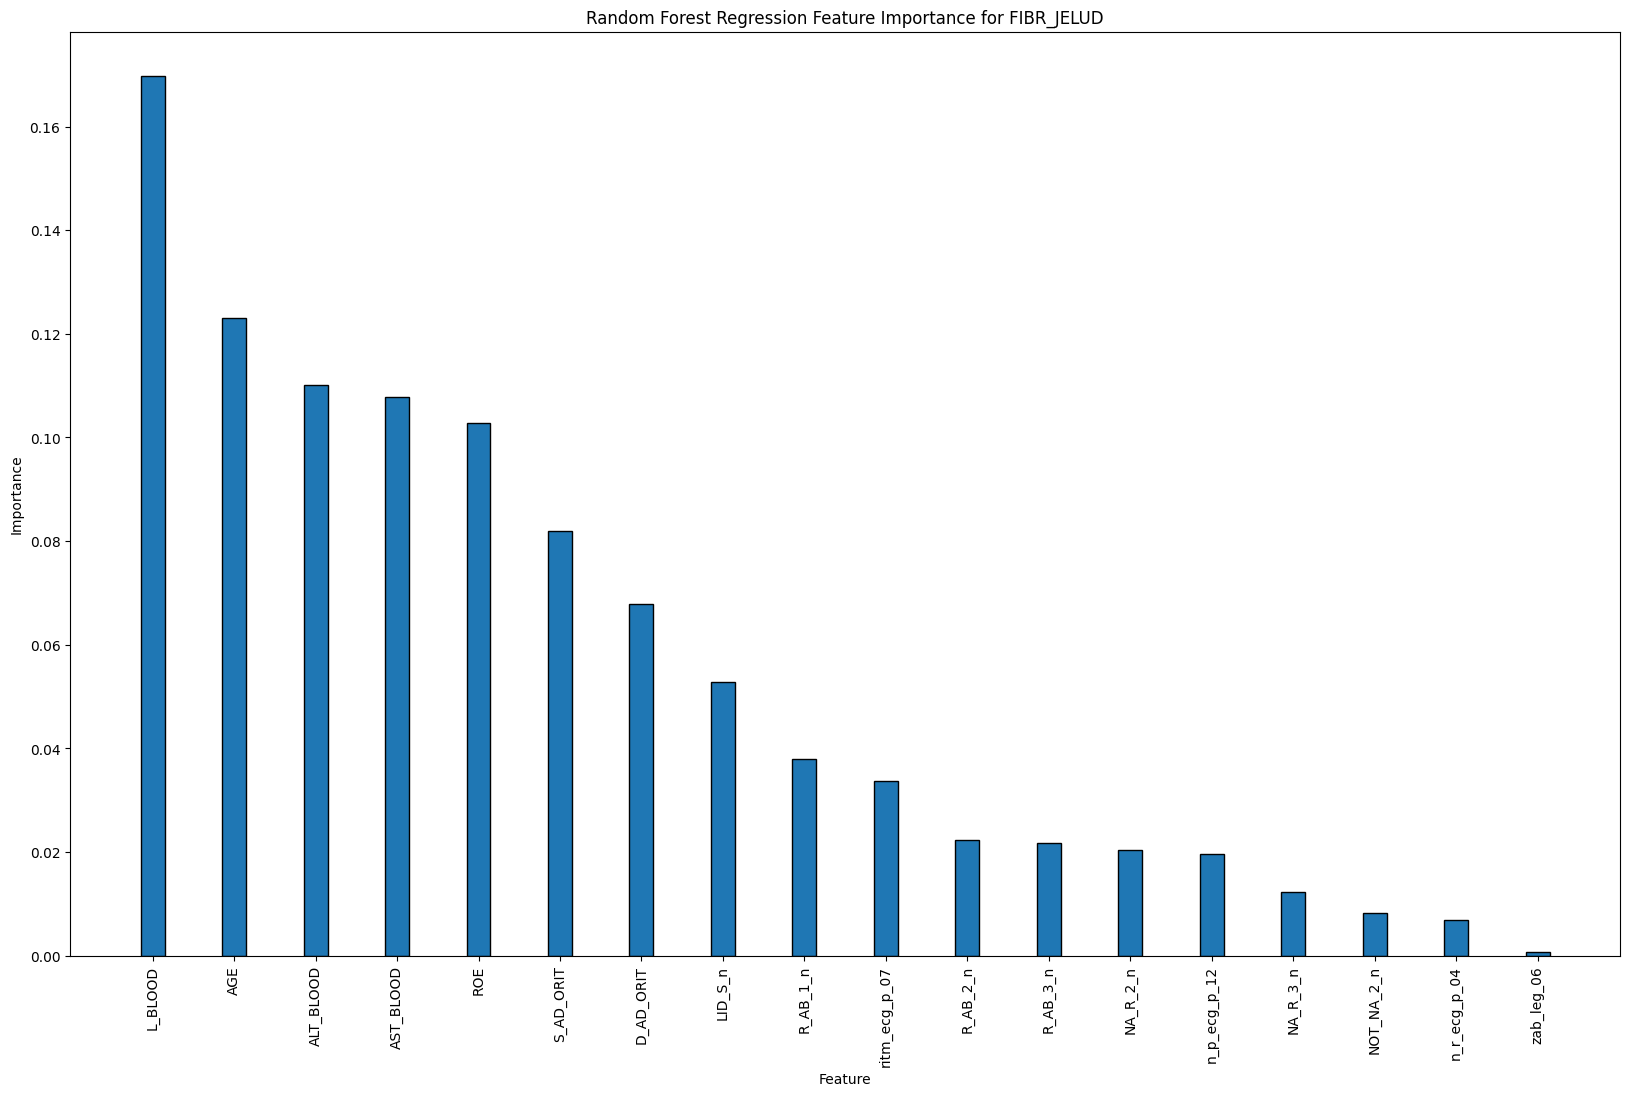

C:\Users\saril\AppData\Local\Temp\ipykernel_27796\3549994516.py:11: RuntimeWarning: invalid value encountered in scalar divide
  score = (recall * precision) / (precision_factor * recall + recall_factor * precision)


A_V_BLOK weighted F1 score on test data: nan
A_V_BLOK precision score on test data: 0.0
A_V_BLOK recall score on test data: 0.0


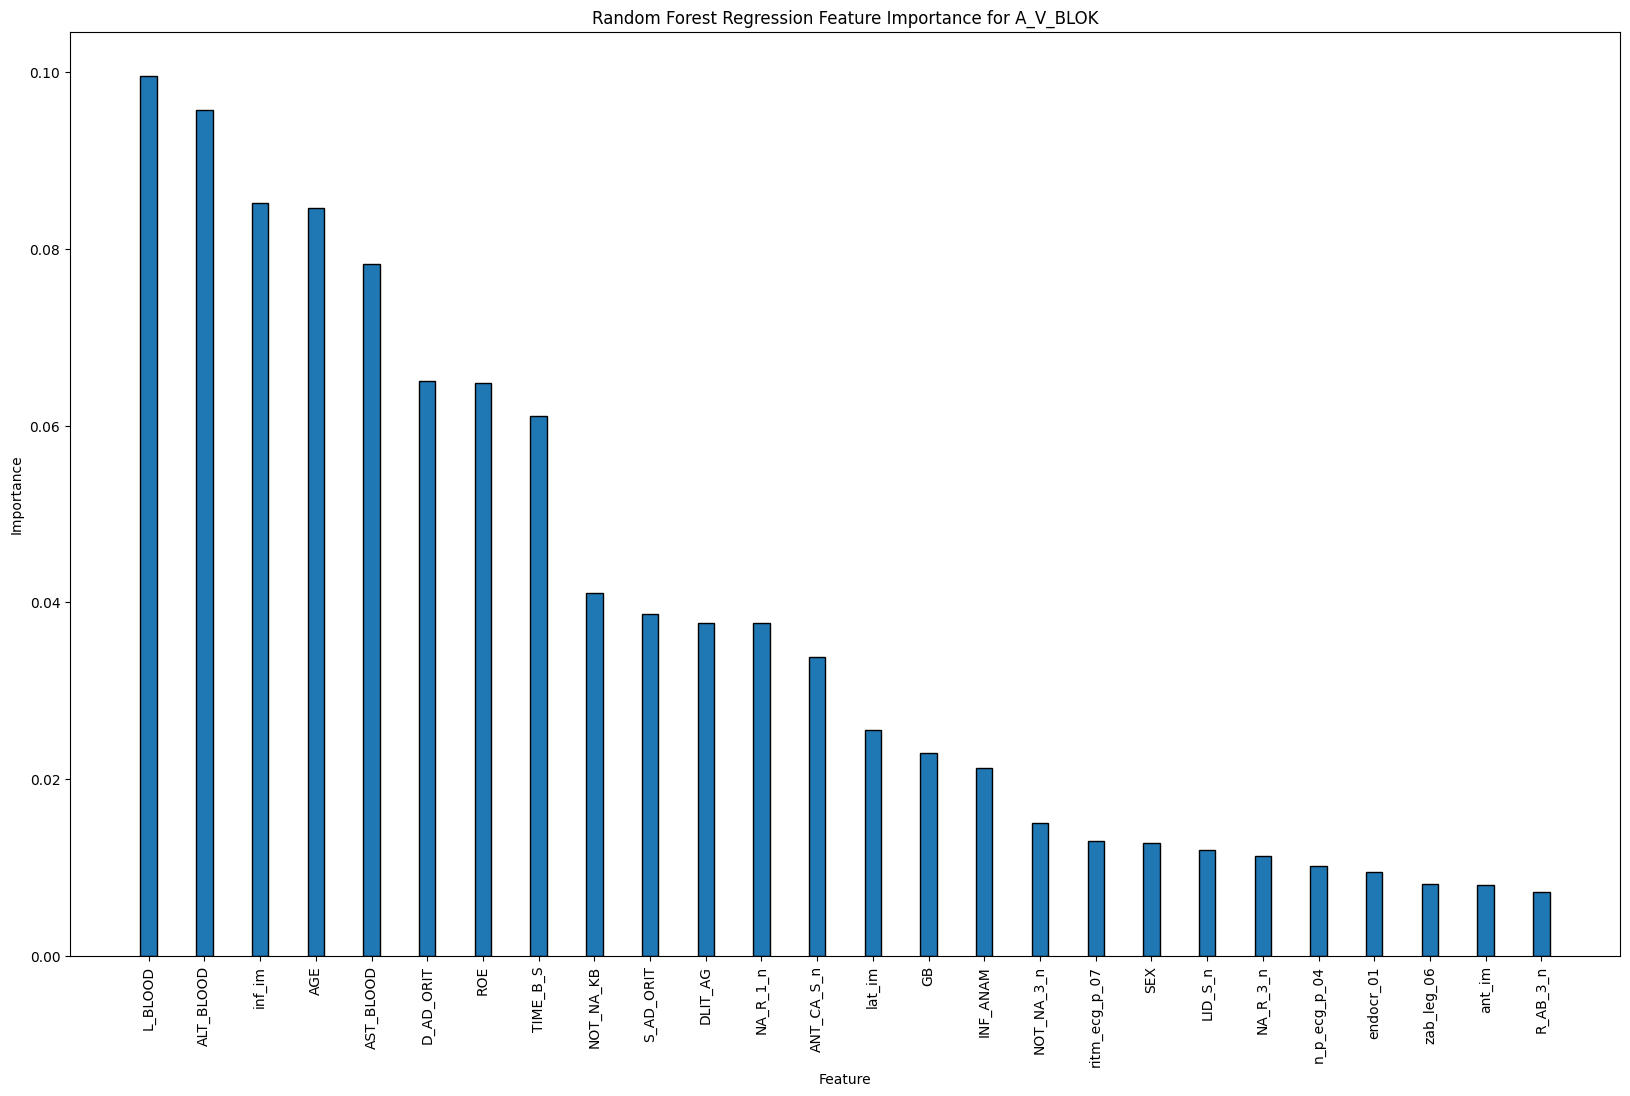

OTEK_LANC weighted F1 score on test data: 0.2727272727272727
OTEK_LANC precision score on test data: 0.375
OTEK_LANC recall score on test data: 0.21428571428571427


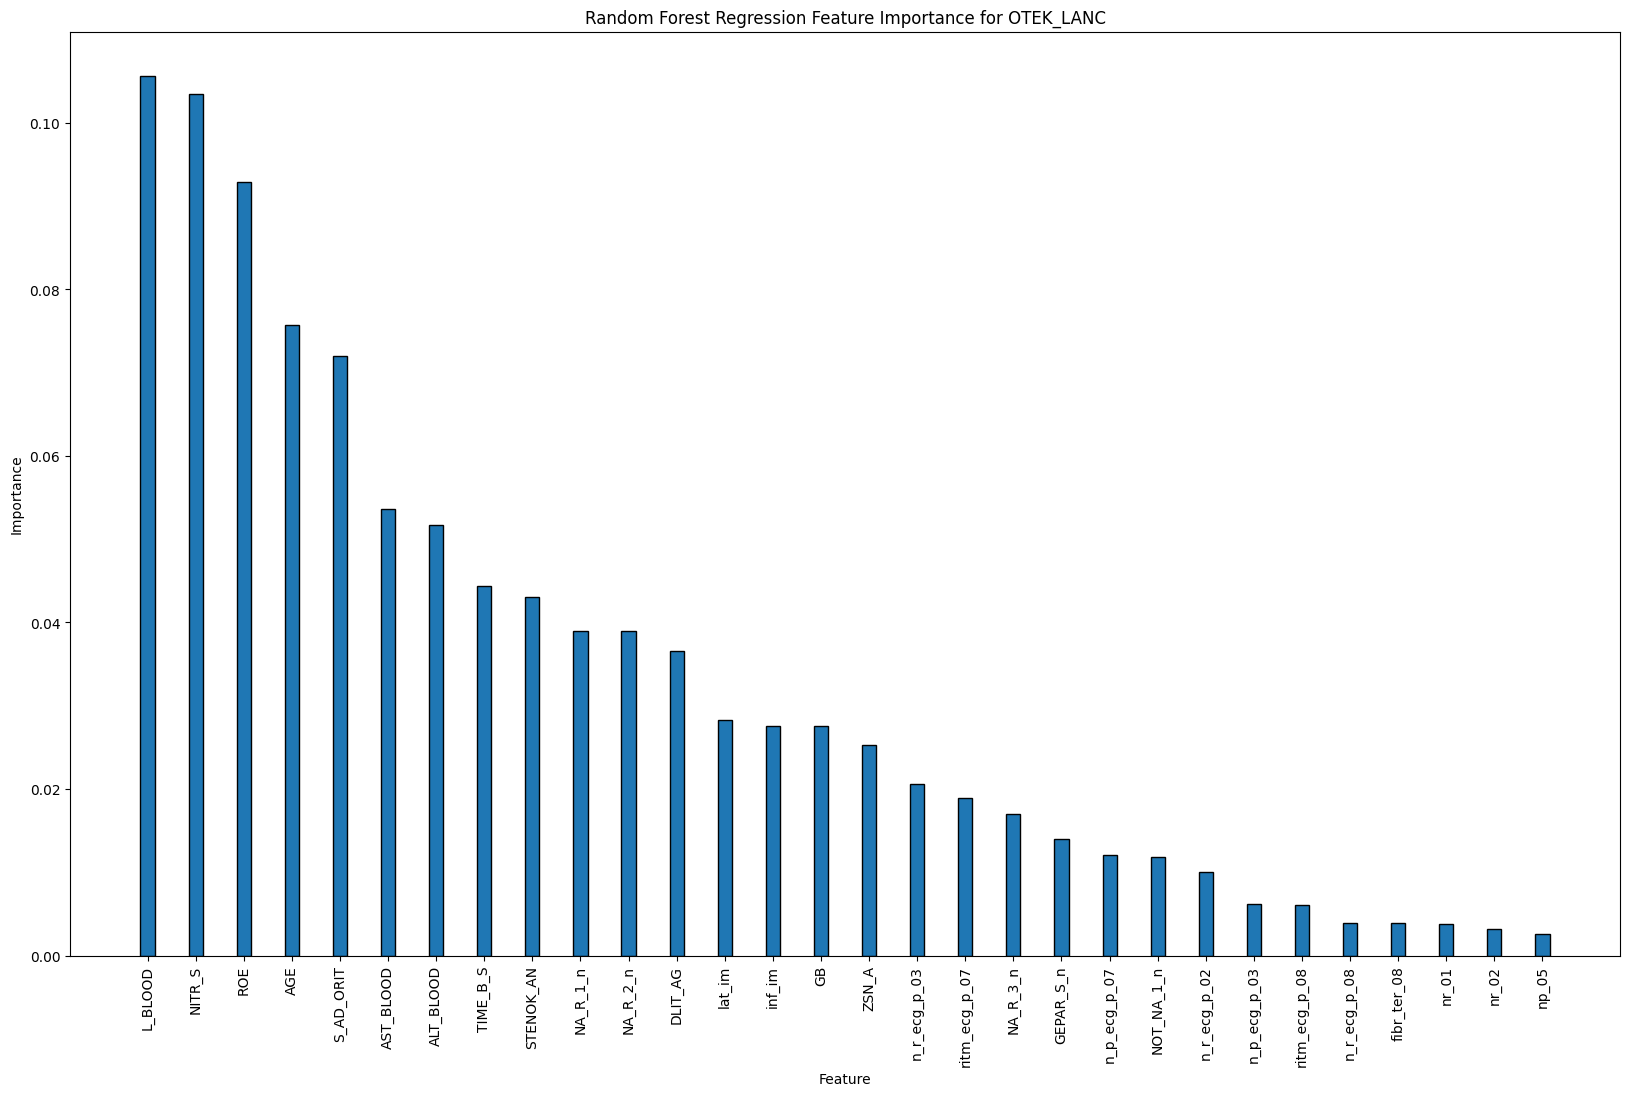

ZSN weighted F1 score on test data: 0.44000000000000006
ZSN precision score on test data: 0.6666666666666666
ZSN recall score on test data: 0.3283582089552239


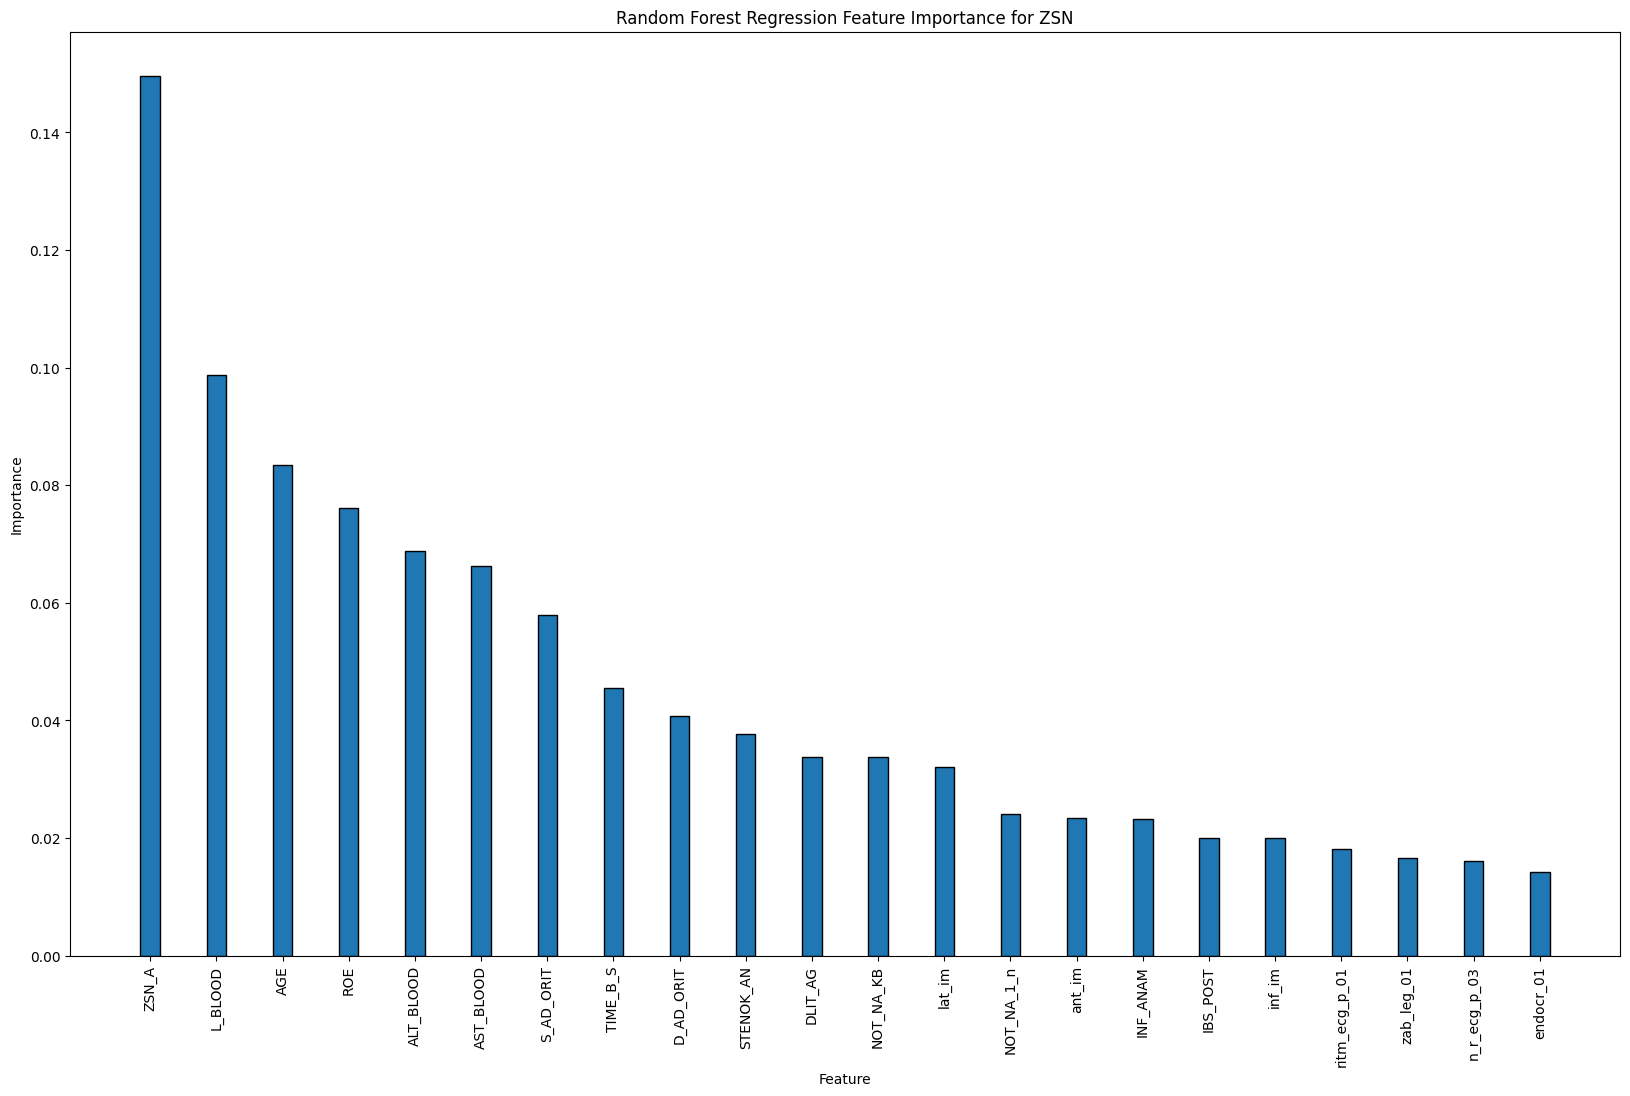

P_IM_STEN weighted F1 score on test data: 0.19672131147540983
P_IM_STEN precision score on test data: 0.15789473684210525
P_IM_STEN recall score on test data: 0.2608695652173913


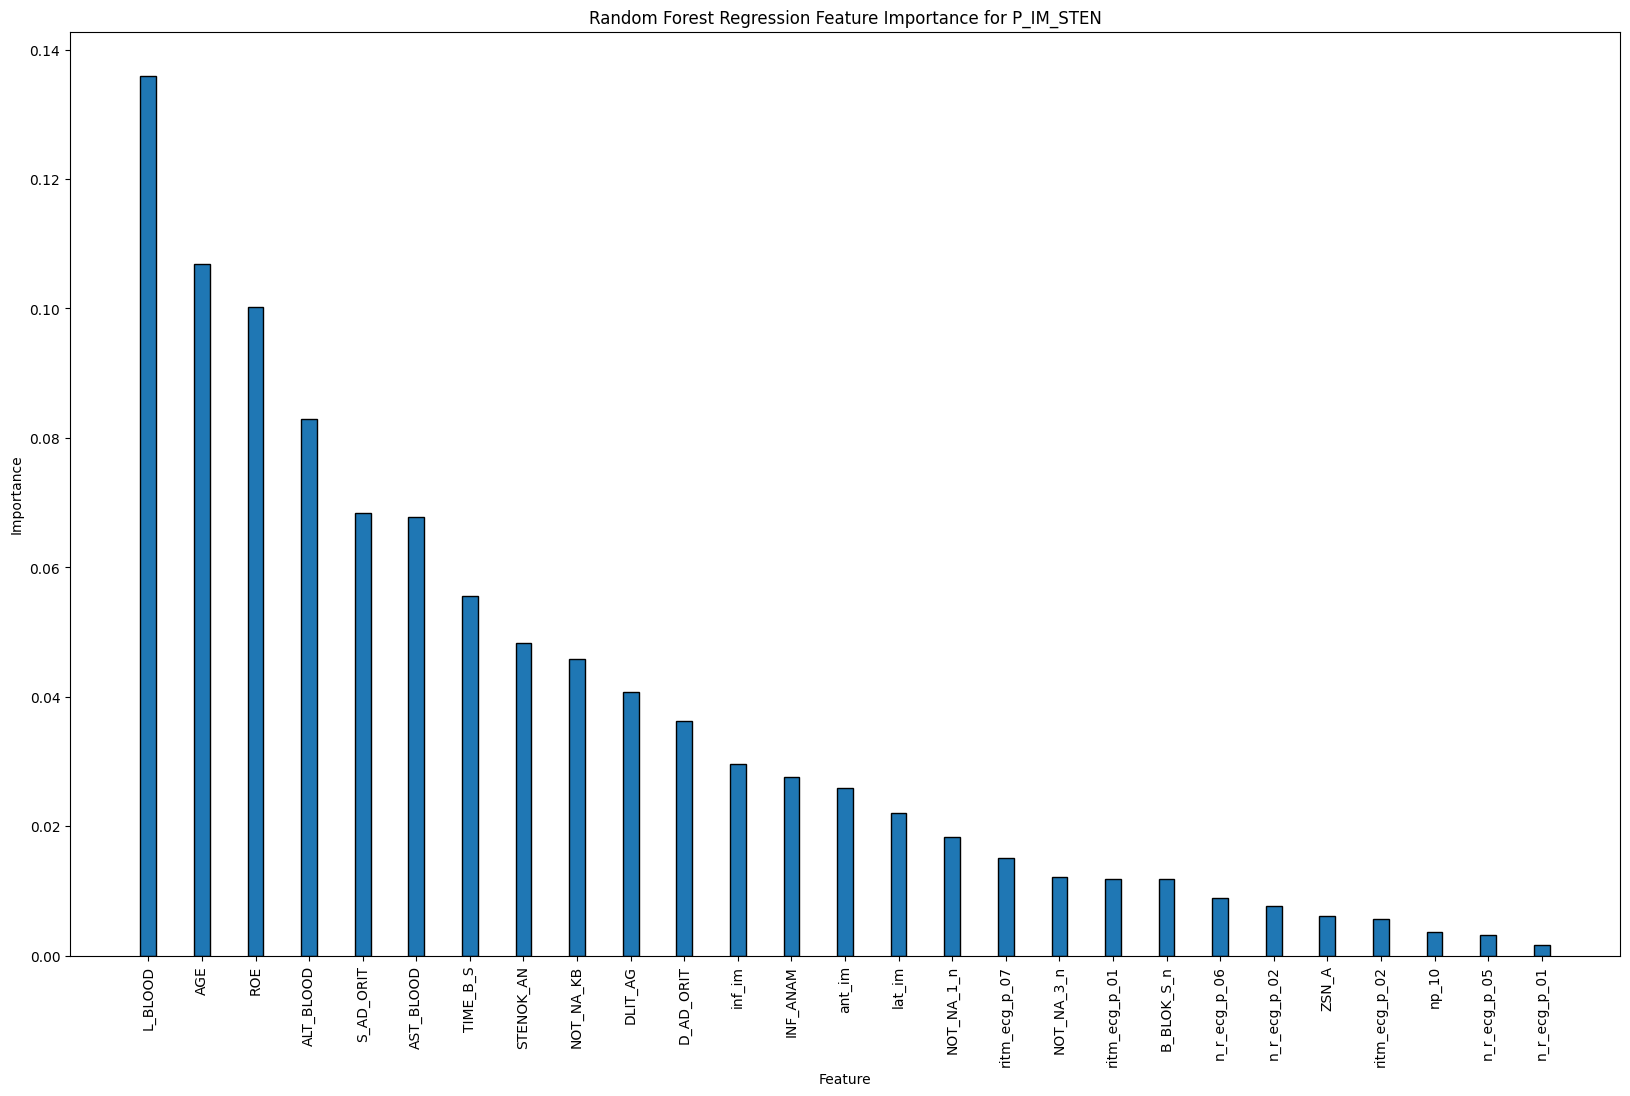

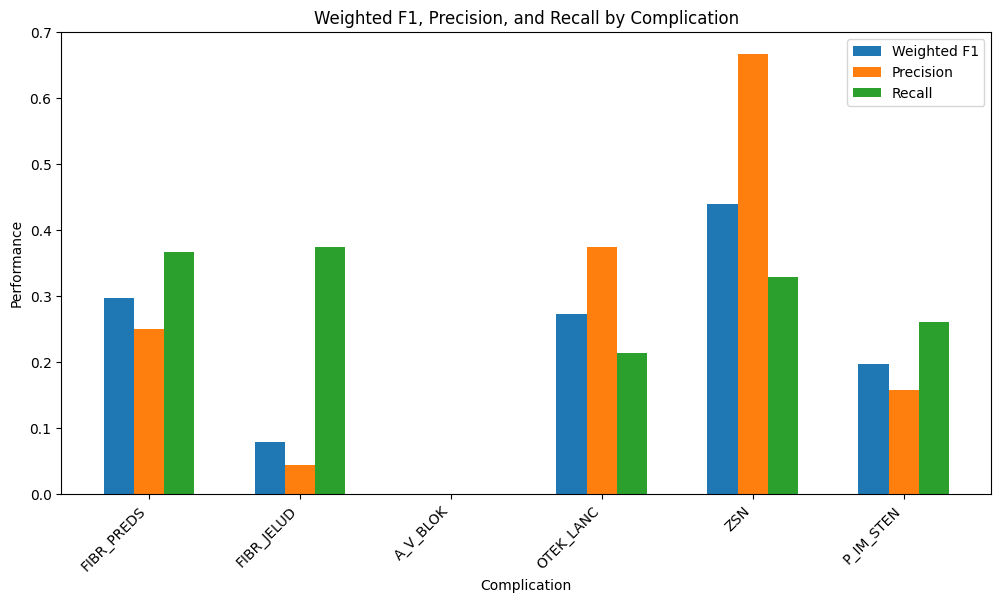

{'FIBR_PREDS': 0.29729729729729726, 'FIBR_JELUD': 0.07894736842105263, 'A_V_BLOK': nan, 'OTEK_LANC': 0.2727272727272727, 'ZSN': 0.44000000000000006, 'P_IM_STEN': 0.19672131147540983}


In [22]:
def graph_three(keys, list1, list2, list3, description1, description2, description3, xlabel):
    """
    generic function to graph three lists with the same keys
    """
    bar_width = 0.2
    index = np.arange(len(keys))
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bar1 = ax.bar(index, list1, bar_width, label=description1)
    bar2 = ax.bar(index + bar_width, list2, bar_width, label=description2)
    bar3 = ax.bar(index + bar_width * 2, list3, bar_width, label=description3)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Performance')
    ax.set_title(f"Weighted F1, Precision, and Recall by {xlabel}")
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(keys, rotation=45, ha='right')
    ax.legend()
    
    plt.show()

# complication models
model = RandomForestRegressor(random_state=random_seed)
complication_scores = {}
complication_score_list = []
complication_prec_list = []
complication_rec_list = []
for complication in new_complications_list:
    score, fitted_model =  run_model_on_target_complication(model, scaled_knn_datasets['train_validation_tune_threshold'], scaled_single_datasets['test'], knn_complication_features_dict[complication], complication, knn_optimal_dict[complication][0], return_model=True, scoring = 'final')
    print(f"{complication} weighted F1 score on test data: {score}")
    complication_scores[complication] = score
    prec = run_model_on_target_complication(model, scaled_knn_datasets['train_validation_tune_threshold'], scaled_single_datasets['test'], knn_complication_features_dict[complication], complication, knn_optimal_dict[complication][0], return_model=False, scoring='precision')  
    rec = run_model_on_target_complication(model, scaled_knn_datasets['train_validation_tune_threshold'], scaled_single_datasets['test'], knn_complication_features_dict[complication], complication, knn_optimal_dict[complication][0], return_model=False, scoring='recall')
    print(f"{complication} precision score on test data: {prec}")
    print(f"{complication} recall score on test data: {rec}")
    graph_features(fitted_model, knn_complication_features_dict[complication], complication)
    complication_score_list.append(score)
    complication_prec_list.append(prec)
    complication_rec_list.append(rec)

graph_three(new_complications_list, complication_score_list, complication_prec_list, complication_rec_list, 'Weighted F1', 'Precision', 'Recall', 'Complication')

print(complication_scores)

In [23]:
# compare baseline and best performing model on lethal outcome
full_train = scaled_knn_datasets['train_validation_tune_threshold'].copy()
test = scaled_knn_datasets['test'].copy()
complication_features_dict = knn_complication_features_dict
threshold_dict = knn_optimal_dict
features = predictors

score = final_predictor(model, full_train, test, features, target, threshold_dict['all'][0], 'final')
prec = final_predictor(model, full_train, test, features, target, threshold_dict['all'][0], 'precision')
rec = final_predictor(model, full_train, test, features, target, threshold_dict['all'][0], 'recall')
print(f"KNN Model All Features:")
print_score_precision_recall(score, prec, rec)
without_complication_scores = [score, prec, rec]

score = run_final(full_train, test, features, complication_features_dict, threshold_dict, 'final')
prec = run_final(full_train, test, features, complication_features_dict, threshold_dict, 'precision')
rec = run_final(full_train, test, features, complication_features_dict, threshold_dict, 'recall')
print(f"KNN Model Performance with Complications Prediction:")
print_score_precision_recall(score, prec, rec)
with_complication_scores = [score, prec, rec]

KNN Model All Features:
weighted F1 score: 0.5647058823529411
precision: 0.5454545454545454
recall: 0.5853658536585366

KNN Model Performance with Complications Prediction:
weighted F1 score: 0.5531914893617021
precision: 0.49056603773584906
recall: 0.6341463414634146



##### GRAPH FOR KNN MODEL ALL FEATURES WITHOUT COMPLICATIONS #####


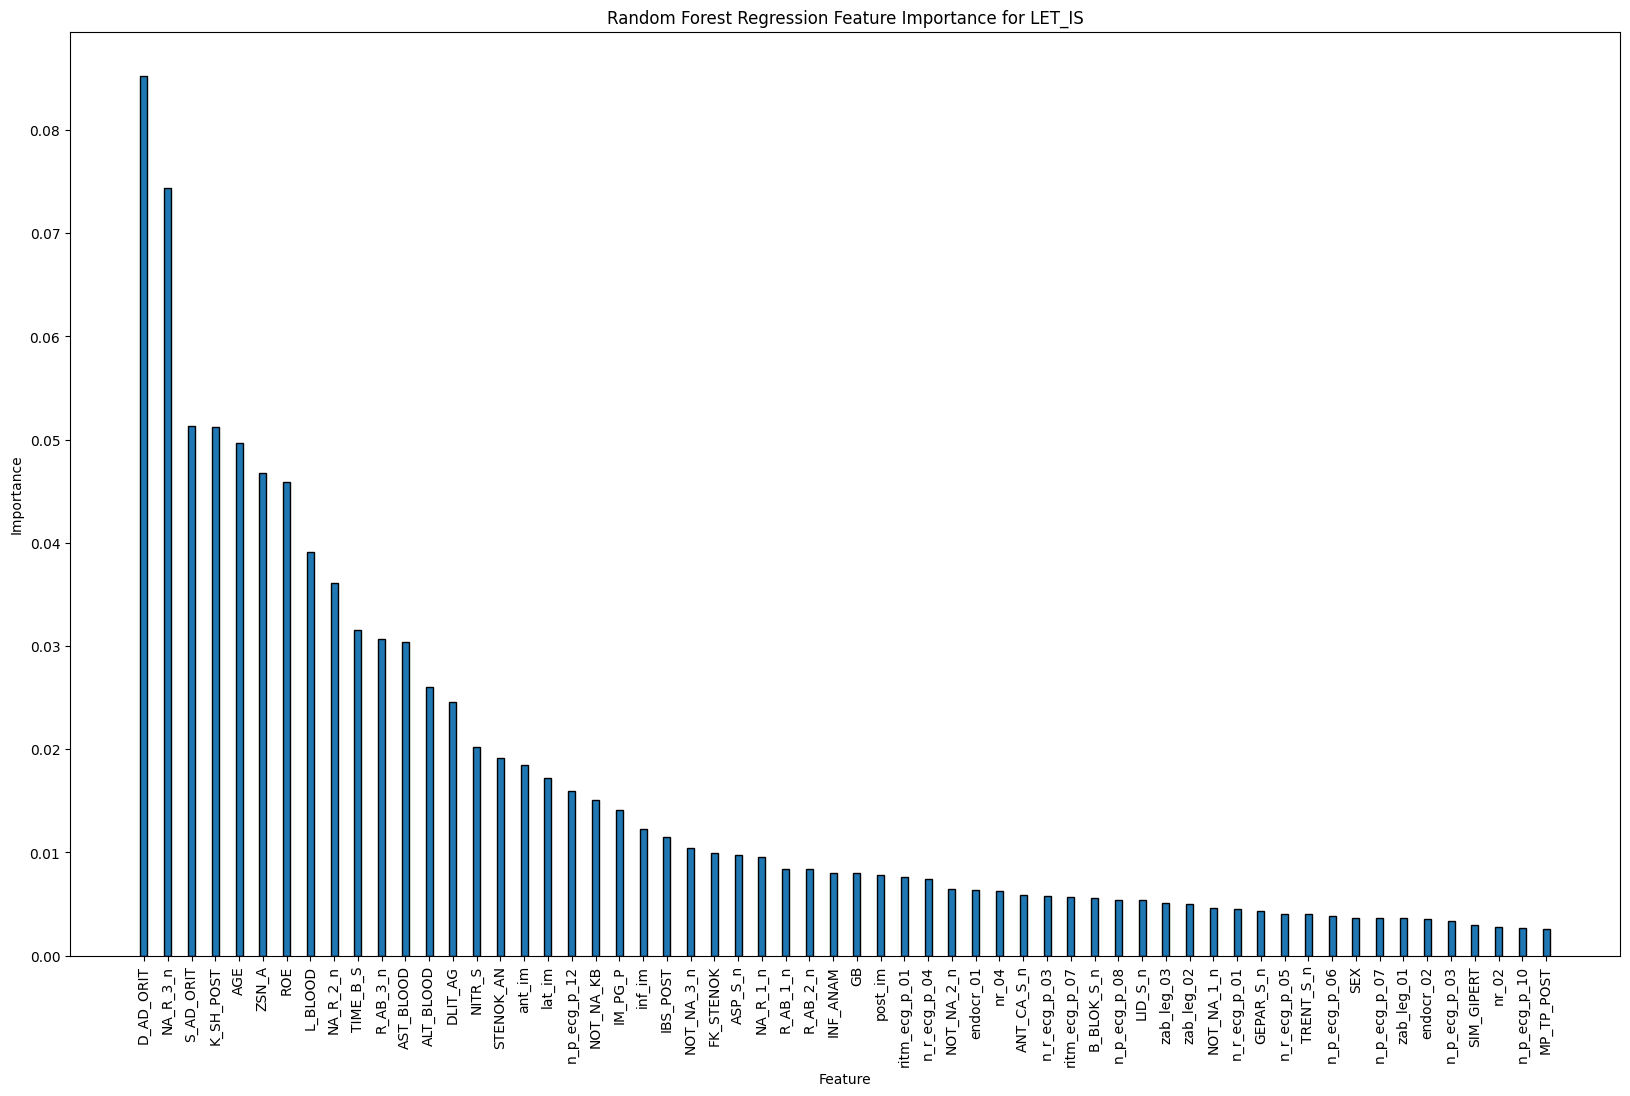

##### GRAPH FOR KNN MODEL ALL FEATURES WITH COMPLICATIONS #####


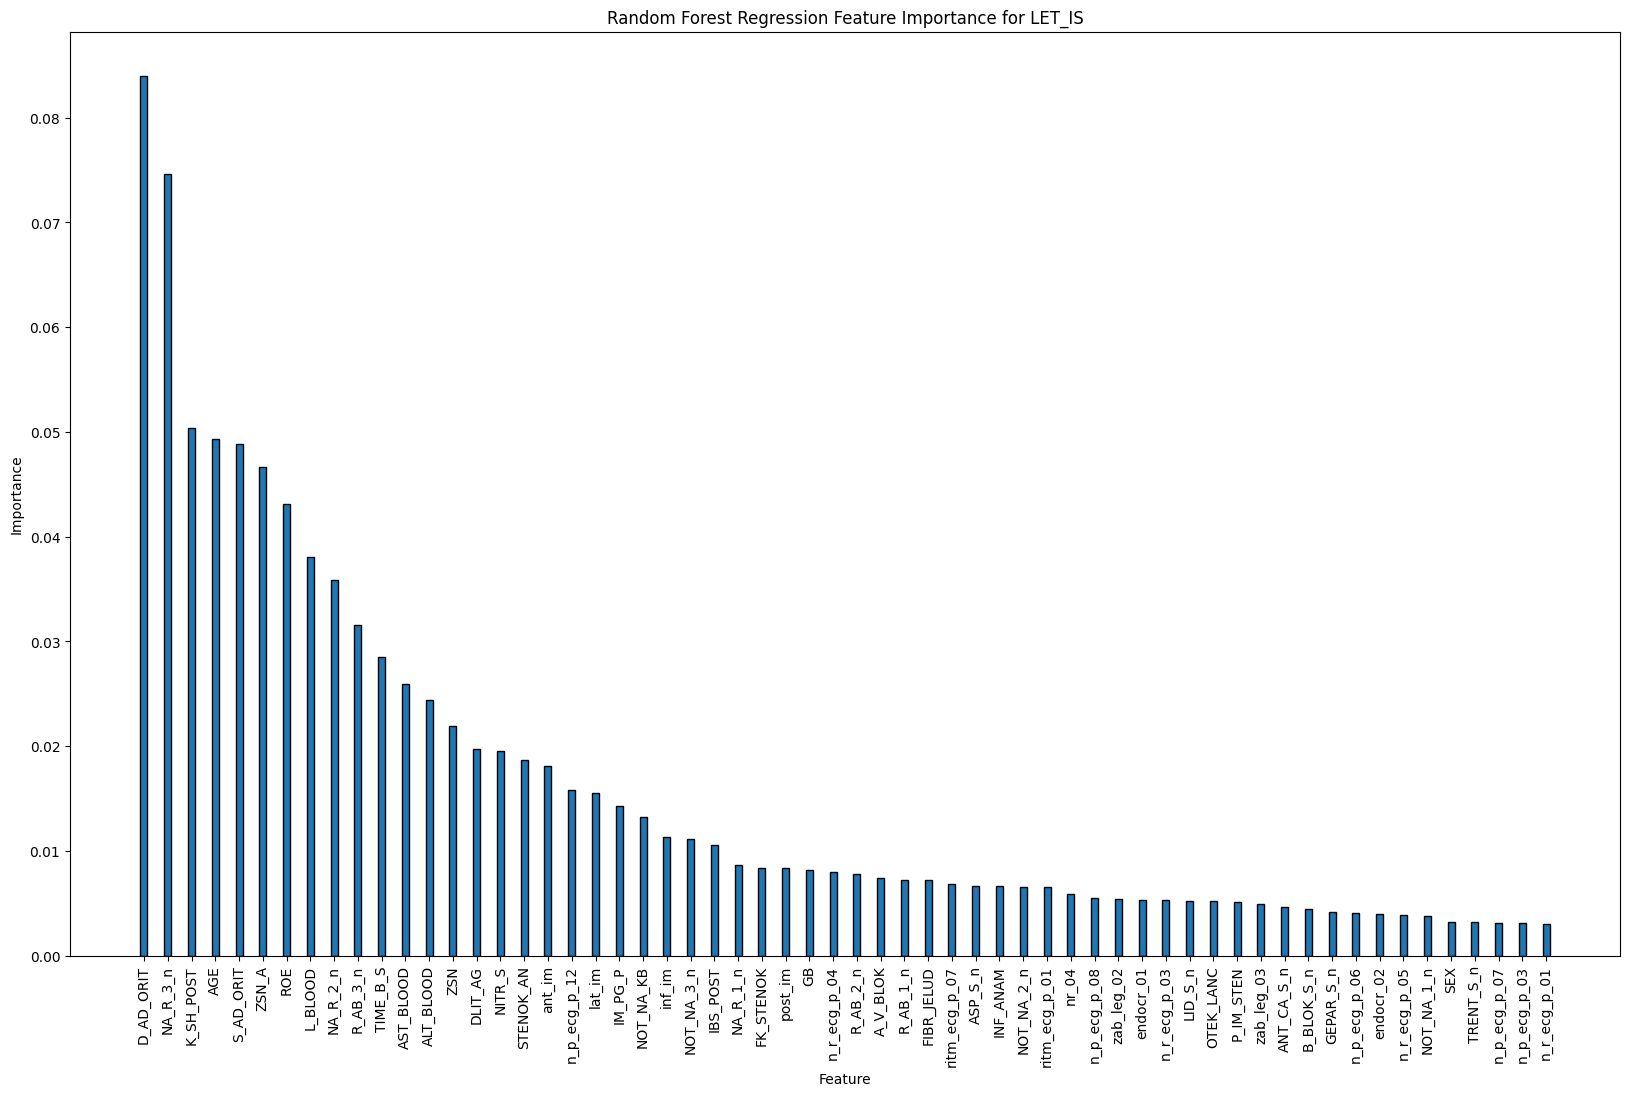

In [24]:
# report feature importance for interpretable results
print("##### GRAPH FOR KNN MODEL ALL FEATURES WITHOUT COMPLICATIONS #####")
x_train = full_train[features]
y_train = full_train[target]
model.fit(x_train, y_train)
graph_features(model, features, target)

print("##### GRAPH FOR KNN MODEL ALL FEATURES WITH COMPLICATIONS #####")
x_train = full_train[features + new_complications_list]
y_train = full_train[target]
model.fit(x_train, y_train)
temp = graph_features(model, features + new_complications_list, target)

Naive baseline:
weighted F1 score: 0.24489795918367344
precision: 0.75
recall: 0.14634146341463414



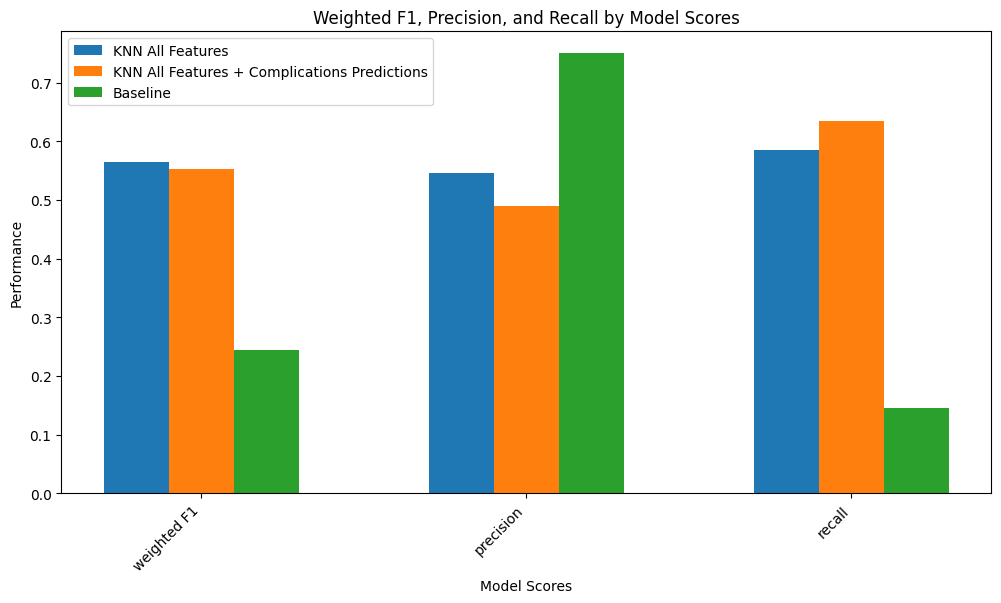

In [25]:
# for comparison purposes, build an absolute dummy baseline model using rf classifier and single imputation
from sklearn.ensemble import RandomForestClassifier
target = 'LET_IS'
train, test = train_test_split(dataframe, test_size = 0.15, random_state = random_seed, stratify = dataframe[target])
train[target] = train[target].apply(lambda x: 1 if x >= 1 else 0)
test[target] = test[target].apply(lambda x: 1 if x >= 1 else 0)

imputer = SimpleImputer(strategy='median')
# transform columns one by one
for col in predictors + drop_col_list:
    train[col] = imputer.fit_transform(train[col].values.reshape(-1, 1))
    test[col] = imputer.transform(test[col].values.reshape(-1, 1))

rf = RandomForestClassifier(random_state=random_seed)
x_train = train[predictors + drop_col_list]
y_train = train[target]
rf.fit(x_train, y_train)
x_val = test[predictors + drop_col_list]
y_val = test[target]
# print(x_val)
# print(x_train)
# print(y_val)
y_pred = rf.predict(x_val)
y_pred_df = pd.DataFrame(y_pred, index=x_val.index)
score = calc_custom_score(y_val, y_pred_df)
prec = precision_score(y_val, y_pred_df)
rec = recall_score(y_val, y_pred_df)
print(f"Naive baseline:")
print_score_precision_recall(score, prec, rec)
baseline_scores = [score, prec, rec]

keys = ['weighted F1', 'precision', 'recall']
graph_three(keys, without_complication_scores,with_complication_scores,baseline_scores, 'KNN All Features', 'KNN All Features + Complications Predictions', 'Baseline', 'Model Scores')

While using predictions of complications results in slightly lower overall weighted f1 score than not using the predictions, the recall is significantly improved. It is expected that hospitals will favor recall in the scoring itself (remember, I am using a custom weighted f1 scoring function which is a variant of f1 which can dynamically favor recall). These tests were performed where the scoring is set to f1. In higher value assigned to recall cases, the scoring will improve even more for the model which utilizies predictions of complications.

In any event, compared to the baseline model, both the 'predictions' model and the model which only uses features are significantly outperforming the baseline naive model in both regular weighted f1 score and even more so in recall.

###################################################################

Everything below this is following my original aim steps, before I revised aims based on poor preliminary performance

###################################################################

In [26]:
# Aim 2.2: use tuning dataset's correlation matrix to put complications into correlated groups

# note: this step is the same for both single and knn imputation, just need complications correlation matrix
tune_complications_df = scaled_single_datasets['tune'][complications]
complications_matrix = tune_complications_df.corr()

def get_correlated_feature_groups(correlation_matrix, n=2):
    # get only the upper triangle instead of the full rectangle of the matrix
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

    # get sorted correlations into column pairs
    sorted_corr = upper_triangle.stack().sort_values(ascending=False)
    column_pairs = sorted_corr.index.tolist()

    correlated_features_list = []
    used_features = set()

    # go through the pairs from most to least correlated to find most correlated partner columns (z_partners)
    for x, y in column_pairs:
        # if both x and y are already in a group, skip - they are already in a group
        if x in used_features and y in used_features:
            continue

        # find the z partners for the specified number of elements n
        # n - 2 is input because we are looking for n - 2 additional partners
        z_partners = find_max_partners(correlation_matrix, [x, y], n - 2)

        # add (x, y, *z_partners) to the list of used features
        # we know that we have found max partners for the z list as well because we are going from highest to lowest correlations
        # so last remaining piece x-y is max possible
        correlated_features_list.append([x, y, *z_partners])

        # mark features as used
        used_features.update([x, y, *z_partners])

        # when all features have been used at least once, break
        if len(used_features) == len(correlation_matrix.columns):
            break

    return correlated_features_list


def find_max_partners(correlation_matrix, features_chosen_list, n):
    # find the z partners for the specified number of elements (n)
    max_partners = []
    corr_matrix_list = [correlation_matrix[feature] for feature in features_chosen_list]

    for _ in range(n):
        max_corr_sum = -1 * len(features_chosen_list)
        max_z = None

        for col in correlation_matrix.columns:
            if col not in features_chosen_list:
                current_cor_sum = sum(corr_matrix[col] for corr_matrix in corr_matrix_list)
                if current_cor_sum > max_corr_sum:
                    max_corr_sum = current_cor_sum
                    max_z = col

        max_partners.append(max_z)
        # add max_z to list of chosen features
        features_chosen_list.append(max_z)

    return max_partners


print(complications_matrix)

# generate correlated groups of the following sizes
group_size_list = [2,3,4,5]
complication_groups_dictionary = {}
for size in group_size_list:
    complication_groups_dictionary[size] = get_correlated_feature_groups(complications_matrix, size)

complication_groups_dictionary[1] = [[complication] for complication in complications]

print(complication_groups_dictionary)

            FIBR_PREDS  PREDS_TAH  JELUD_TAH  FIBR_JELUD  A_V_BLOK  OTEK_LANC  \
FIBR_PREDS    1.000000   0.307692  -0.061360    0.020870 -0.067420   0.087706   
PREDS_TAH     0.307692   1.000000  -0.018880   -0.022475 -0.020745   0.158545   
JELUD_TAH    -0.061360  -0.018880   1.000000    0.139325 -0.033095   0.068885   
FIBR_JELUD    0.020870  -0.022475   0.139325    1.000000  0.121004   0.040268   
A_V_BLOK     -0.067420  -0.020745  -0.033095    0.121004  1.000000  -0.059131   
OTEK_LANC     0.087706   0.158545   0.068885    0.040268 -0.059131   1.000000   
RAZRIV       -0.054718  -0.016836  -0.026860   -0.031974 -0.029512  -0.047990   
DRESSLER     -0.061360  -0.018880  -0.030120   -0.035856 -0.033095  -0.053816   
ZSN           0.110432   0.053092  -0.031170   -0.063378  0.093066   0.082327   
REC_IM        0.006910  -0.036144   0.058341   -0.068642 -0.063357   0.173326   
P_IM_STEN    -0.024282  -0.029886  -0.047679   -0.056757 -0.052387  -0.004259   

              RAZRIV  DRESS

In the above segment of code, I form the highest correlated groups of various sizes (groups such that the sum of the pairs of correlations is as high as possible). Each complication is required to be in at least one group. If a complication is already in a group, it may be used again, but a new group will not be formed that consists only of already-used complications. I used this framework and applied it to form groups of size listed in the group_size_list.

Aim 3.1: For each correlated group, train an MLP model to predict the probability of each of those complications arising. For scoring during training, use weighted sum (based on hyperparameter) of sensitivity and specificity.
Repeat for each correlated group and perform for both single and knn imputation.

In [27]:
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import r2_score, f1_score, recall_score, precision_score

# arbitrarily chosen threshold to force positive classifications
positive_threshold = 0.03
recall_factor = 0.5
precision_factor = 1 - recall_factor

def calc_custom_score(y_pred, y_val):
    """
    calculate user's custom score based on recall and precision weight
    the result is an F1 that is biased towards either recall or precision, but 
    crucially, is on the same scale as F1
    when recall_factor = 0.5, it is exactly equal to the F1 score
    """
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    return (recall * precision) / (recall_factor * recall + precision_factor * precision)

def run_model_on_complication_group(complication_group, train_dataset, val_dataset, features_selected):
    """
    run the model given the complication group and selected features
    """

    # model = MLPRegressor(random_state=random_seed, max_iter = 10000)
    model = RandomForestRegressor(random_state=random_seed)
    x_train = train_dataset[features_selected]
    y_train = train_dataset[complication_group]
    model.fit(x_train, y_train)
    
    x_val = val_dataset[features_selected]
    y_val = val_dataset[complication_group]
    y_pred = model.predict(x_val)
    
    return_dict = {}

    # if one complication, we do not need to index the prediction dataframe
    if len(complication_group) == 1:
        y_pred_df = pd.DataFrame(y_pred)
        y_pred_df = y_pred_df[0].apply(lambda x: 1 if x > positive_threshold else 0)
        # mse_score = mean_squared_error(y_pred_df, y_val)
        # return_dict[complication_group[0]] = mse_score
        return_dict[complication_group[0]] = calc_custom_score(y_pred_df, y_val)
    else:
        # need to recreate and correctly name the columns and index
        y_pred_df = pd.DataFrame(y_pred, columns=y_val.columns, index = y_val.index)
    
        for col in y_val.columns:
            # mse_score = mean_squared_error(y_pred_df[col], y_val[col])
            # return_dict[col] = mse_score
            # turning the regressor into a classifier
            y_pred_df[col] = y_pred_df[col].apply(lambda x: 1 if x > positive_threshold else 0)
            return_dict[col] = calc_custom_score(y_val[col], y_pred_df[col])
    return return_dict

# save the highest performing group of complications for each complication
# the keys are complications, values are a tuple of (correlation, group)
highest_performing_group_dictionary = {}

# iterate through the possible group sizes
for group_size in complication_groups_dictionary.keys():
    # get all of the groups of the given size
    all_groups_same_size = complication_groups_dictionary[group_size]
    for group in all_groups_same_size:
        return_dict = run_model_on_complication_group(group, scaled_knn_datasets['train'], scaled_knn_datasets['validation'], predictors)
        # loop through each of the individual scores
        for key in return_dict.keys():
            current_value, _ = highest_performing_group_dictionary.get(key, (0,0))
            new_value = return_dict[key]
            # print(current_value)
            # print(new_value)
            if new_value > current_value:
                highest_performing_group_dictionary[key] = new_value, group

print(highest_performing_group_dictionary)

C:\Users\saril\381D final project\381dfinal\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\saril\381D final project\381dfinal\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\saril\381D final project\381dfinal\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\saril\381D final project\381dfinal\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed whe

{'FIBR_PREDS': (0.2655601659751038, ['PREDS_TAH', 'RAZRIV', 'FIBR_PREDS']), 'PREDS_TAH': (0.05405405405405406, ['FIBR_PREDS', 'PREDS_TAH', 'OTEK_LANC', 'ZSN', 'FIBR_JELUD']), 'OTEK_LANC': (0.24242424242424243, ['OTEK_LANC', 'REC_IM']), 'REC_IM': (0.15730337078651685, ['REC_IM']), 'JELUD_TAH': (0.0625, ['JELUD_TAH']), 'FIBR_JELUD': (0.20588235294117646, ['JELUD_TAH', 'FIBR_JELUD']), 'DRESSLER': (0.16580310880829016, ['DRESSLER', 'ZSN']), 'ZSN': (0.3743589743589744, ['OTEK_LANC', 'REC_IM', 'ZSN']), 'A_V_BLOK': (0.11382113821138212, ['DRESSLER', 'ZSN', 'A_V_BLOK']), 'P_IM_STEN': (0.13937282229965156, ['ZSN', 'P_IM_STEN', 'REC_IM', 'FIBR_PREDS', 'OTEK_LANC']), 'RAZRIV': (0.1076923076923077, ['PREDS_TAH', 'RAZRIV', 'FIBR_PREDS'])}


In [28]:
target = 'LET_IS'
def make_predictions(train, val, predictors, target_group, target_complication):
    model = RandomForestRegressor(random_state=random_seed)
    x_train = train[predictors]
    y_train = train[target_group]
    model.fit(x_train, y_train)
    x_val = val[predictors]
    y_pred = model.predict(x_val)
    if len(target_group) == 1:
        y_pred_df = pd.DataFrame(y_pred)
        return y_pred_df
    else:
        y_pred_df = pd.DataFrame(y_pred, columns=target_group, index = x_val.index)
        return y_pred_df[target_complication]

complications_dataframe = pd.DataFrame(columns=complications)
for target_complication, value in highest_performing_group_dictionary.items():
    _, target_helpers = value
    complications_dataframe[target_complication] = make_predictions(scaled_knn_datasets['train'], scaled_knn_datasets['validation'], predictors, target_helpers, target_complication)

complications_dataframe = complications_dataframe.fillna(0)
print(complications_dataframe)

C:\Users\saril\381D final project\381dfinal\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\saril\381D final project\381dfinal\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


      FIBR_PREDS  PREDS_TAH  JELUD_TAH  FIBR_JELUD  A_V_BLOK  OTEK_LANC  \
885         0.00       0.00        0.0        0.24      0.00       0.01   
69          0.00       0.00        0.0        0.00      0.00       0.00   
1227        0.21       0.00        0.0        0.07      0.04       0.10   
750         0.01       0.00        0.0        0.01      0.15       0.13   
751         0.09       0.01        0.0        0.00      0.02       0.02   
...          ...        ...        ...         ...       ...        ...   
1038        0.03       0.00        0.0        0.05      0.05       0.17   
4           0.00       0.01        0.0        0.00      0.03       0.01   
406         0.10       0.08        0.0        0.03      0.15       0.02   
722         0.10       0.06        0.0        0.00      0.04       0.14   
98          0.00       0.00        0.0        0.00      0.00       0.00   

      RAZRIV  DRESSLER   ZSN  REC_IM  P_IM_STEN  
885     0.00      0.35  0.06    0.00       0.13  

In [29]:
# Final performance preliminary testing

# with complications
rf = RandomForestClassifier(random_state=random_seed)
train = scaled_knn_datasets['train']
val = scaled_knn_datasets['validation'] 
val = val.copy()
val[complications] = complications_dataframe
x_train = train[predictors + complications]
y_train = train[target]
rf.fit(x_train, y_train)
x_val = val[predictors + complications]
y_val = val[target]
y_pred = rf.predict(x_val)
print("Model Performance with complications weighted f1:")
print(calc_custom_score(y_val, y_pred))

# compare to without complications
rf = RandomForestClassifier(random_state=random_seed)
train = scaled_knn_datasets['train']
val = scaled_knn_datasets['validation'] 
val = val.copy()
val[complications] = complications_dataframe
x_train = train[predictors]
y_train = train[target]
rf.fit(x_train, y_train)
x_val = val[predictors]
y_val = val[target]
y_pred = rf.predict(x_val)
print("Model Performance without complications weighted f1:")
print(calc_custom_score(y_val, y_pred))


Model Performance with complications weighted f1:
0.39999999999999997
Model Performance without complications weighted f1:
0.4594594594594595


A new strategy is needed, since attempting to predict complications is worsening performance compared to not using the complication predictions at all